In [1]:
import pandas as pd

import numpy as np 
import statsmodels.api as sm   
import sklearn as sk 
import matplotlib.pyplot as plt
from scipy import stats

# Ayudantía 7: Análisis de Modelos de Regresión

Para abrir en colab: <a target="_blank" href="https://githubtocolab.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Ayudantias/Ayudantia7_AnalisisDeModelosLineales.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Regresión Lineal Simple

In [57]:
df = pd.read_csv(
    'https://github.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/SetDeDatos/Fish.csv?raw=true',    
) # descargamos el dataset
df

Species  Weight  Length1  Length2  Length3   Height   Width
0     Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1     Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2     Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3     Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4     Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
..      ...     ...      ...      ...      ...      ...     ...
154   Smelt    12.2     11.5     12.2     13.4   2.0904  1.3936
155   Smelt    13.4     11.7     12.4     13.5   2.4300  1.2690
156   Smelt    12.2     12.1     13.0     13.8   2.2770  1.2558
157   Smelt    19.7     13.2     14.3     15.2   2.8728  2.0672
158   Smelt    19.9     13.8     15.0     16.2   2.9322  1.8792

[159 rows x 7 columns]

## EDA 


> Realice un análisis exploratorio univariado y bivariado de las variables `Width` y `Height`. ¿Presentan alguna distribución particular? ¿Existen valores atípicos o sesgos?


Previo a cualquier análisis es importante saber con lo que se está trabajando. Para esto realizamos un EDA.

In [3]:
 width = df['Width'] # extraemos la columna Width
height = df['Height'] # extraemos la columna Height

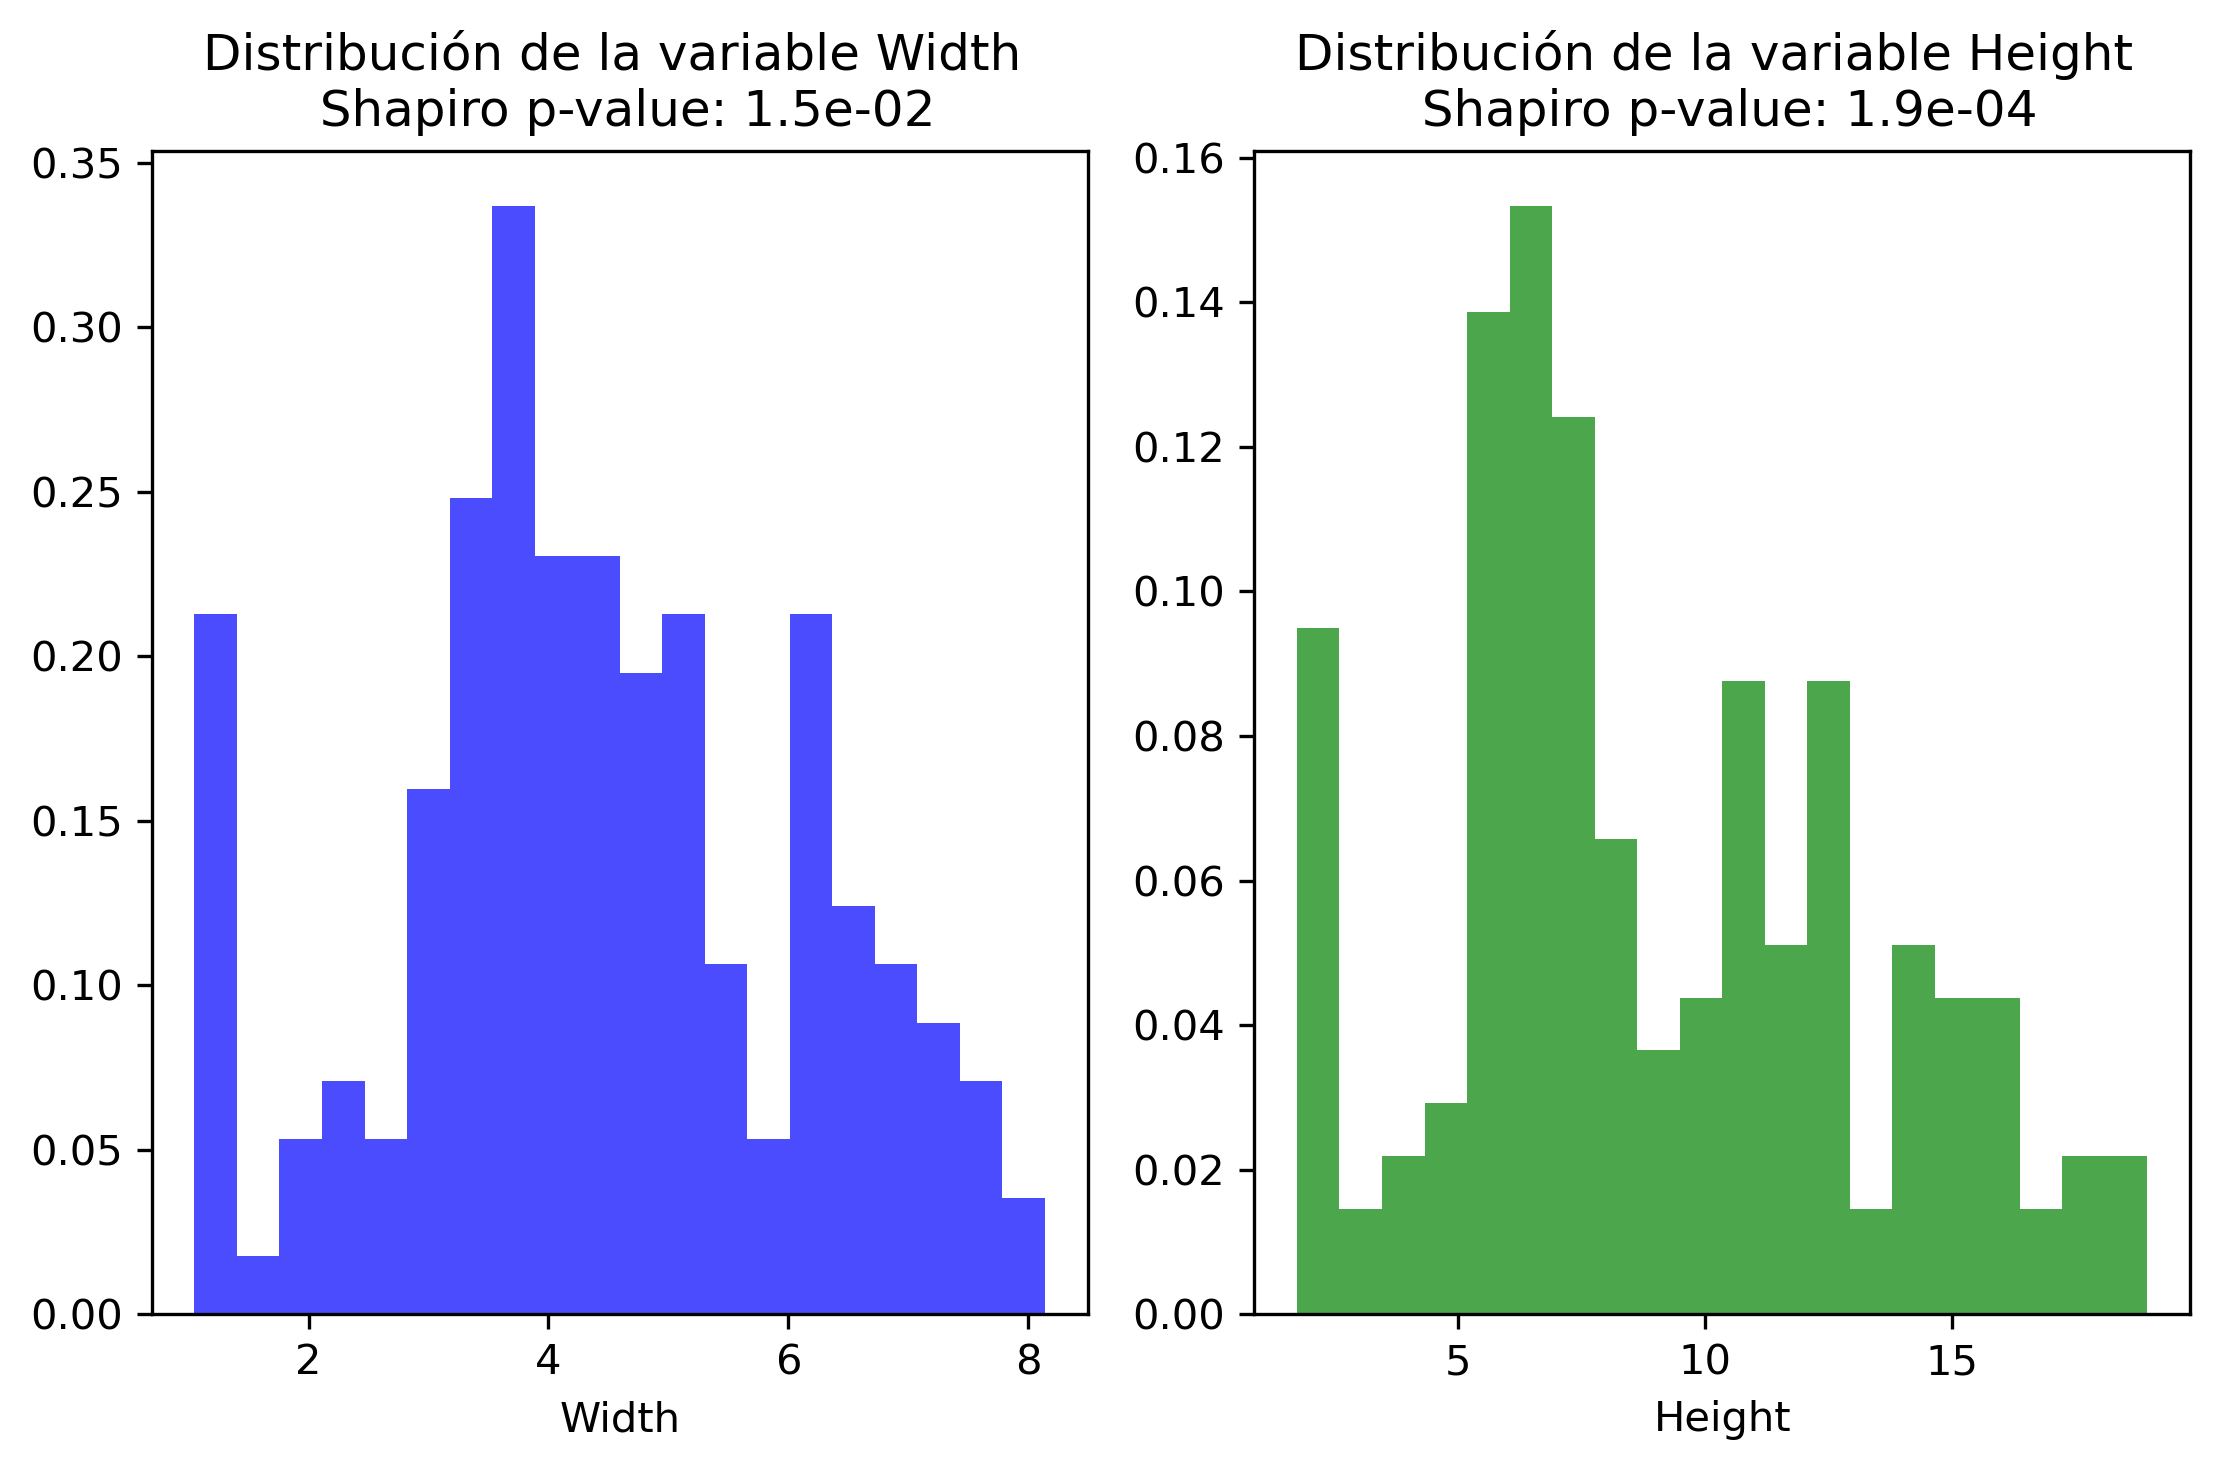

In [4]:
# Distribución de los datos
fig, ax = plt.subplots(1, 2, figsize=(7.5, 5), dpi = 300)
shapiro_p = stats.shapiro(width)[1]

ax[0].hist(width, bins=20, color='blue', alpha=0.7, density=True)
ax[0].set_title('Distribución de la variable Width \n Shapiro p-value: {:.1e}'.format(shapiro_p))
ax[0].set_xlabel('Width')

ax[1].hist(height, bins=20, color='green', alpha=0.7, density=True)
shapiro_p = stats.shapiro(height)[1]
ax[1].set_title('Distribución de la variable Height \n Shapiro p-value: {:.1e}'.format(shapiro_p))
ax[1].set_xlabel('Height')
fig.tight_layout()
plt.show()

Podemos ver que ambas distribuciones no son normales. Pero no es un problema debido a que los supuestos de normalidad una regresión lineal se aplican a los residuos :D

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_76880/4015062928.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs['scatter'].legend(loc = 'upper left')


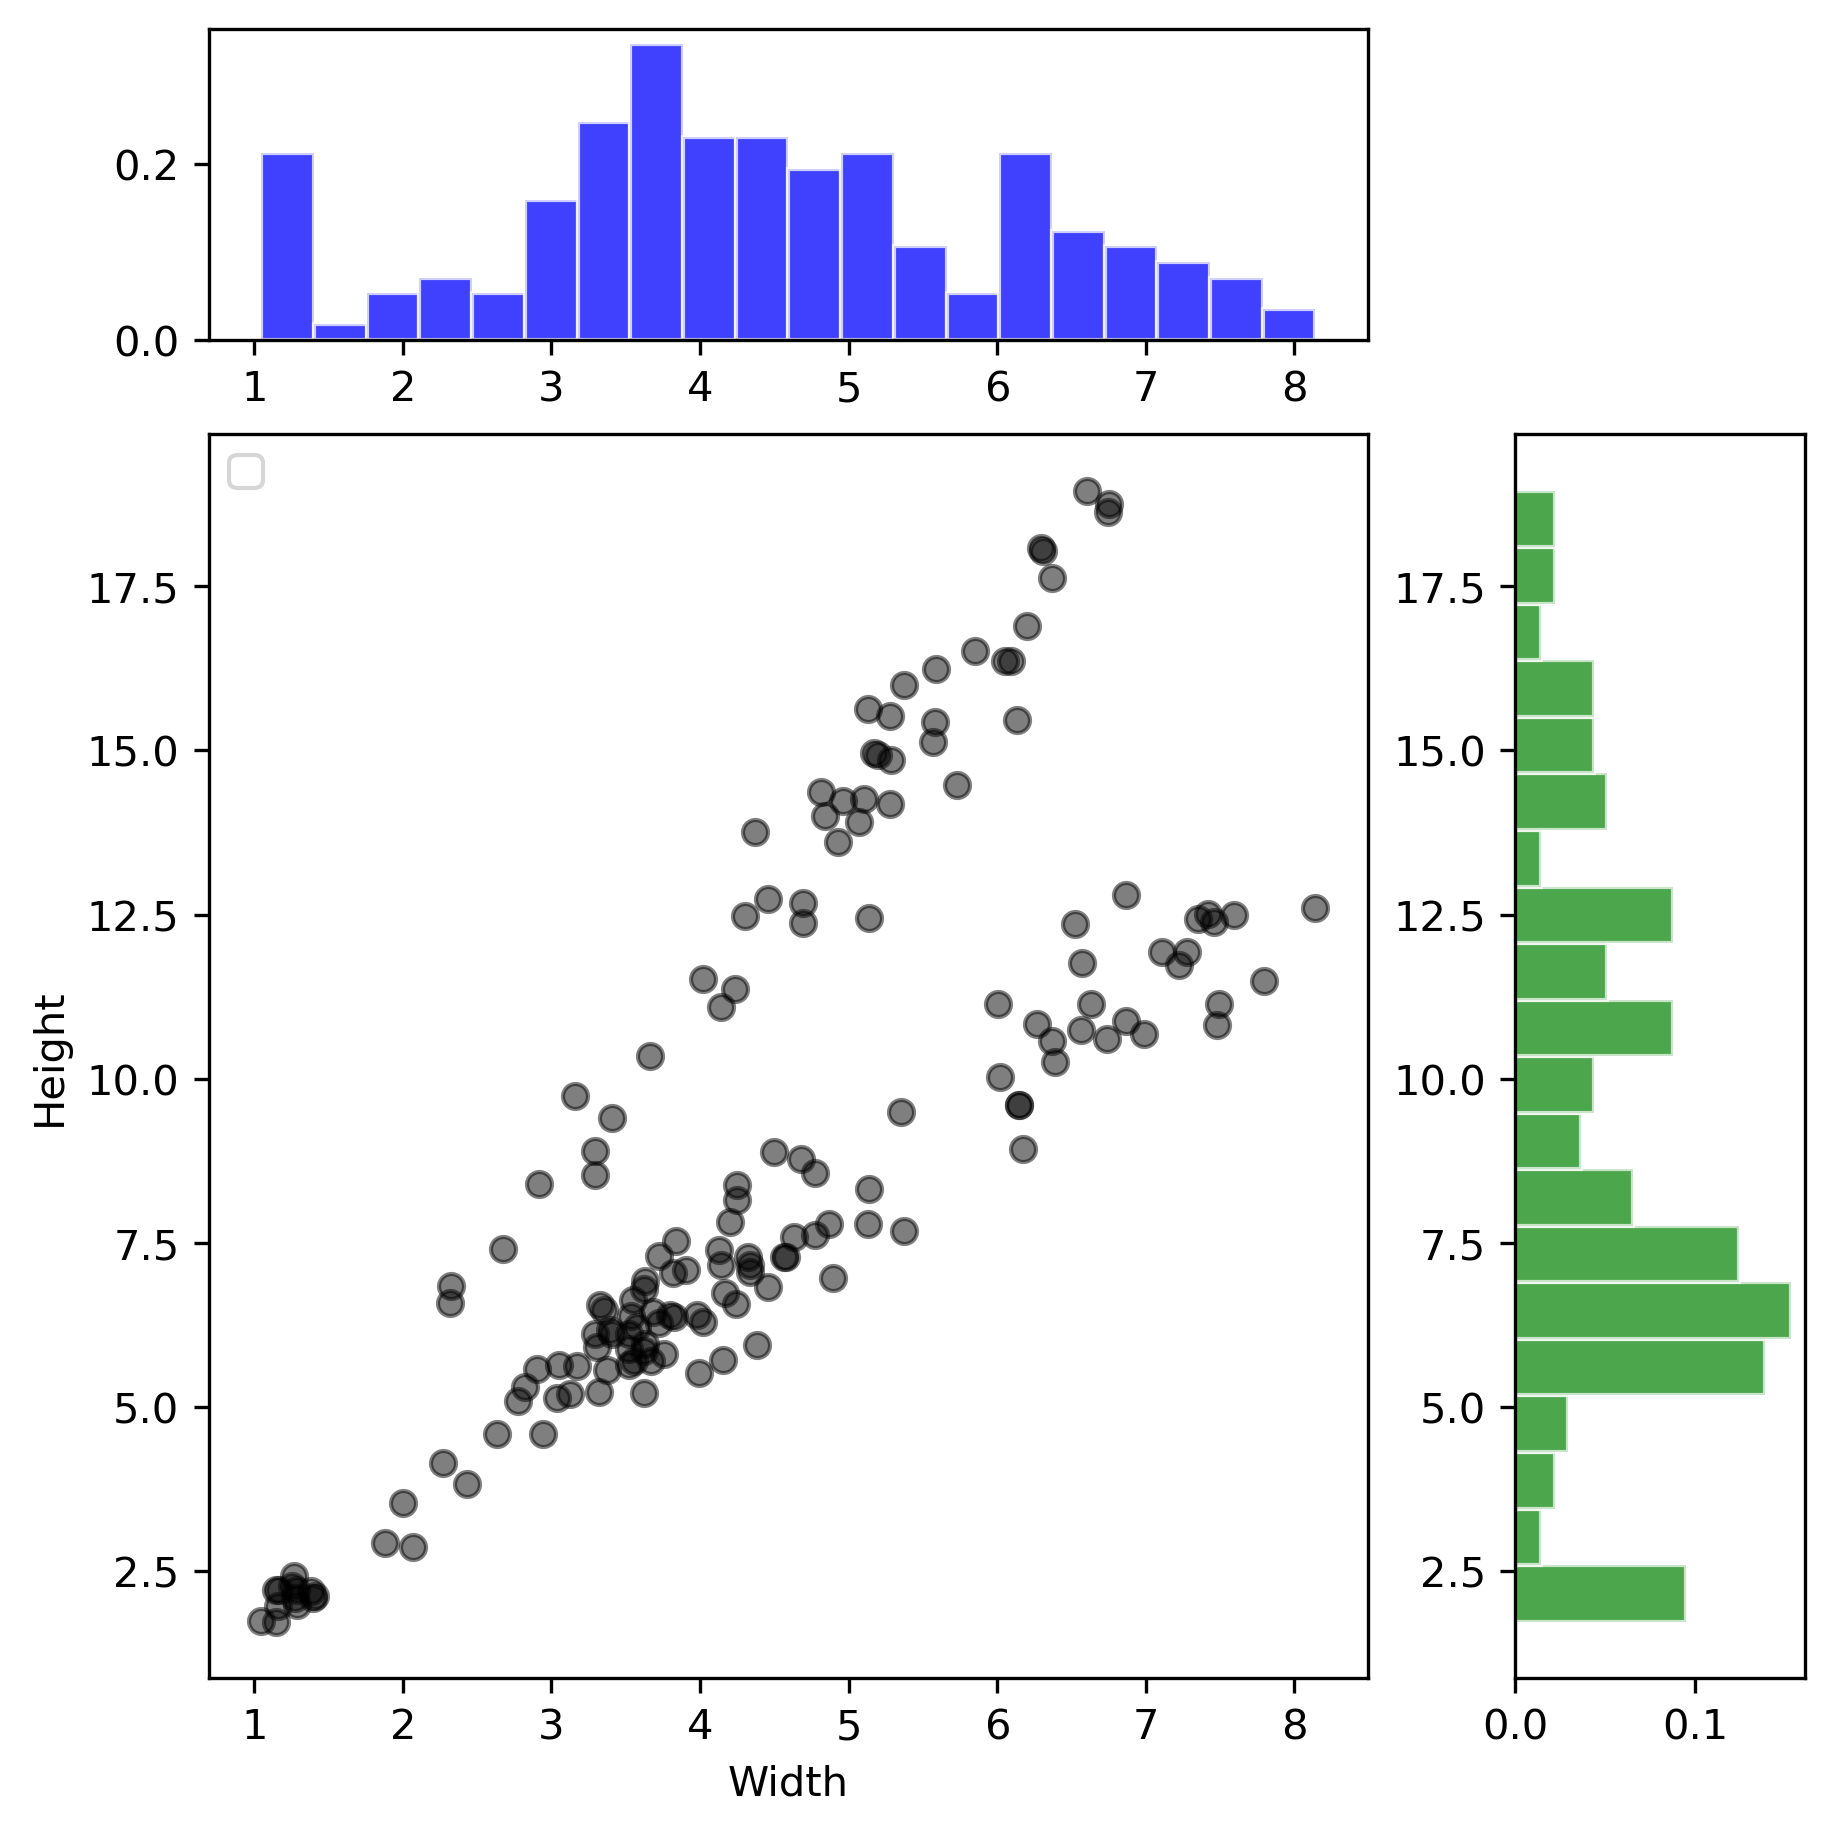

In [5]:
# Ahora analizamos ambas variables juntas
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained', dpi = 300)

# pearsonr, pearson_pval = stats.pearsonr(width, height) # calculamos el coeficiente de correlación de Pearson
axs['scatter'].scatter(width, height, alpha=0.5, color = 'black')
axs['histx'].hist(width, bins=20, color='blue', alpha=0.75, density=True, edgecolor='white')
axs['histy'].hist(height, bins=20, color='green', alpha=0.7, density=True, orientation='horizontal', edgecolor='white')
axs['scatter'].set_xlabel('Width')
axs['scatter'].set_ylabel('Height')
axs['scatter'].legend(loc = 'upper left')

Podemos ver diferentes "zonas" en la linea de regresión. ¿Qué pasa si agregamos la especie del pez en estos casos?

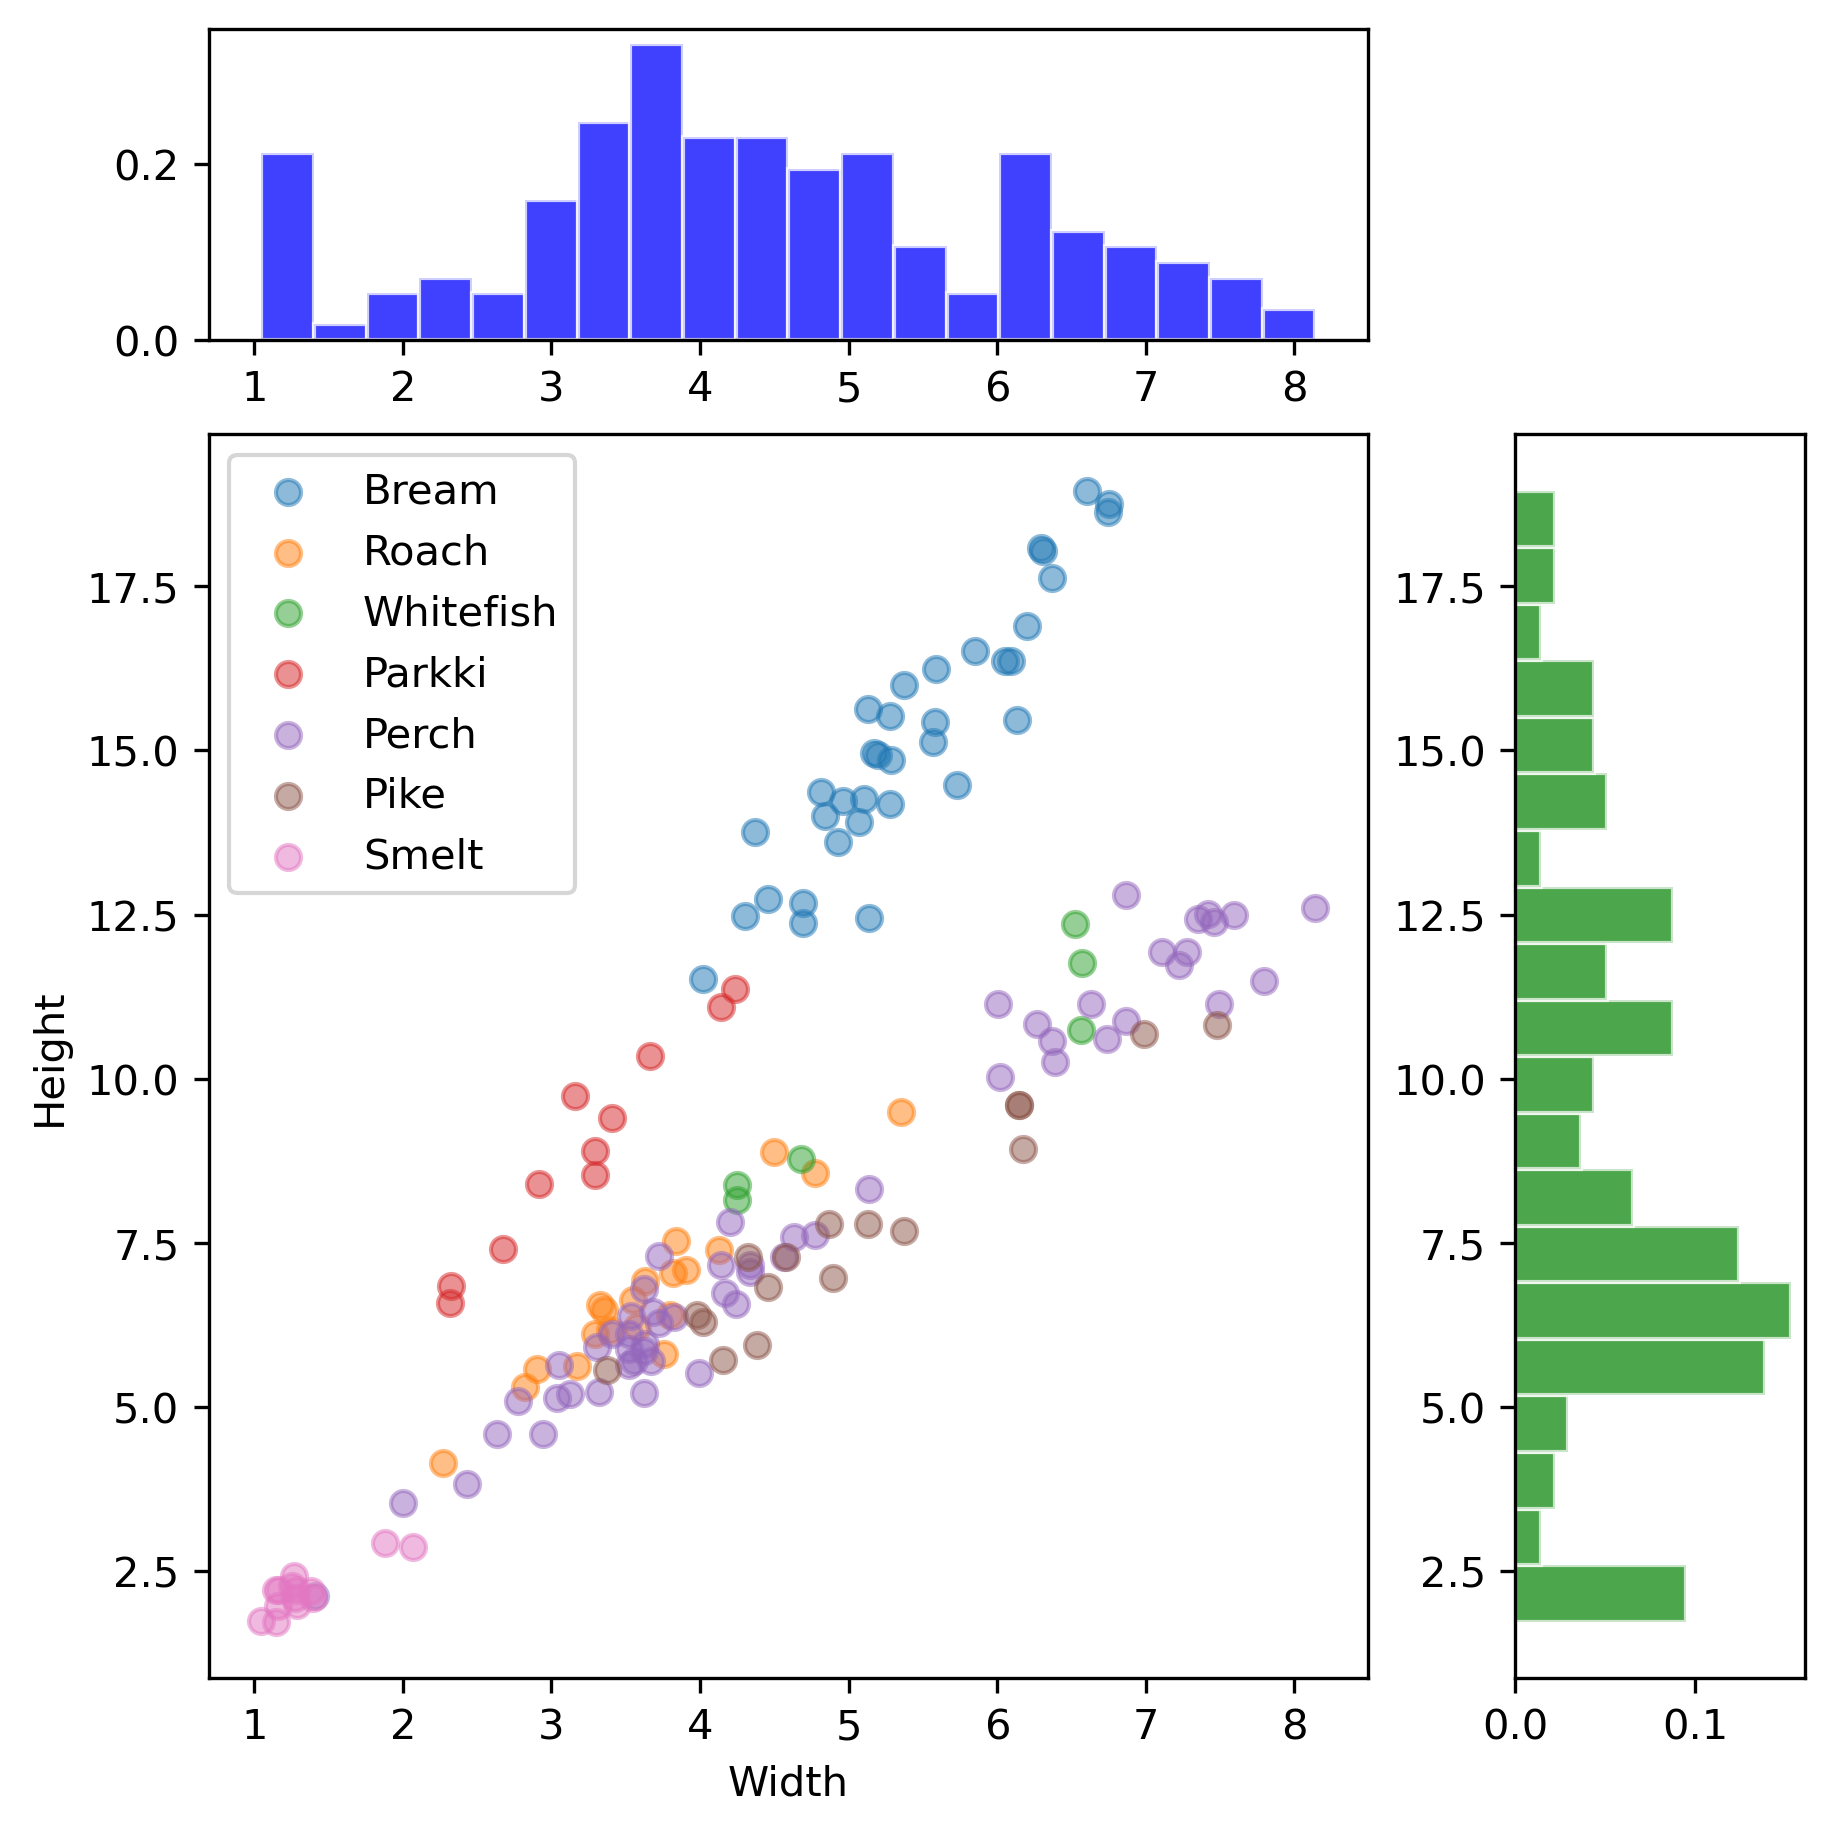

In [6]:
# Ahora analizamos ambas variables juntas
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained', dpi = 300)


specie = df['Species'] # extraemos la columna Species
for i in specie.unique():
    # slope, intercept, r_value, p_value, std_err = stats.linregress(width[specie == i], height[specie == i]) # forma rapida de calcular la regresión lineal
    # axs['scatter'].plot(width[specie == i], slope*width[specie == i] + intercept, linewidth=2)
    axs['scatter'].scatter(width[specie == i], height[specie == i], alpha=0.5, label = i)

axs['histx'].hist(width, bins=20, color='blue', alpha=0.75, density=True, edgecolor='white')
axs['histy'].hist(height, bins=20, color='green', alpha=0.7, density=True, orientation='horizontal', edgecolor='white')
axs['scatter'].set_xlabel('Width')
axs['scatter'].set_ylabel('Height')
axs['scatter'].legend(loc = 'upper left')

## Cálculo de Regresión lineal
>Estime los coeficientes de un modelo de regresión lineal simple que relacione `Height` como variable respuesta y `Width` como predictor. Grafique los datos junto con la recta ajustada. 
>>Agregue en la esquina superior derecha una etiqueta que indique el coeficiente de correlación de Pearson y su valor-$p$.

Recordando que la regresión lineal posee la forma 
$$
\mathbf{y} = \beta_0 + \beta_1 \mathbf{x}
$$
Donde $\mathbf{y}$ es el vector de datos respuesta y $\mathbf{x}$ es el vector con los datos explicativos. Ahora, podemos calcular los valores de $\beta_0$ y $\beta_1$ por medio de las siguientes ecuaciones:

$$
\widehat{\beta}_1 = \frac{S_{xy}}{S_{xx}}
$$
$$
\widehat{\beta}_0 = \overline{y} - \widehat{\beta}_1 \overline{x}
$$

Donde, x es `Width` e y es `Height`.

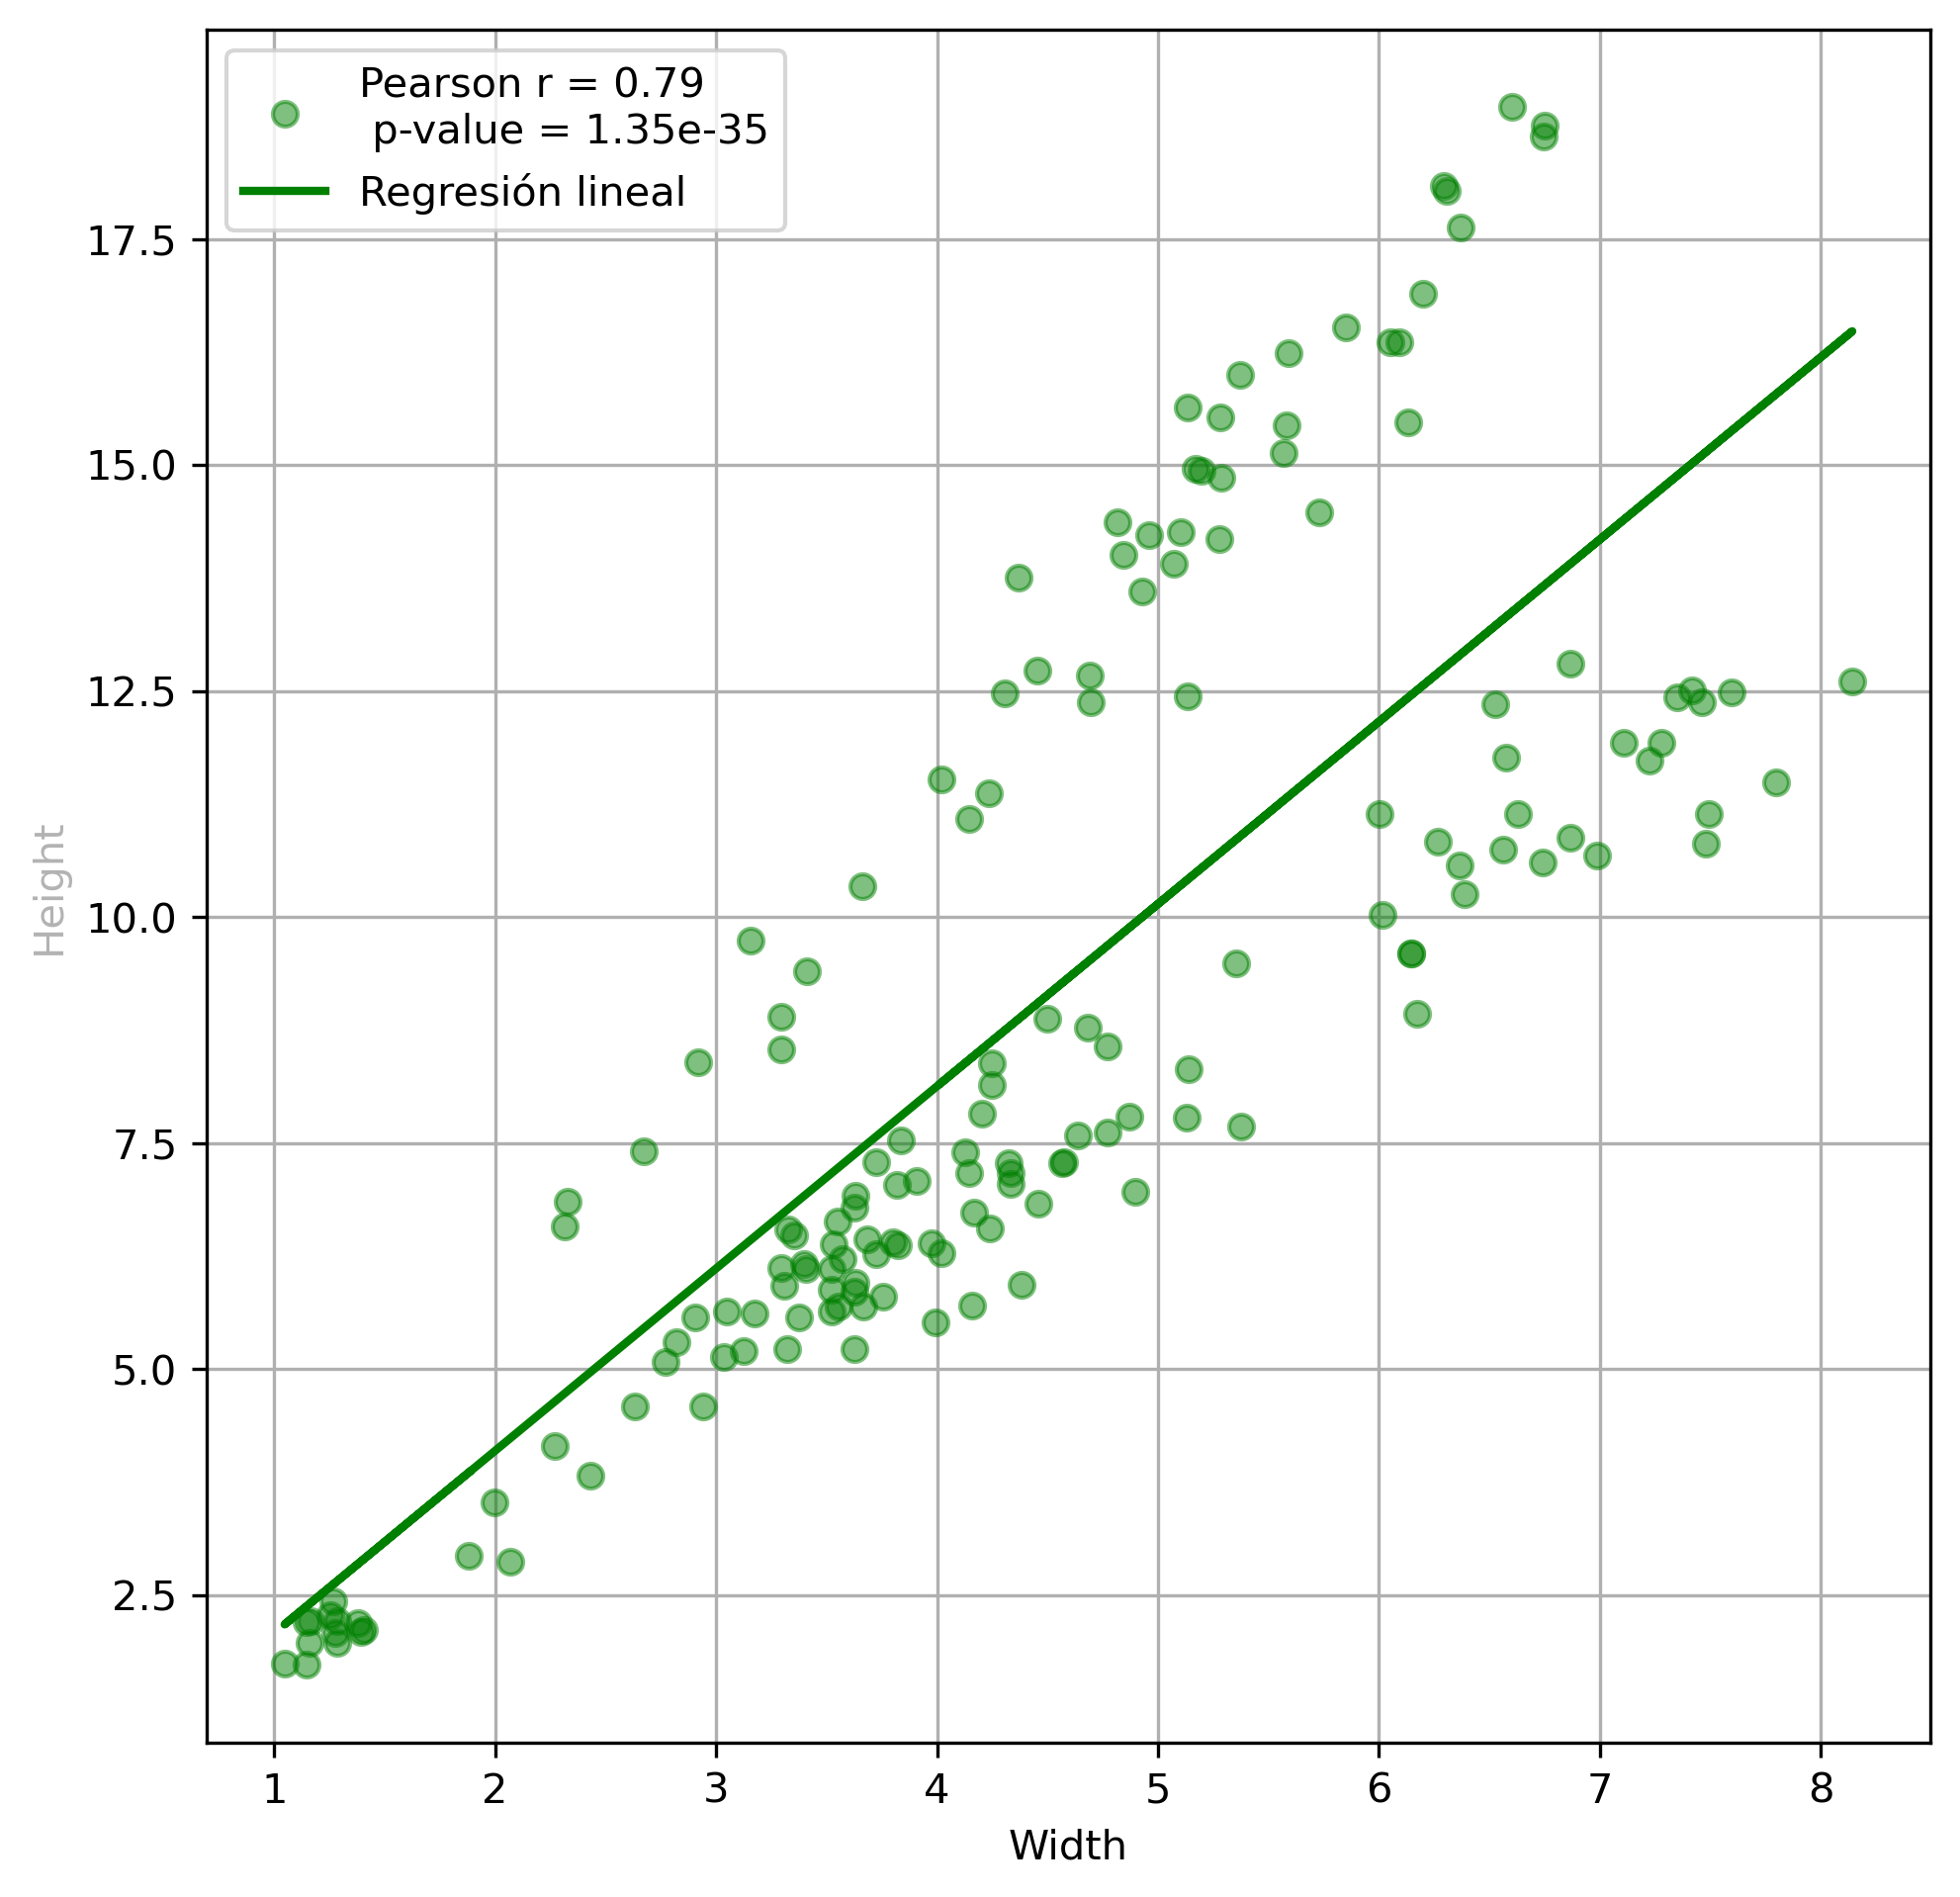

In [7]:
S_xx = np.sum((width - np.mean(width))**2) # suma de cuadrados de X 
S_xy = np.sum((width - np.mean(width))*(height - np.mean(height))) # suma de cuadrados cruzada

hat_beta_1 = S_xy/S_xx # pendiente de la recta de regresión
hat_beta_0 = np.mean(height) - hat_beta_1*np.mean(width) # intersección de la recta de regresión

# ahora graficamos
fig, ax = plt.subplots(figsize=(7.5, 7.5), dpi = 300)
pearson_r, pearson_pval = stats.pearsonr(width, height) # calculamos el coeficiente de correlación de Pearson
ax.scatter(width, height, alpha=0.5, color = 'green',
           label = f'Pearson r = {pearson_r:.2f} \n p-value = {pearson_pval:.2e}',zorder = 3)
ax.plot(width, hat_beta_1*width + hat_beta_0, linewidth=2, color = 'green', label = 'Regresión lineal', zorder = 3)
ax.legend( loc = 'upper left')
ax.set_xlabel('Width')
ax.set_ylabel('Height', alpha = 0.3, zorder = 0)
ax.grid()
plt.show()

## Coeficiente de determinación
> Calcule el coeficiente de determinación ($R^2$) del modelo. ¿Qué proporción de la varianza de la altura es explicada por la anchura?

Recordemos que el coeficiente de determinacion probee una noción de la proporción de varianza que explica el modelo de regresión lineal. La formula por la cual uno es capaz de calcular dicho coeficiente es:
$$
R^2 = \frac{SS_R}{SS_T} = 1 - \frac{SS_E}{SS_T}
$$

Donde 
$$
SS_T = SS_R + SS_E
$$

$$
SS_T = \sum_{i=1}^n (y_i - \overline{y})^2
$$
$$
SS_E = SS_T - \widehat{\beta}_1S_{xy} = \sum_{i=1}^n (y_i - \widehat{y}_i)^2
$$


In [8]:
SS_T = np.sum((height - np.mean(height))**2) # suma total de cuadrados
SS_E = SS_T - hat_beta_1*S_xy # suma de cuadrados del error
R2 = 1 - SS_E/SS_T # coeficiente de determinación
print(f'R2 = {R2:.3f}') # imprimimos el coeficiente de determinación

R2 = 0.629


## Test-t sobre coeficientes
> Calcule los estadísticos $t$ (bilaterales) para los coeficientes $\beta_0$ y $\beta_1$. ¿Qué hipótesis se está testeando en cada caso? ¿Qué puede concluir?

Es posible realizar test de hipótesis sobre los coeficientes de una regresión lineal. En este caso, realizamos un test-t sobre los coeficientes para evaluar cual es la confianza que tenemos sobre el valor del mismo. Para esto planteamos la siguiente prueba para el intercepto:
$$
H_0: \beta_0 = 0
$$
$$
H_a: \beta_0 \neq 0
$$

Y para el coeficiente $\beta_1$:
$$
H_0: \beta_1 = 0
$$
$$
H_a: \beta_1 \neq 0
$$
Notar que puede ser otro valor diferente de 0, pero dejarlo en 0 nos entrega más información

**¿Por qué?**


Para realizar la prueba-t debemos calcular los estadísticos respectivos. Para la prueba sobre $\beta_0$:

$$
T_0 = \frac{\widehat{\beta_0} - \beta_{0,0} (= 0 )}{\sqrt{\widehat{\sigma}^2 \left[ \frac{1}{n} + \frac{\overline{x}^2}{S_{xx}} \right]  }} = \frac{\widehat{\beta_0}}{se(\widehat{\beta}_0)}
$$
Y sobre $\beta_1$:
$$
T_0 = \frac{\widehat{\beta}_1 - \beta_{1,0} (=0)}{\sqrt{\frac{\widehat{\sigma}^2}{S_{xx}}}}  = \frac{\widehat{\beta_1}}{se(\widehat{\beta}_1)}
$$

Recordando que
$$
\widehat{\sigma}^2 = \frac{SS_E}{n-2}
$$
La cual es la varianza estimada del error del modelo ($\epsilon$).

In [9]:
n = len(height) # número de observaciones
hat_sigma_2 = SS_E/(n - 2) # varianza del error
T_0_beta0 = hat_beta_0 / np.sqrt( hat_sigma_2 * (1/n + np.mean(width)**2/S_xx) ) 
T_0_beta1 = hat_beta_1 / np.sqrt( hat_sigma_2 / S_xx ) # estadístico de prueba para la pendiente
print(f'T_0_beta0 = {T_0_beta0:.3f}') # imprimimos el estadístico de prueba para la intersección
print(f'T_0_beta1 = {T_0_beta1:.3f}') # imprimimos el estadístico de prueba para la pendiente

T_0_beta0 = 0.112
T_0_beta1 = 16.303


In [1]:
# Ahora calculamos el p-value usando prueba de dos colas

p_value_beta0 = 2*(stats.t.sf(np.abs(T_0_beta0), n - 2)) # p-value para la intersección
p_value_beta1 = 2*(stats.t.sf(np.abs(T_0_beta1), n - 2)) # p-value para la pendiente 
print(f'p-value beta0 = {p_value_beta0:.3e}') # imprimimos el p-value para la intersección
print(f'p-value beta1 = {p_value_beta1:.3e}') # imprimimos el p-value para la pendiente

NameError: name 'stats' is not defined

## ANOVA sobre una regresión Lineal
> Aplique un análisis de varianza sobre el modelo. Interprete el resultado del valor-$p$.

Al igual que el test ANOVA, un análisis de varianza sobre el modelo de regresión lineal nos va a permitir evaluar si es posible relacionar las variables por medio de un modelo de regresión lineal. 

El test se perfila de la siguiente manera
$$
H_0 : \beta_1 = 0
$$
$$
H_a: \beta_1 \neq 0
$$

El cálculo del test se realiza por medio del siguiente estadístico
$$
F_0 = \frac{MS_R}{MS_E}
$$
Donde 
$$
MS_R = \frac{SS_R}{1} = \frac{\widehat{\beta}_1 S_{xy}}{1}
$$
$$
MS_E = \frac{SS_E}{n-2} = \frac{SS_T - \widehat{\beta}_1 SS_{xy}}{n-2}
$$

Y posteriormente rechazamos la hipótesis nula calculando el valor-p mediante una distrubición $f_{1, n-2}$



In [11]:
MS_R = hat_beta_1*S_xy/1
MS_E = SS_E/(n - 2) # media cuadrática del error
F_0 = MS_R/MS_E # estadístico de prueba para la regresión
print(f'F_0 = {F_0:.3f}') # imprimimos el estadístico de prueba para la regresión

F_0 = 265.793


In [12]:
# valor p 
p_value_F = stats.f.sf(F_0, 1, n - 2) # p-value para la regresión
print(f'p-value F = {p_value_F:.3e}') # imprimimos el p-value para la regresión

p-value F = 1.348e-35


## Intervalos de confianza en Regresión Lineal
> Calcule el intervalo de confianza del 95\% para la respuesta media $\mu_{Y|x_0}$ en varios puntos $x_0$ del predictor. Grafique nuevamente el modelo incluyendo estos intervalos de confianza.

Un concepto importante a tener en cuenta es que los modelos nunca son perfectos. En particular, George E. P. Box (estadístico británico) menciona
> En esencia , todos los modelos están equivocados, pero algunos son útiles.

Por lo cual, es necesario incorporar un poco más de utilidad a los modelos al agregar la incertidumbre del modelo con el fin de estar al tanto de este. Existen muchas formas para realizar esto, existen métodos de
- Boostraping: https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9/
- Programación Probabilistica: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html
Pero en este caso analizaremos los intervalos de confianza desde el punto de vista analítico, incorportando las distribuciones de los parámetros del modelo.

Recordemos que: 
$$
\mathbb{E}[Y|x_0] = \mu_{Y|x_0 } = \beta_0 + \beta_1 x_0 
$$
Dado que estimamos los parámetros, tenemos:
$$
\mathbb{E}[Y|x_0] = \widehat{\mu}_{Y|x_0 } = \widehat{\beta}_0 + \widehat{\beta}_1 x_0 
$$

La varianza del modelo viene dada por $\mu_{Y|x_0 }$: 
$$
\mathbb{Var}(\widehat{\mu}_{Y|x_0 }) = \sigma^2 \left[ \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]
$$

Dado a que $\beta_0$, $\beta_1$ y $\widehat{\mu}_{Y|x_0 }$ poseen una distribución normal, y utilizando $\widehat{\sigma}^2$ como estimador de la varianza del error, podemos definir:
$$
\frac{\widehat{\mu}_{Y|x_0 } - \mu_{Y|x_0 }}{ \sqrt{\widehat{\sigma}^2 \left[ \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]}}
$$
Como una variable aleatoria que sigue una distribución $t$ con $n-2$ grados de libertad. Así, podemos definir el intervalo de confianza $100(1-\alpha)\%$ para la respuesta media como:

$$
\widehat{\mu}_{Y|x_0 } - t_{\alpha/2, n-2} \sqrt{\widehat{\sigma}^2 \left[ \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]} \leq \mu_{Y|x_0} \leq \widehat{\mu}_{Y|x_0 } + t_{\alpha/2, n-2} \sqrt{\widehat{\sigma}^2 \left[ \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]} 
$$


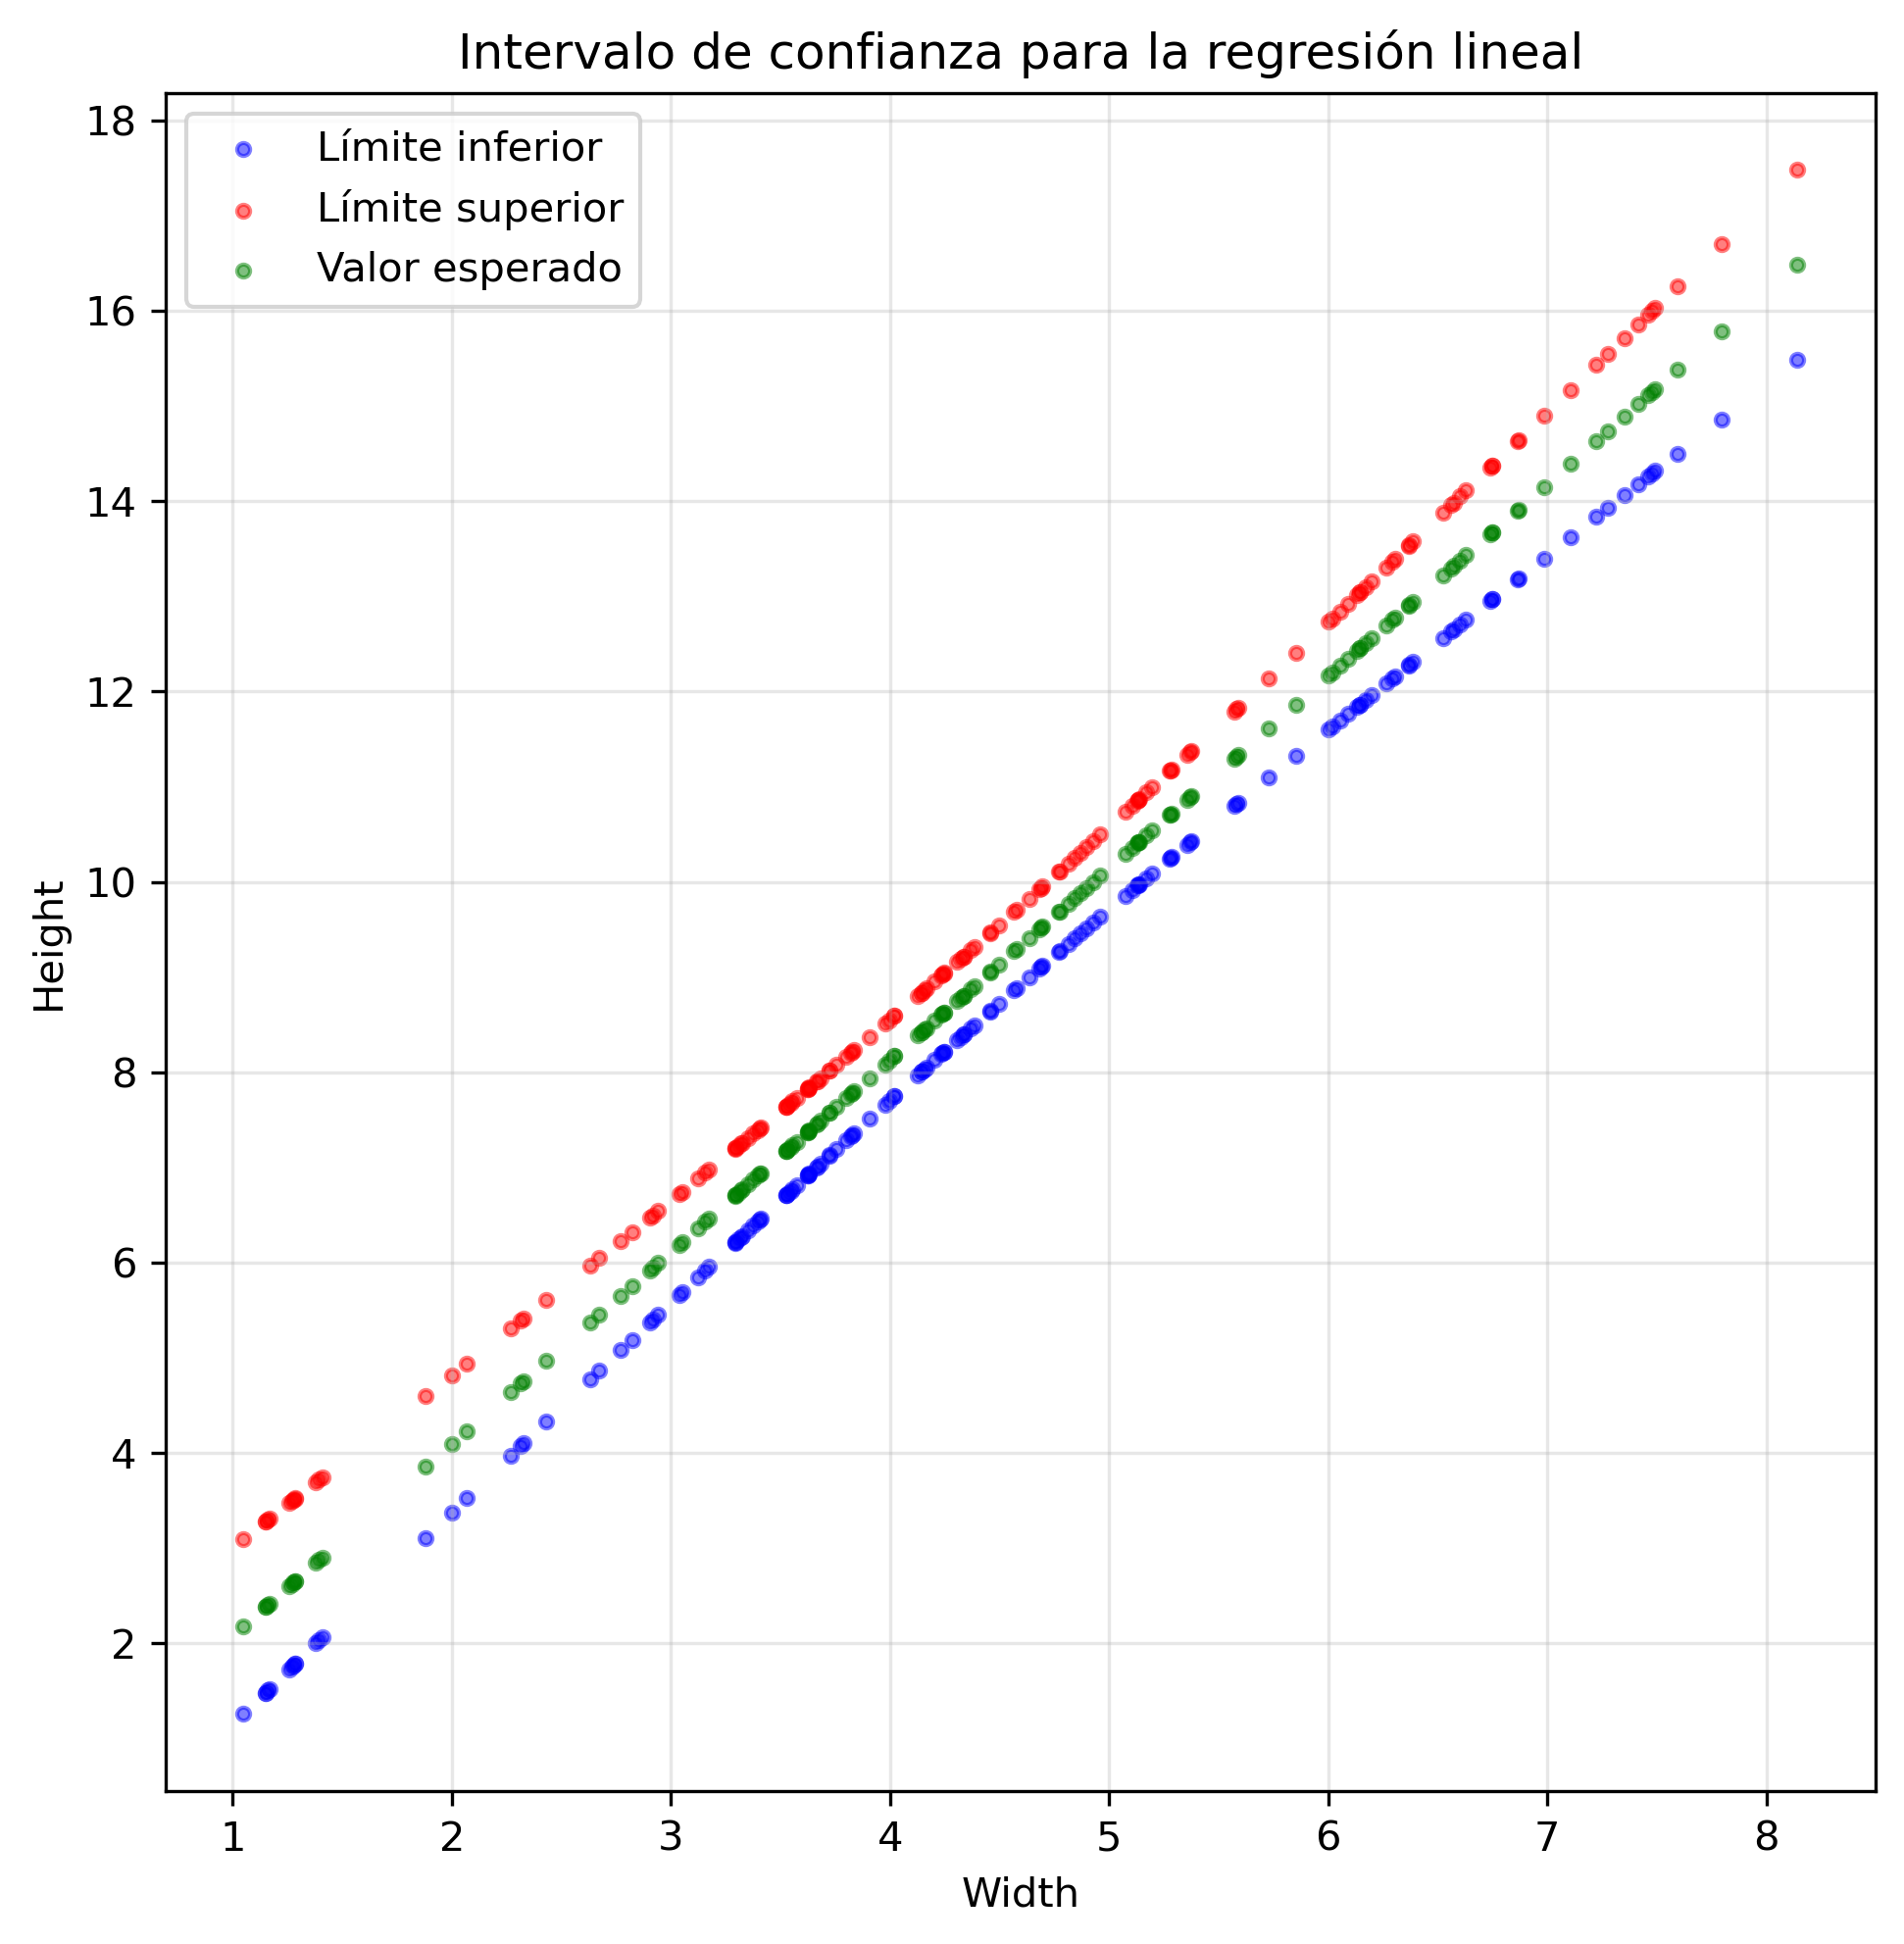

In [13]:
def uncertain_regresion(beta_0, beta_1, x_0, xbar, sigma_2, n, S_xx, alpha):
    """
    Función que calcula el intervalo de confianza para la regresión lineal
    beta_0: intersección de la recta de regresión
    beta_1: pendiente de la recta de regresión
    x_0: valor de x para el que se quiere calcular el intervalo de confianza
    sigma_2: varianza del error
    n: número de observaciones
    S_xx: suma de cuadrados de X
    alpha: nivel de significancia
    """
    mu_y_x0 = beta_0 + beta_1*x_0 # valor esperado de y dado x_0
    t_alpha_2 = stats.t.ppf(1 - alpha/2, n - 2) # valor crítico de t
    var = sigma_2 * (1/n + (x_0 - xbar)**2/S_xx) # varianza del error
    Upper = mu_y_x0 + t_alpha_2 * np.sqrt(var) # límite superior del intervalo de confianza
    Lower = mu_y_x0 - t_alpha_2 * np.sqrt(var) # límite inferior del intervalo de confianza
    return Lower, Upper # retornamos el intervalo de confianza

# ahora calculamos el intervalo de confianza para la regresión
alpha = 0.05
x_0 = width 
xbar = np.mean(width) # media de x
sigma_2 = hat_sigma_2 # varianza del error
n = len(width) # número de observaciones
S_xx = np.sum((width - np.mean(width))**2) # suma de cuadrados de X
beta_0 = hat_beta_0 # intersección de la recta de regresión
beta_1 = hat_beta_1 # pendiente de la recta de regresión
Lower, Upper = uncertain_regresion(beta_0, beta_1, x_0, xbar, sigma_2, n, S_xx, alpha) # calculamos el intervalo de confianza

fig, ax = plt.subplots(1,figsize=(7.5, 7.5), dpi = 300, sharey=True)

### propia
for i in range(len(x_0)):
    # ax.plot([x_0[i], x_0[i]], [Lower[i], Upper[i]], color = 'black', alpha = 0.5, linewidth = 2)
    ax.scatter(x_0[i], Lower[i], color = 'blue', alpha = 0.5, label = 'Límite inferior', s = 10)
    ax.scatter(x_0[i], Upper[i], color = 'red', alpha = 0.5, label = 'Límite superior', s = 10)
    ax.scatter(x_0[i], beta_0 + beta_1*x_0[i], color = 'green', alpha = 0.5, label = 'Valor esperado', s = 10)

# legend of only a few

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc = 'upper left')
ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.set_title('Intervalo de confianza para la regresión lineal')
ax.grid(alpha = 0.3)
plt.show()

Y de la misma forma, se puede realizar una estiamción de la incertidumbre en una nueva predicción del modelo. Lo que nos permite realizar desiciones informadas en la incertidumbre de los datos.

En este caso, lam varianza viene dada por:

$$
\mathbb{Var}(Y_0 - \widehat{Y}_0) =  \sigma^2 \left[ 1 + \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]
$$
La cual viene dada por el error de estimación. Luego, definimos nuestro intervalo de confianza mediante el siguiente valor:

$$
\frac{Y_0 - \widehat{Y}_0}{ \sqrt{ \sigma^2 \left[ 1 + \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]}}
$$

La cual viene dada por una distribución $t$ con $n-2$ grados de libertad. Así, los intervalos de confianza $(100 - \alpha)\%$ para una nueva predicción vienen dados por:

$$
\widehat{y}_0 - t_{\alpha/2, n-2} \sqrt{ \sigma^2 \left[ 1 + \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]} \le Y_0 \le \widehat{y}_0 + t_{\alpha/2, n-2} \sqrt{ \sigma^2 \left[ 1 + \frac{1}{n} + \frac{(x_0 -\overline{x})^2}{S_{xx}}  \right]}
$$

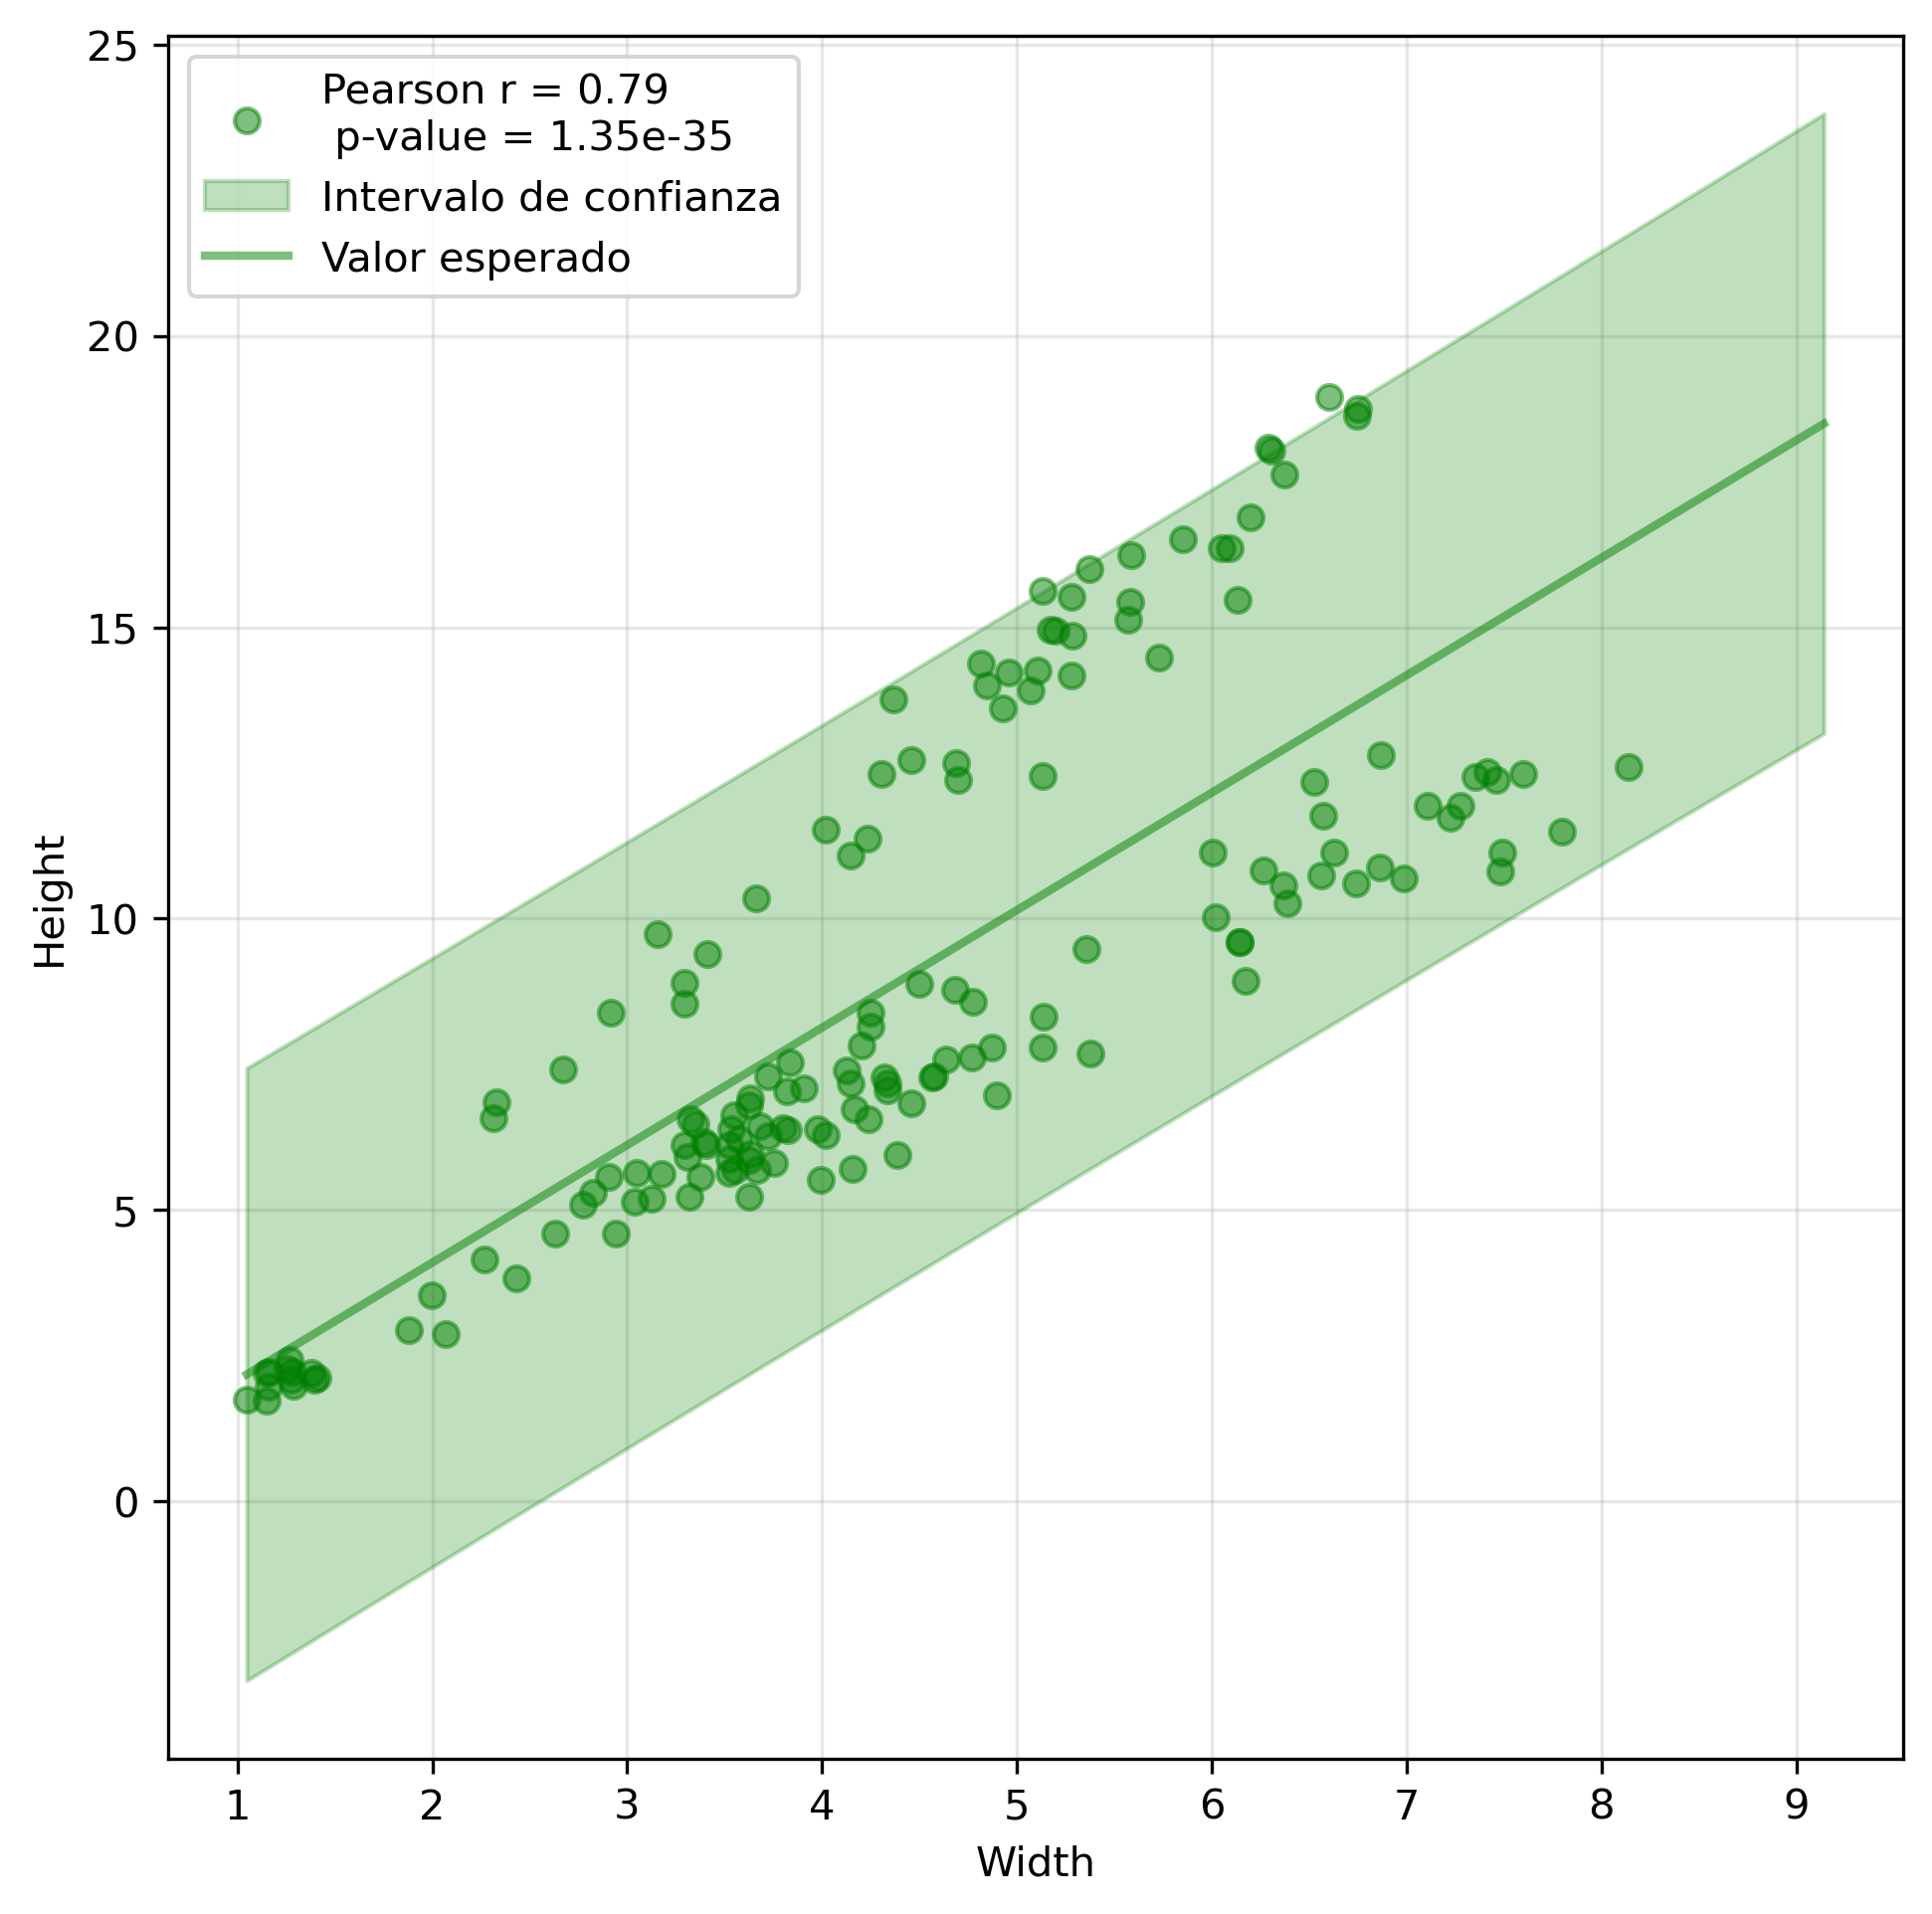

In [14]:
def uncertain_new_value(beta_0, beta_1, x_0, xbar, sigma_2, n, S_xx, alpha):
    """
    Función que calcula el intervalo de confianza para la regresión lineal
    beta_0: intersección de la recta de regresión
    beta_1: pendiente de la recta de regresión
    x_0: valor de x para el que se quiere calcular el intervalo de confianza
    sigma_2: varianza del error
    n: número de observaciones
    S_xx: suma de cuadrados de X
    alpha: nivel de significancia
    """
    mu_y_x0 = beta_0 + beta_1*x_0 # valor esperado de y dado x_0
    t_alpha_2 = stats.t.ppf(1 - alpha/2, n - 2) # valor crítico de t
    var = sigma_2 * (1 + 1/n + (x_0 - xbar)**2/S_xx) # varianza del error
    Upper = mu_y_x0 + t_alpha_2 * np.sqrt(var) # límite superior del intervalo de confianza
    Lower = mu_y_x0 - t_alpha_2 * np.sqrt(var) # límite inferior del intervalo de confianza
    return Lower, Upper # retornamos el intervalo de confianza

## calculamos

alpha = 0.05
x_0 = np.linspace(width.min(), width.max()+1, 100) # valores de x para los que se quiere calcular el intervalo de confianza
xbar = np.mean(width) # media de x
sigma_2 = hat_sigma_2 # varianza del error
n = len(width) # número de observaciones
S_xx = np.sum((width - np.mean(width))**2) # suma de cuadrados de X
beta_0 = hat_beta_0 # intersección de la recta de regresión
beta_1 = hat_beta_1 # pendiente de la recta de regresión
Lower, Upper = uncertain_new_value(beta_0, beta_1, x_0, xbar, sigma_2, n, S_xx, alpha) # calculamos el intervalo de confianza
fig, ax = plt.subplots(1,figsize=(7.5, 7.5), dpi = 300)
ax.scatter(width, height, alpha=0.5, color = 'green',
           label = f'Pearson r = {pearson_r:.2f} \n p-value = {pearson_pval:.2e}',zorder = 3)
ax.fill_between(x_0, Lower, Upper, color = 'green', alpha = 0.25, label = 'Intervalo de confianza', zorder = 2)
ax.plot(x_0, beta_0 + beta_1*x_0, color = 'green', alpha = 0.5, label = 'Valor esperado', linewidth = 2)
ax.grid(alpha = 0.3, zorder = 0)
ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.legend(loc = 'upper left')
plt.show()

## Regresión Lineal Python

Repita todo lo anterior utilizando la función [OLS](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html) de la librería `statsmodels`. ¿Coinciden los resultados? Discuta brevemente cualquier diferencia observada.

In [15]:
from statsmodels.api import OLS
modelo_ols = OLS(height, sm.add_constant(width)).fit() # ajustamos el modelo de regresión lineal    
print(modelo_ols.summary()) # imprimimos el resumen del modelo

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     265.8
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.35e-35
Time:                        01:17:55   Log-Likelihood:                -377.76
No. Observations:                 159   AIC:                             759.5
Df Residuals:                     157   BIC:                             765.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0657      0.584      0.112      0.9

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_76880/1851038838.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(width, params[0] + params[1]*width, color = 'green', alpha = 0.5, label = 'Valor esperado', linewidth = 2)


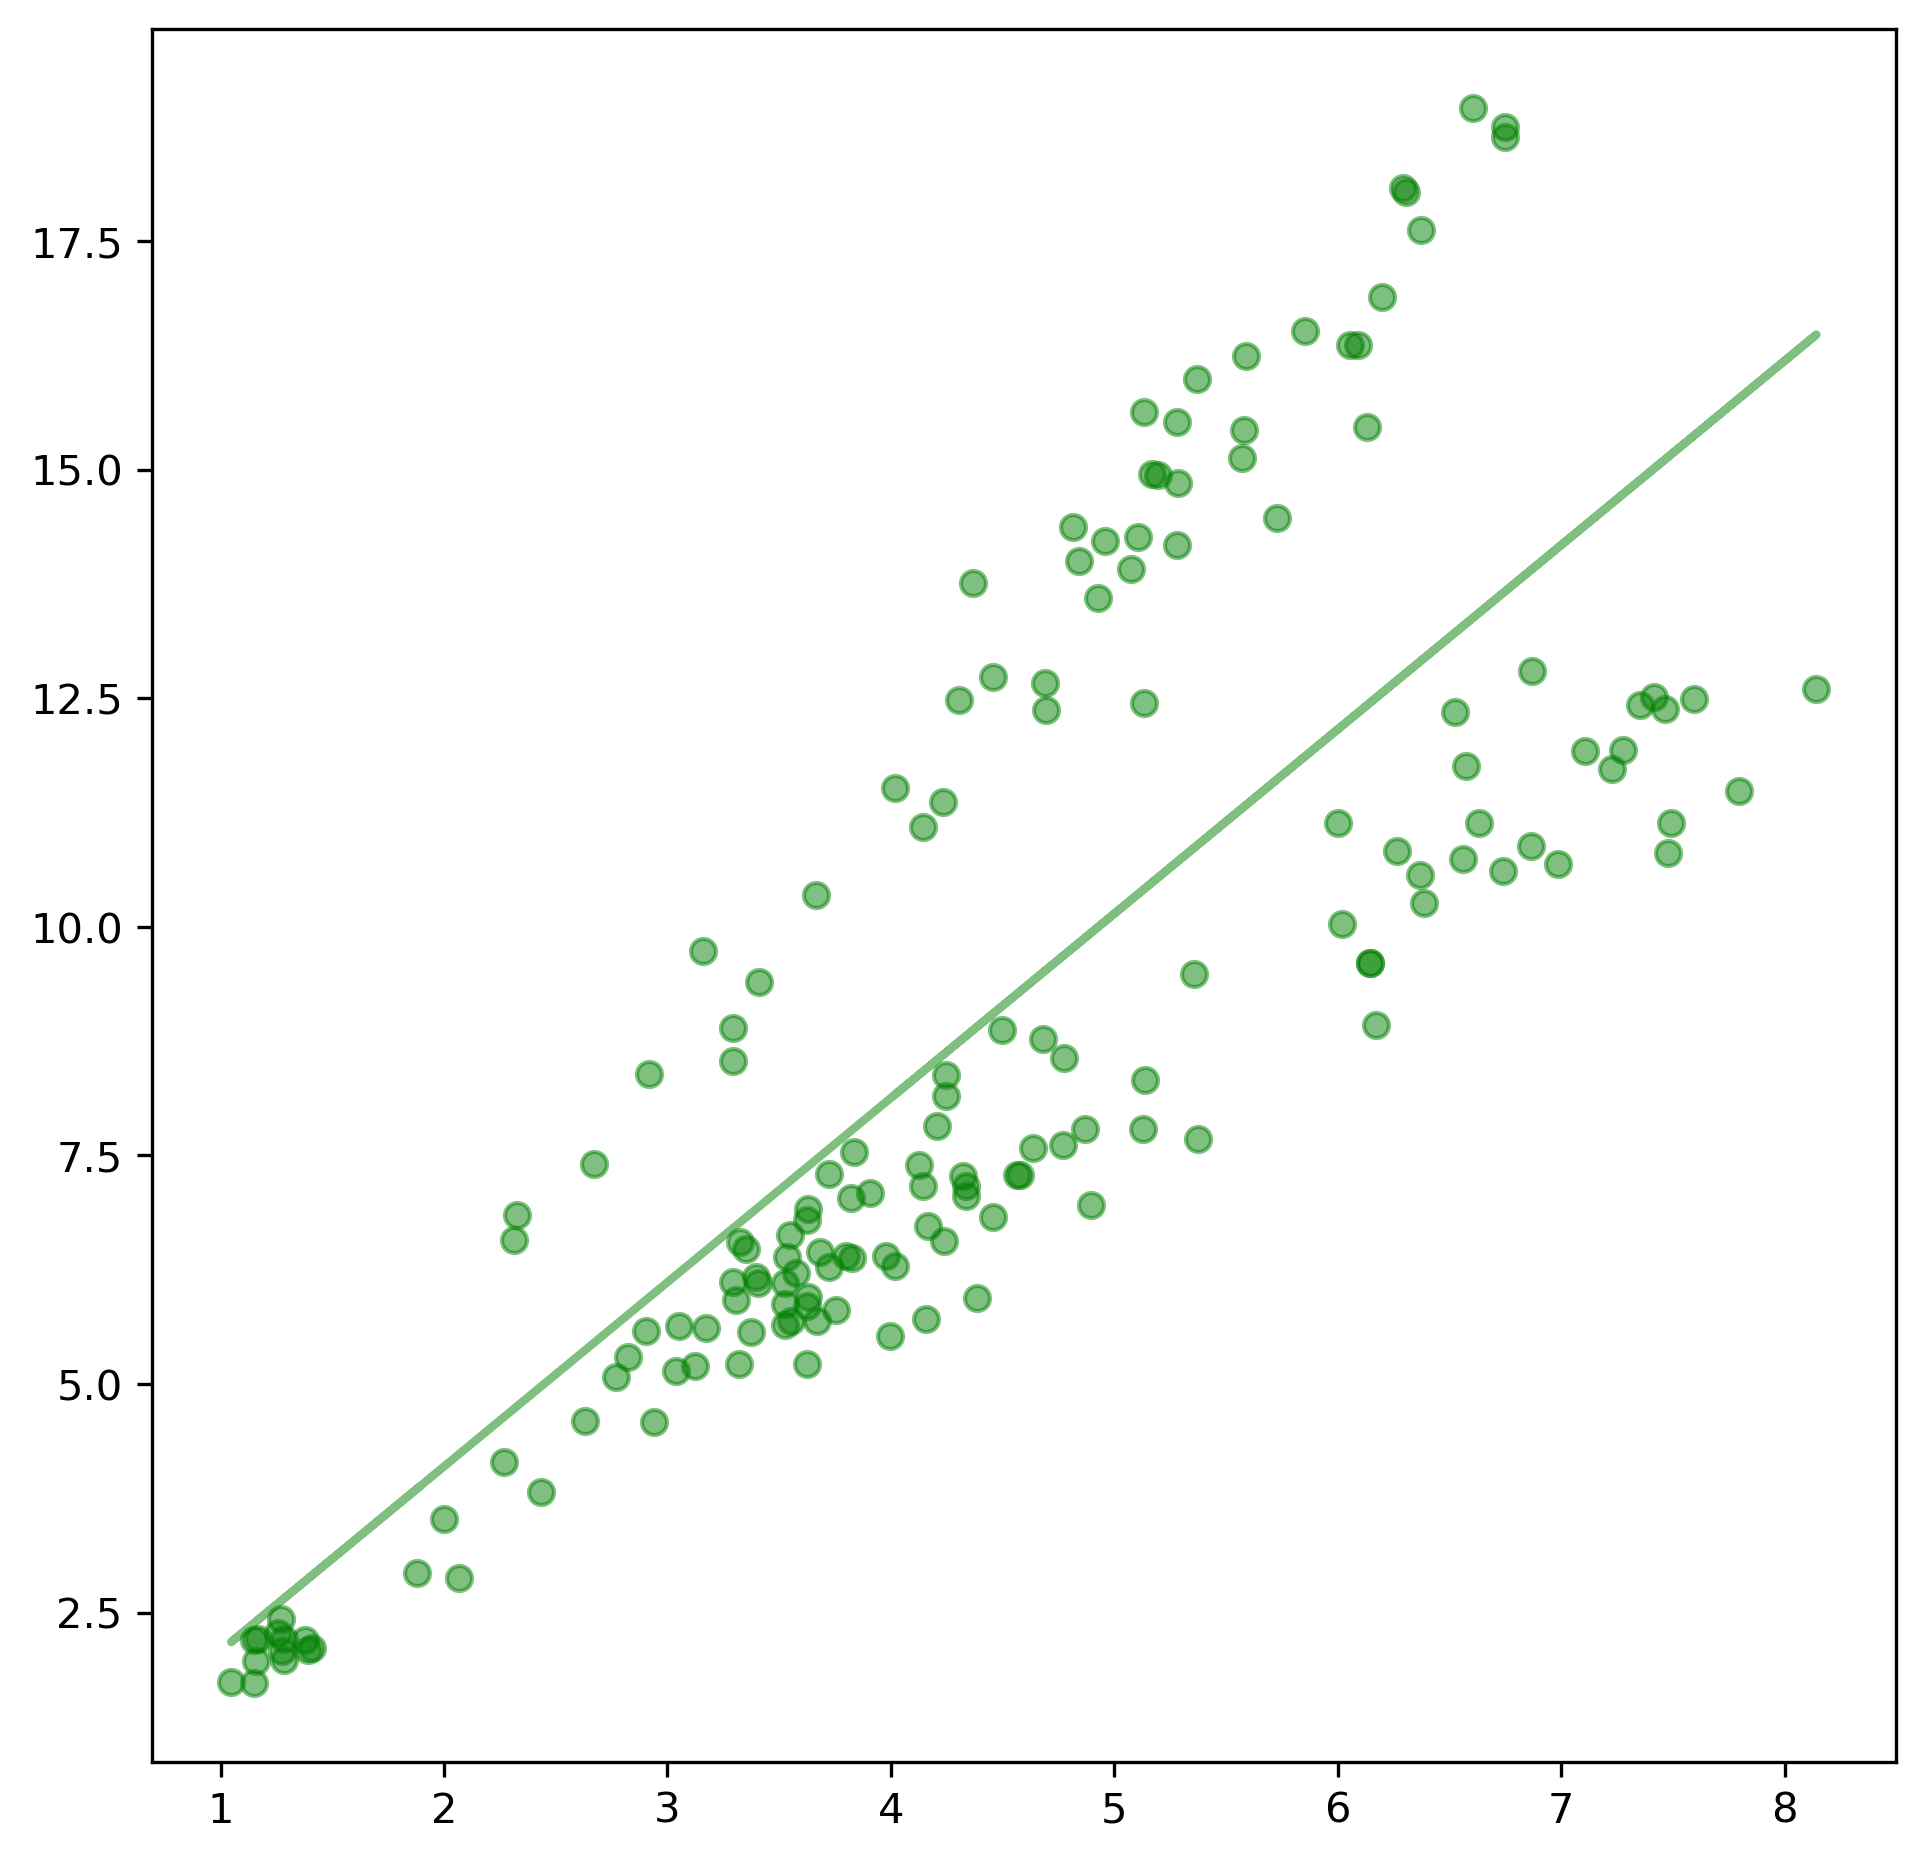

In [16]:
# graficamos
fig, ax = plt.subplots(1,figsize=(7.5, 7.5), dpi = 300)
ax.scatter(width, height, alpha=0.5, color = 'green',
           label = f'Pearson r = {pearson_r:.2f} \n p-value = {pearson_pval:.2e}',zorder = 3)
 ax.plot(width, params[0] + params[1]*width, color = 'green', alpha = 0.5, label = 'Valor esperado', linewidth = 2)

Text(0, 0.5, 'Residuos')

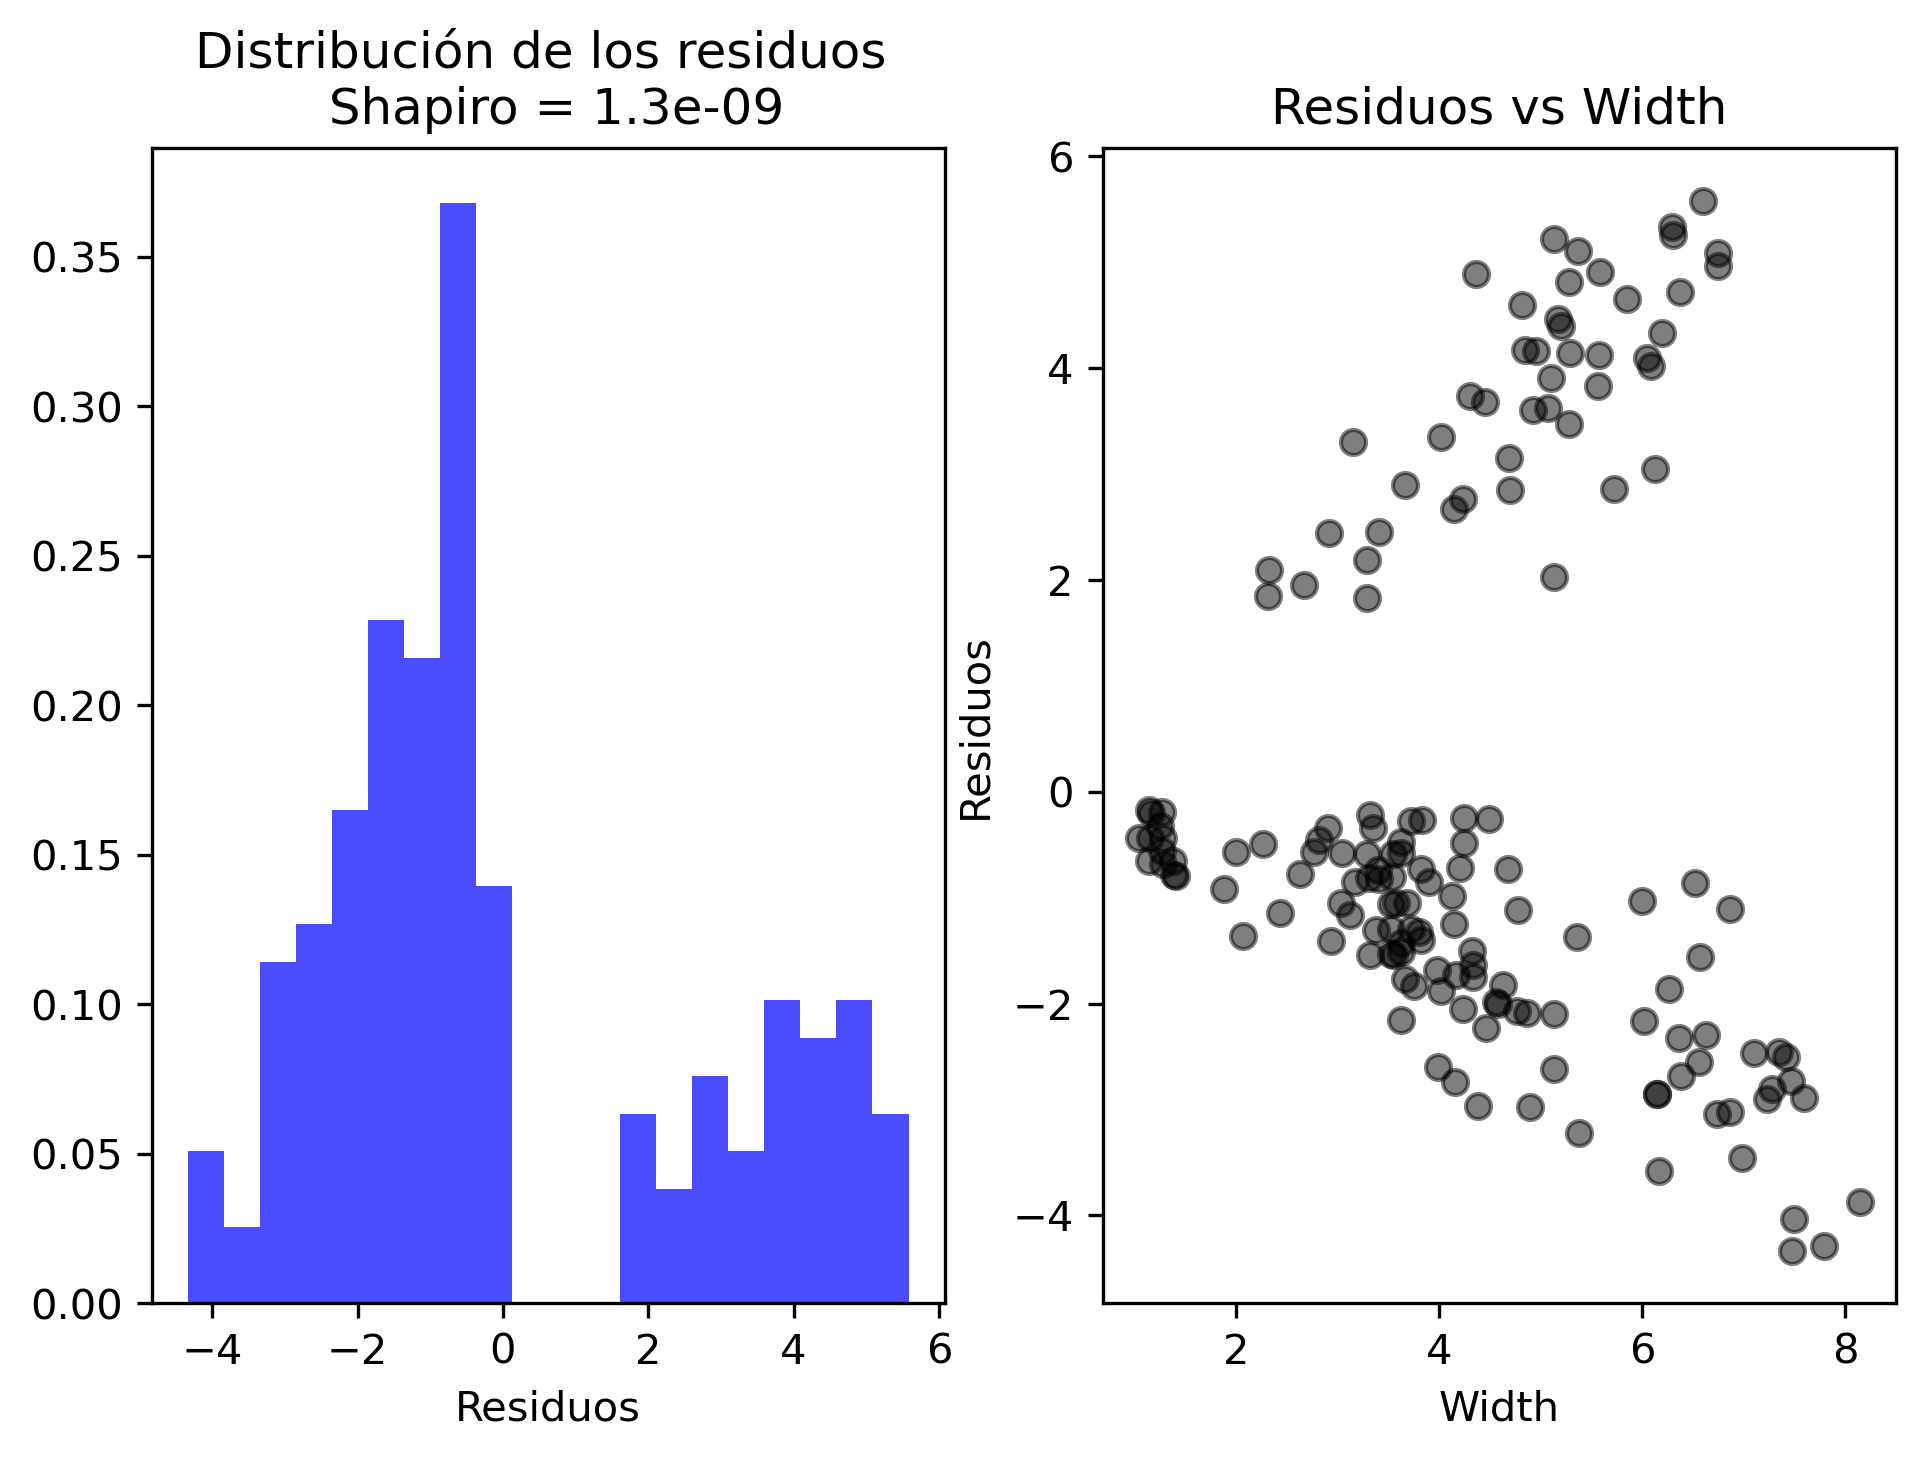

In [59]:
# residuos

residuos = modelo_ols.resid # residuos del modelo
fig, ax = plt.subplots(1,2,figsize=(7.5, 5), dpi = 300)
shapiro = stats.shapiro(residuos)
ax[0].hist(residuos, bins=20, color='blue', alpha=0.7, density=True)
ax[1].scatter(width, residuos, alpha=0.5, color = 'black')
ax[0].set_title(f'Distribución de los residuos \n Shapiro = {shapiro[1]:.1e}')
ax[0].set_xlabel('Residuos')
ax[1].set_title('Residuos vs Width')
ax[1].set_xlabel('Width')
ax[1].set_ylabel('Residuos')

Nos damos que los residuos no son normales. 

**¿Qué podemos hacer?**

Dividamos según tipo de pez y analicemos que pasa.

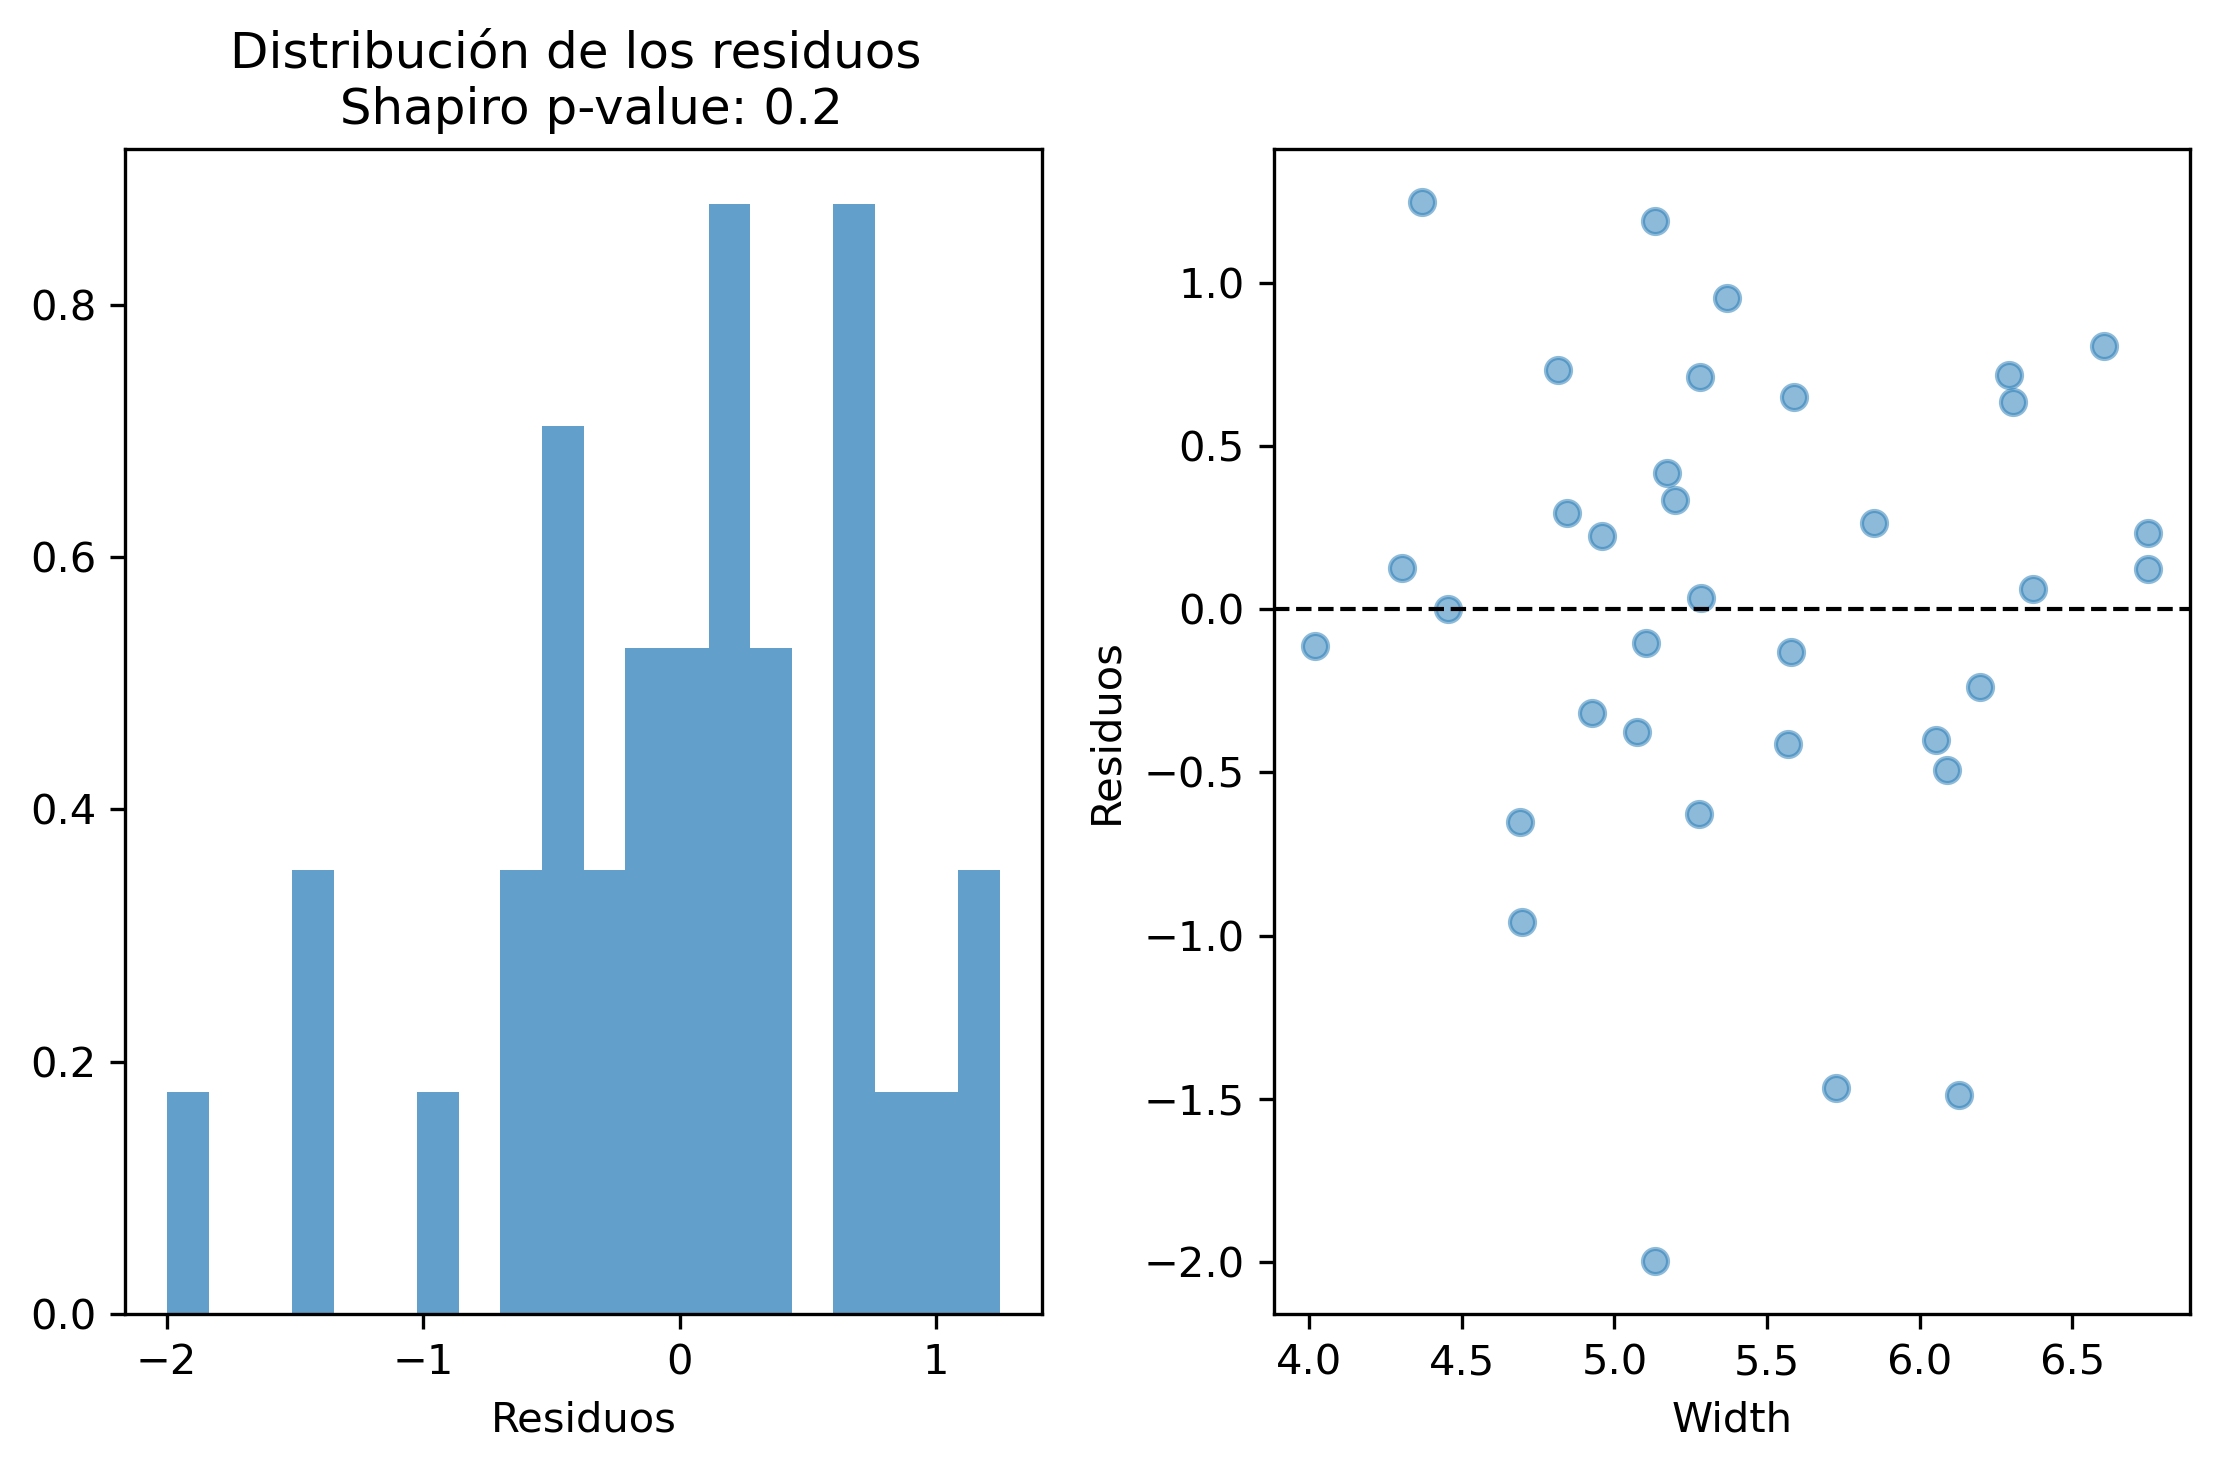

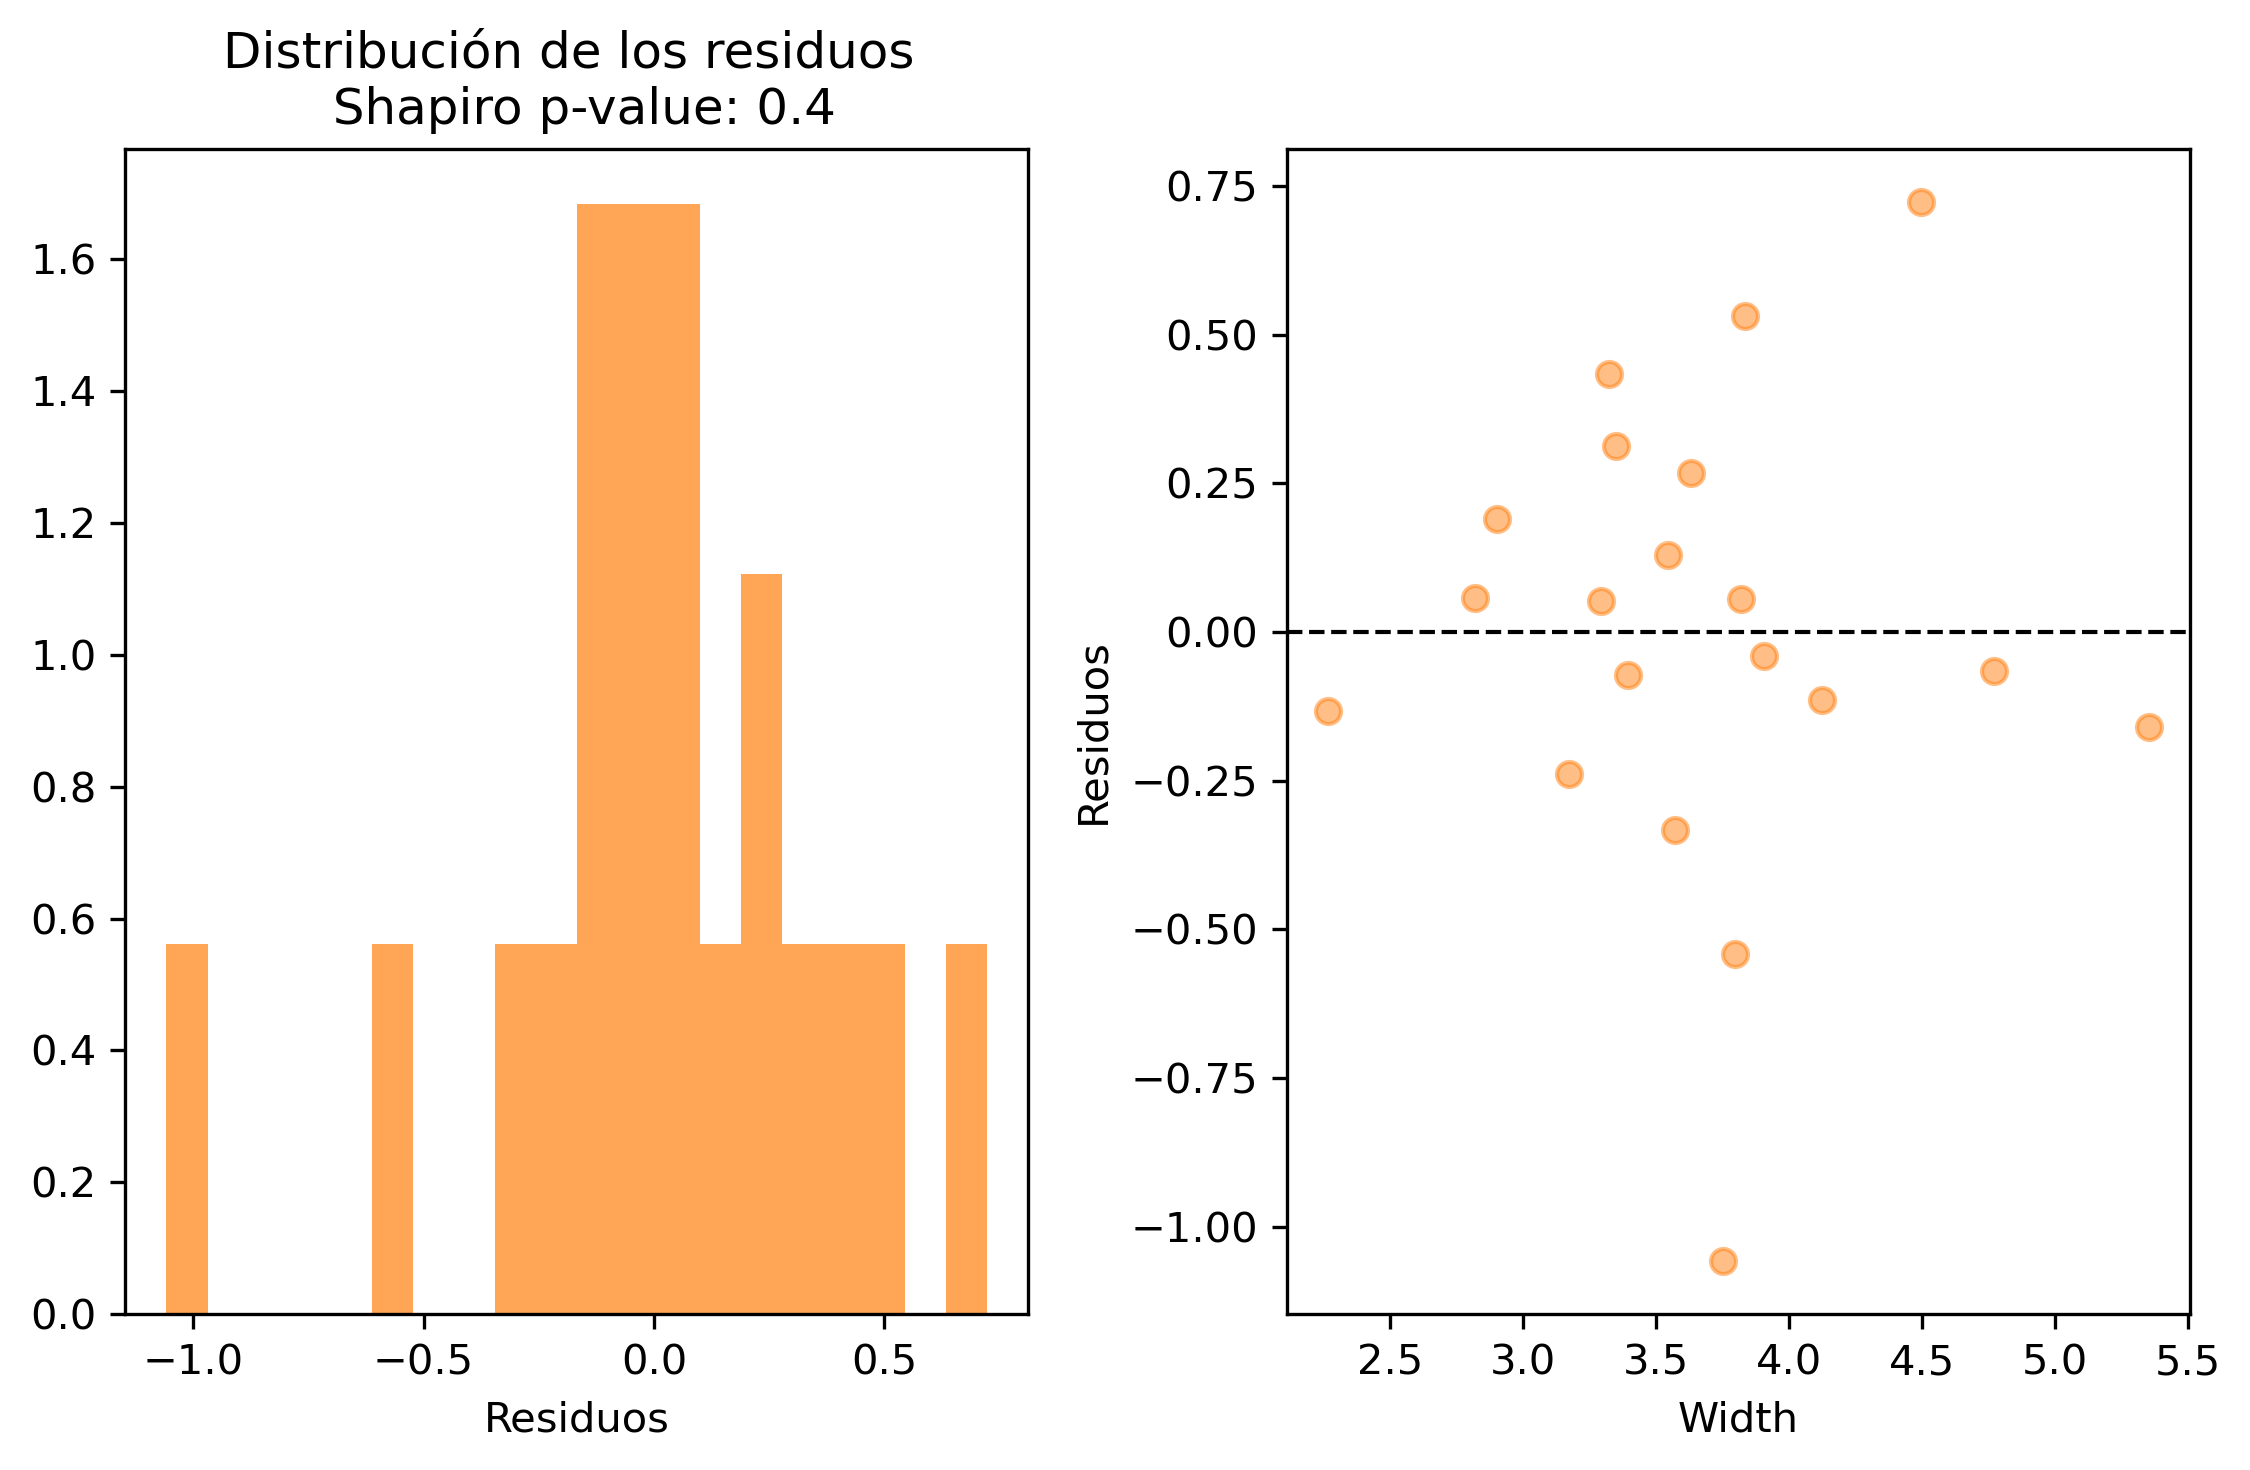

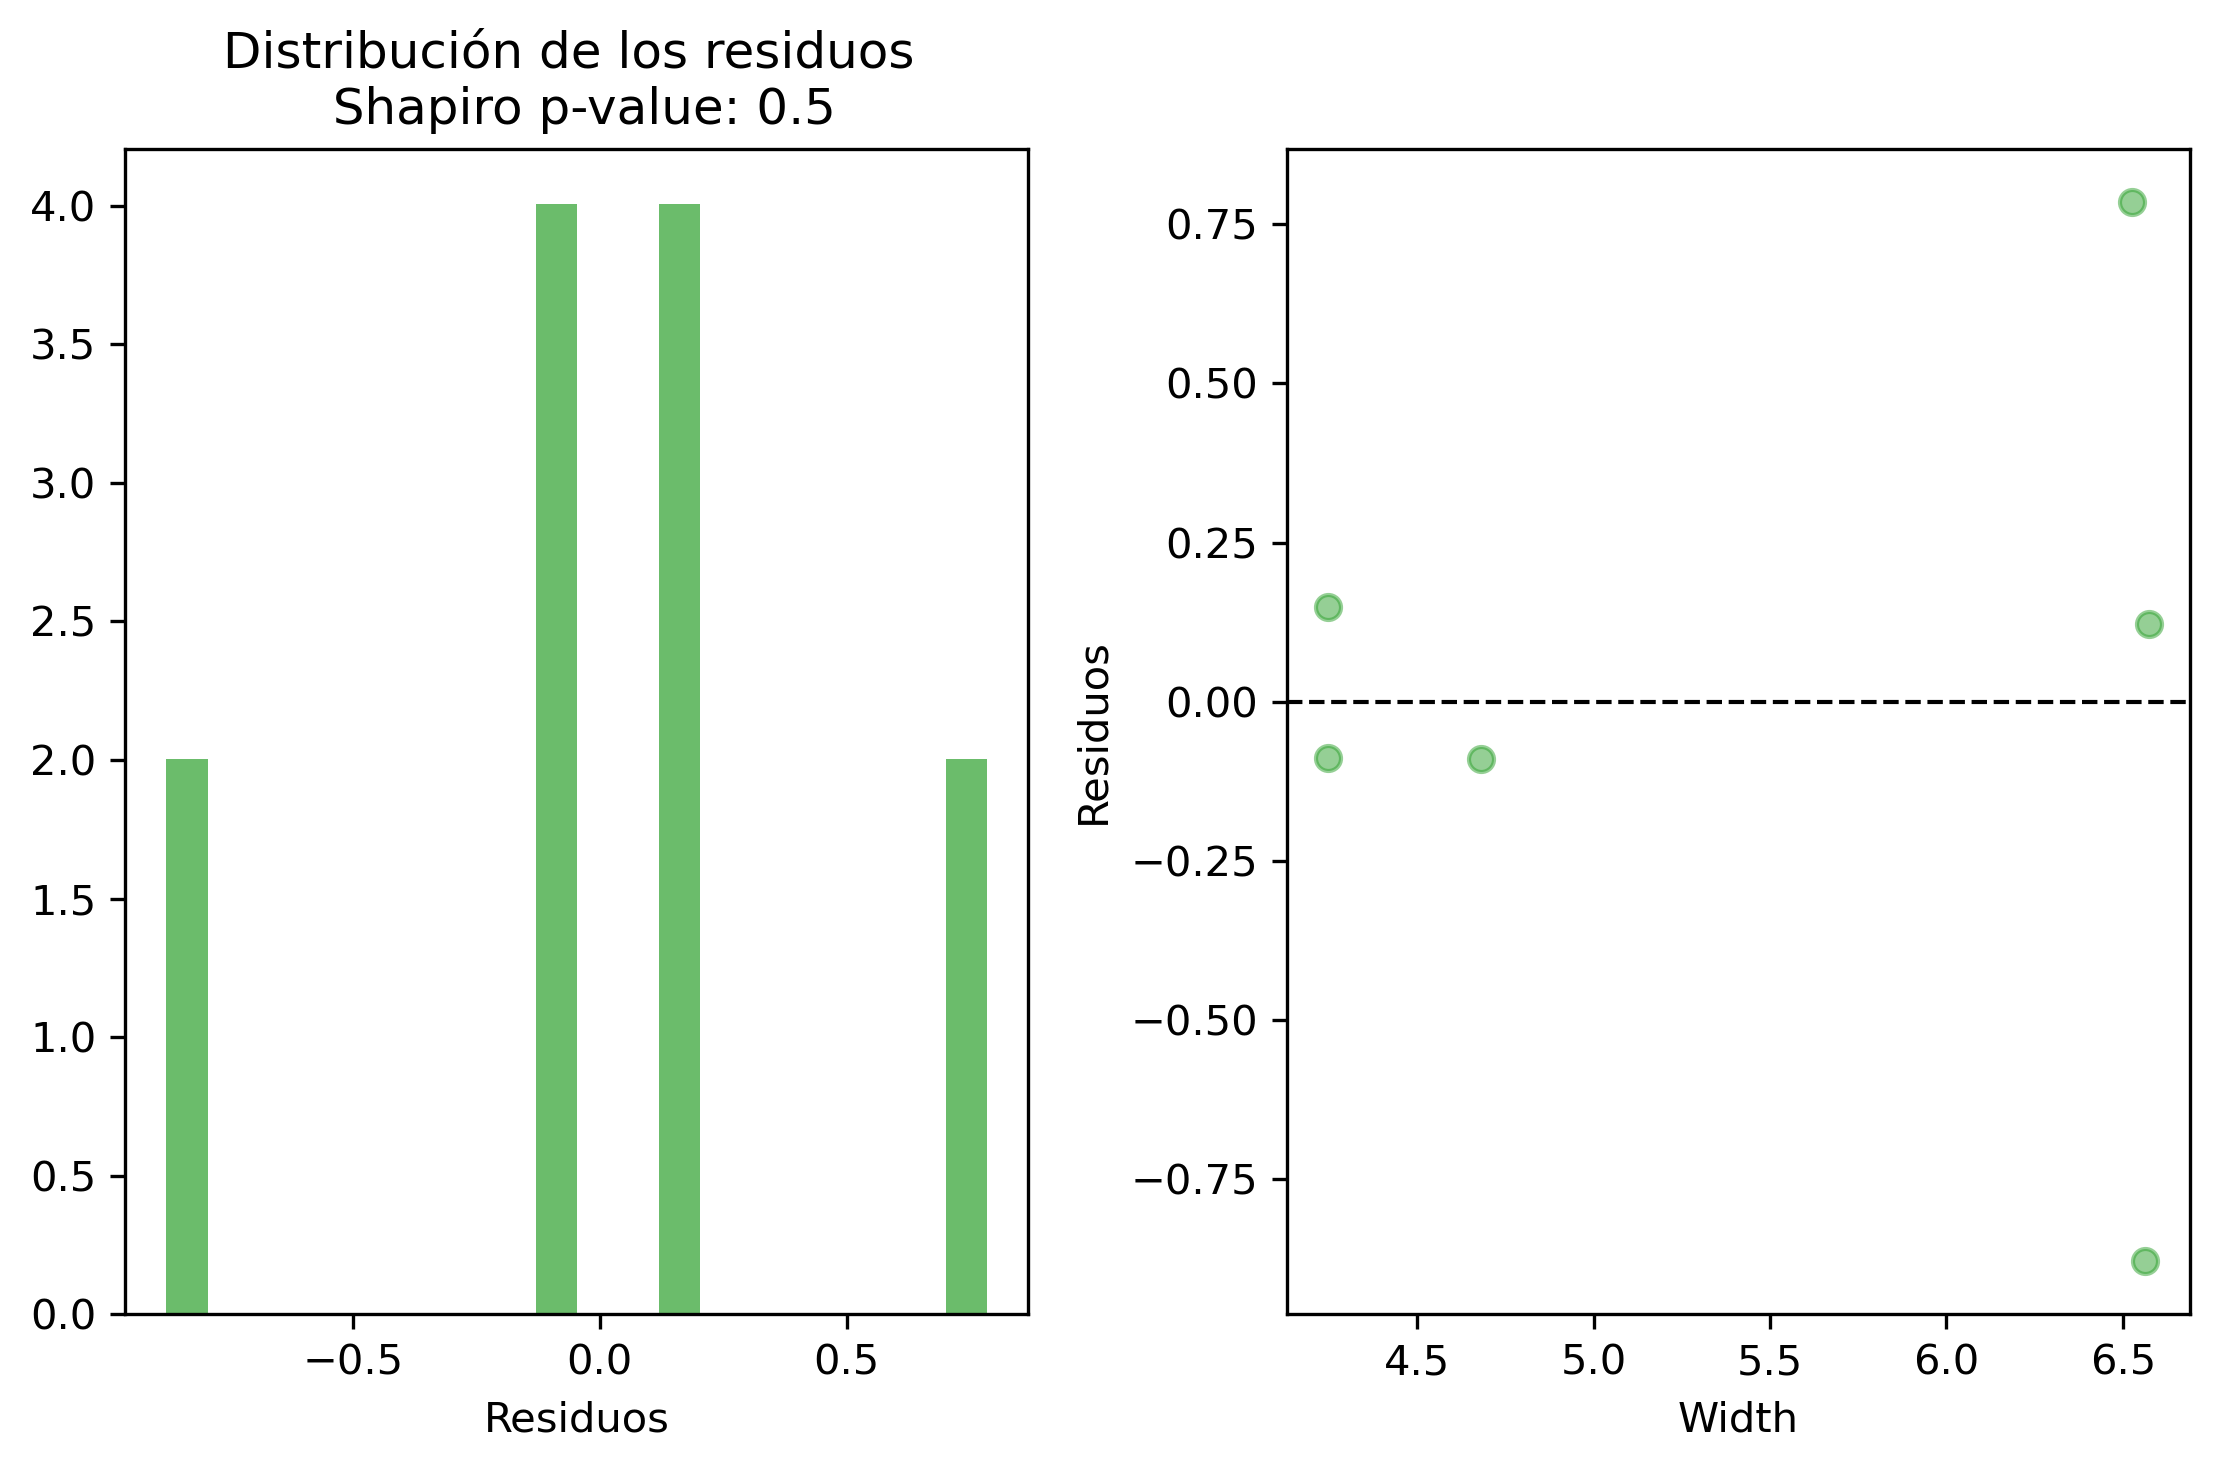

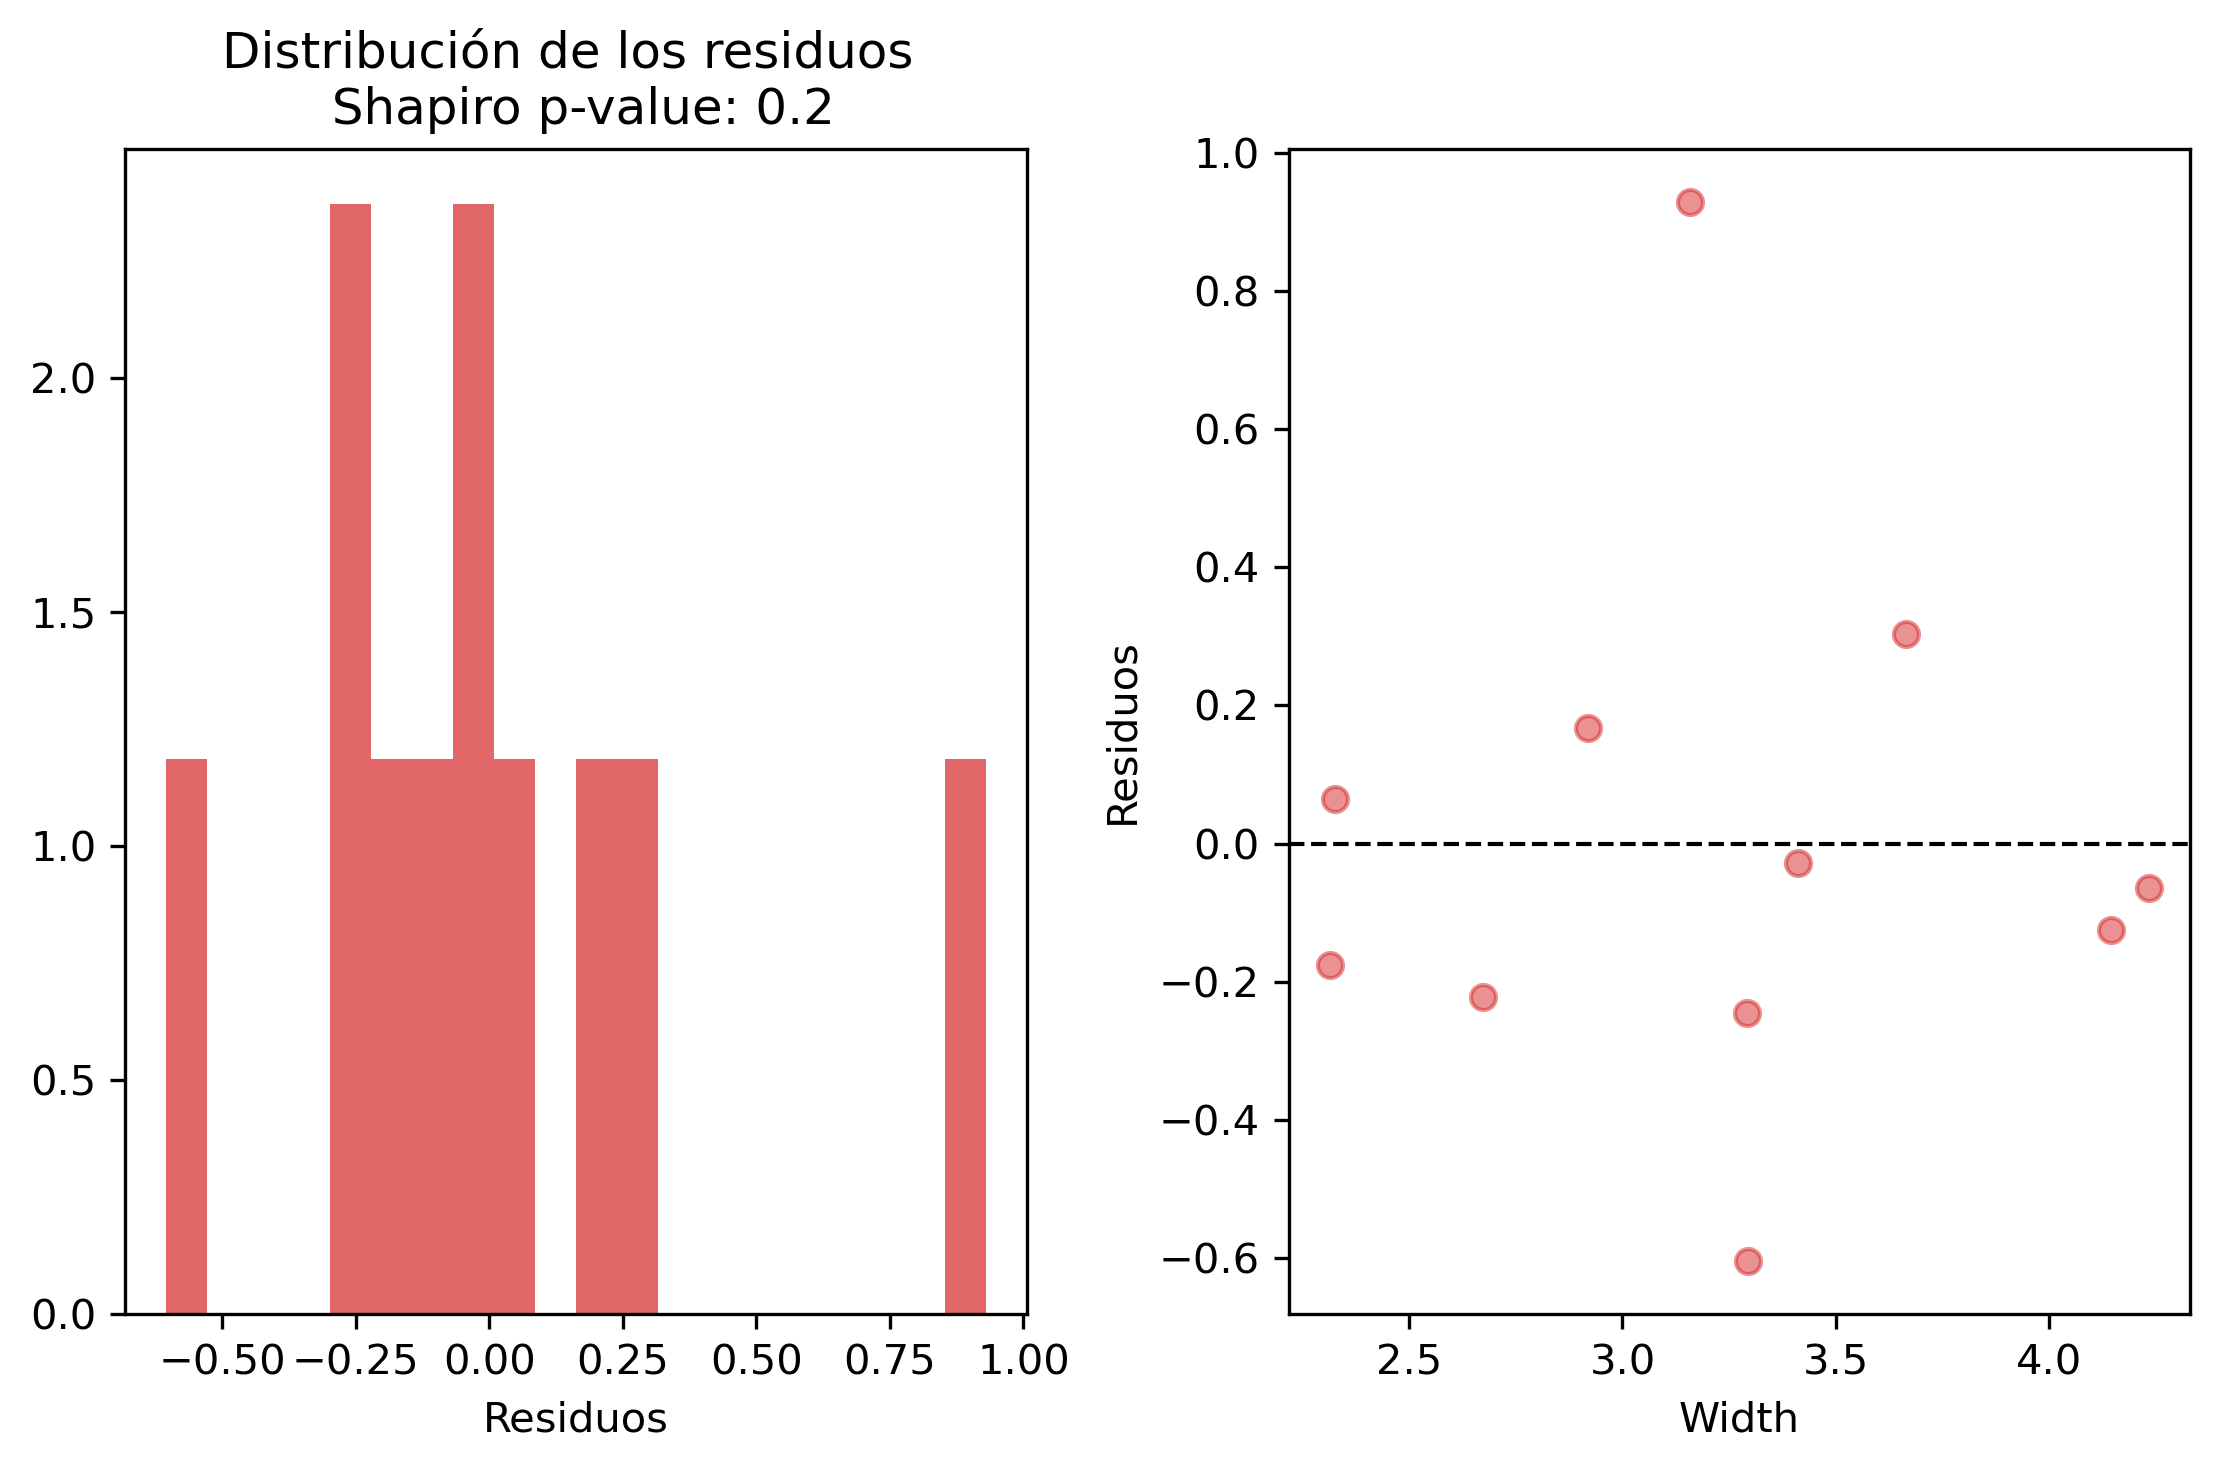

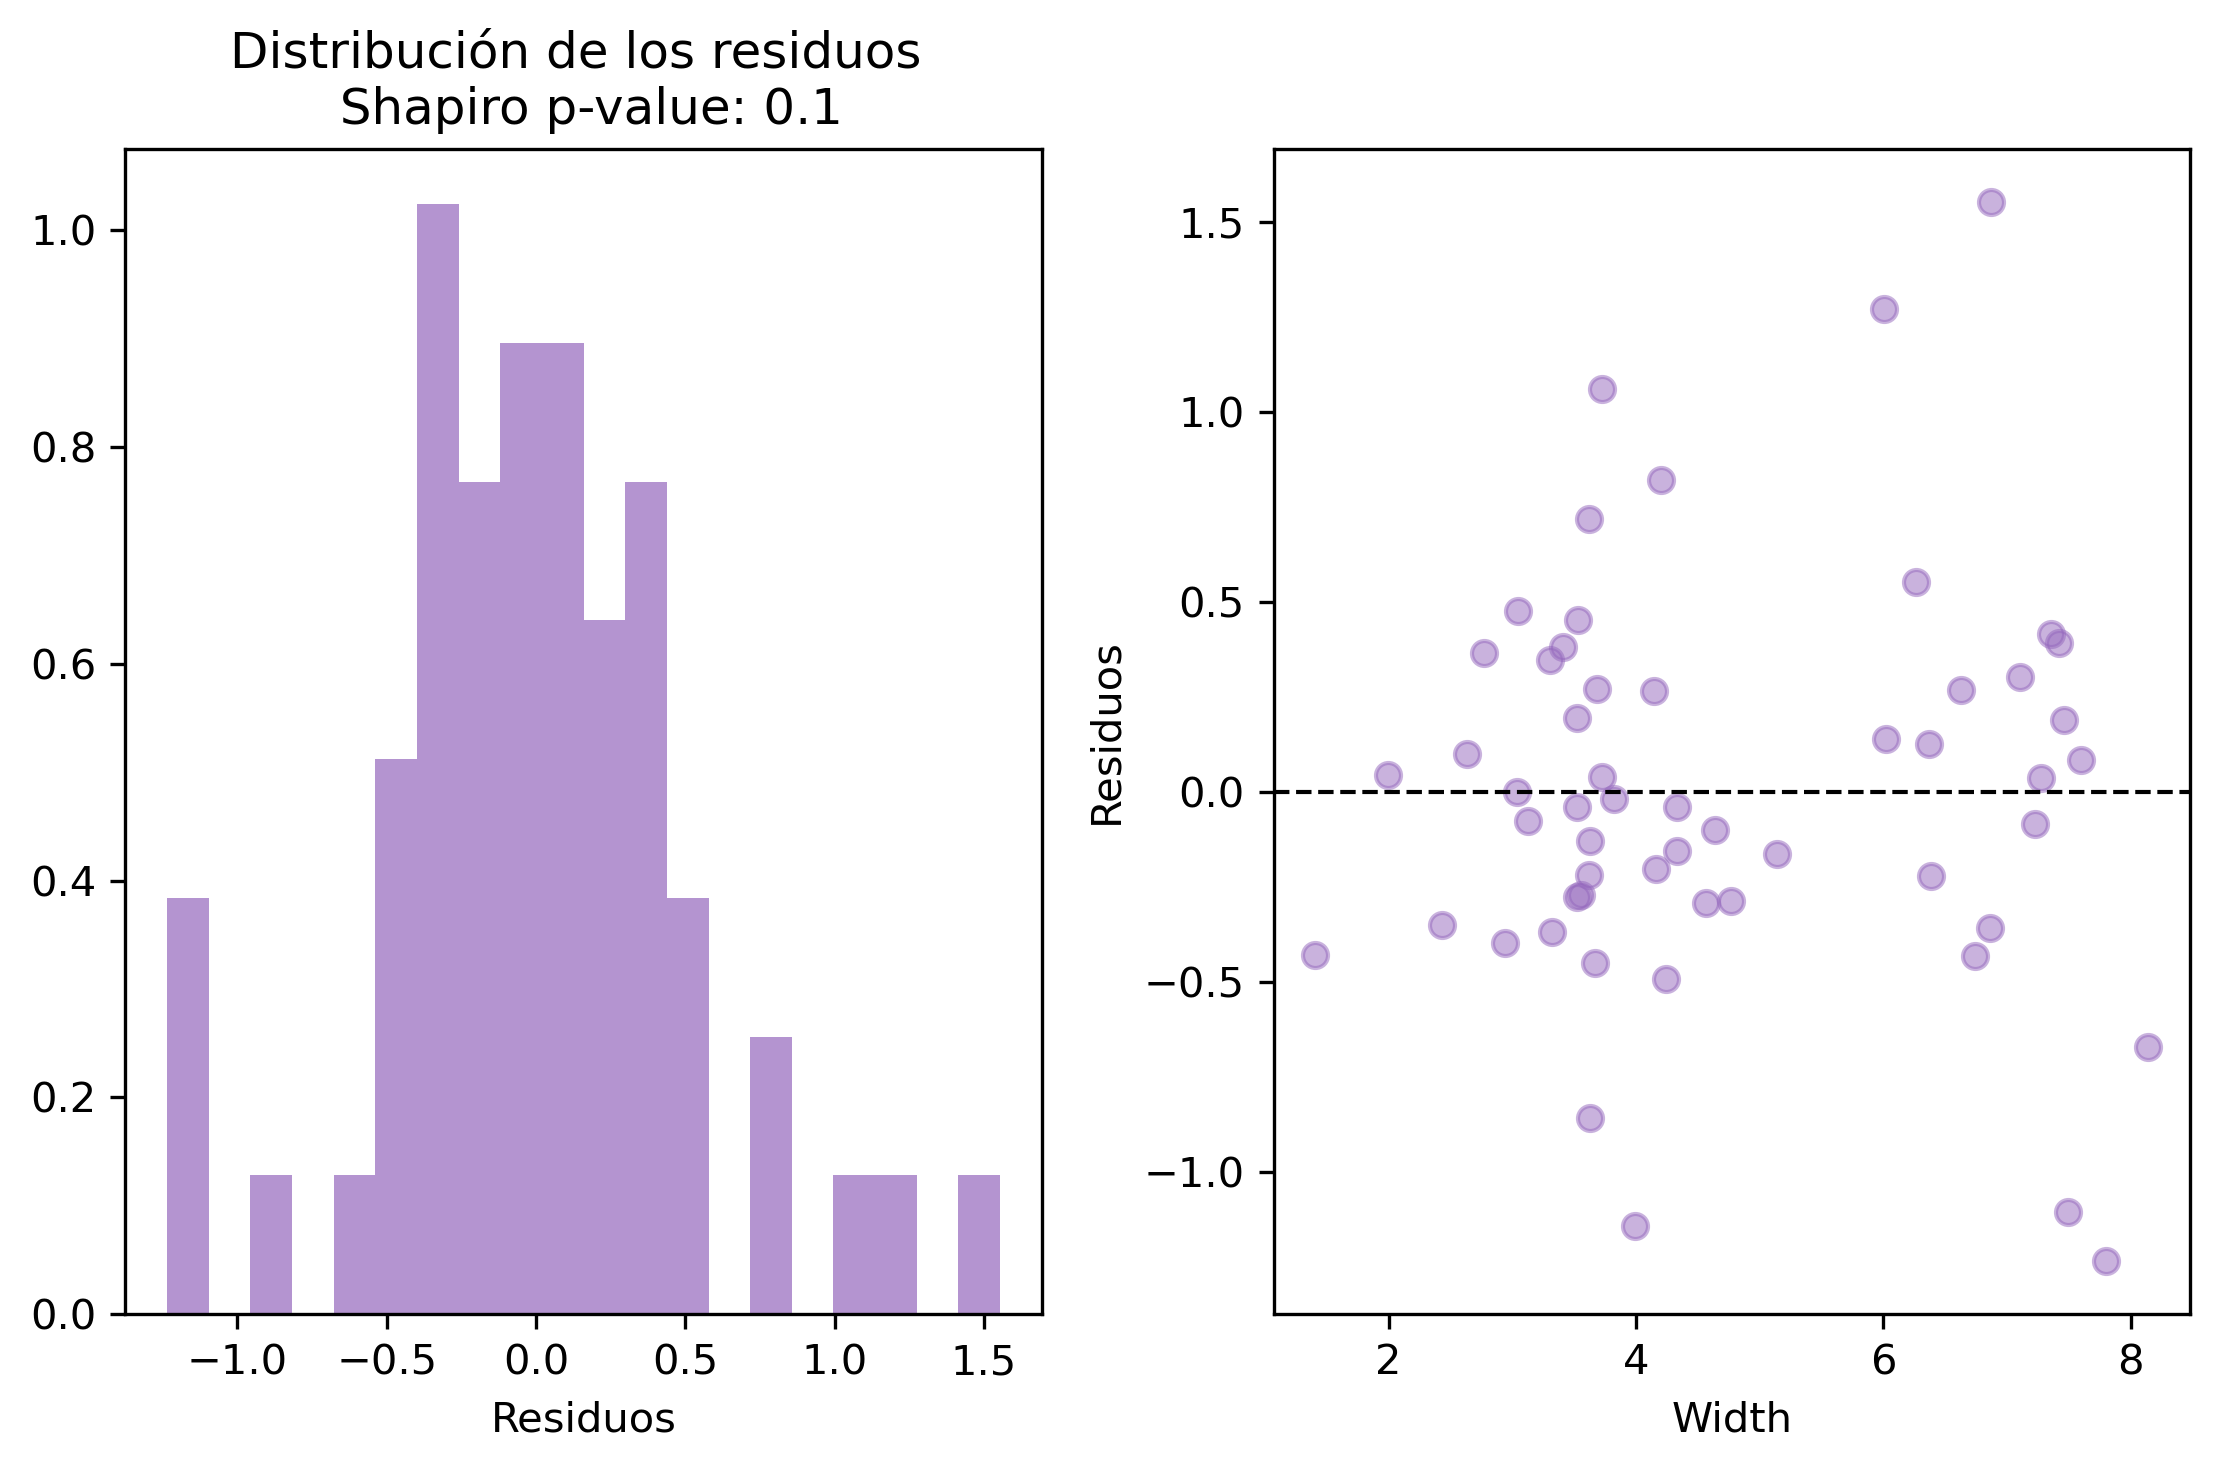

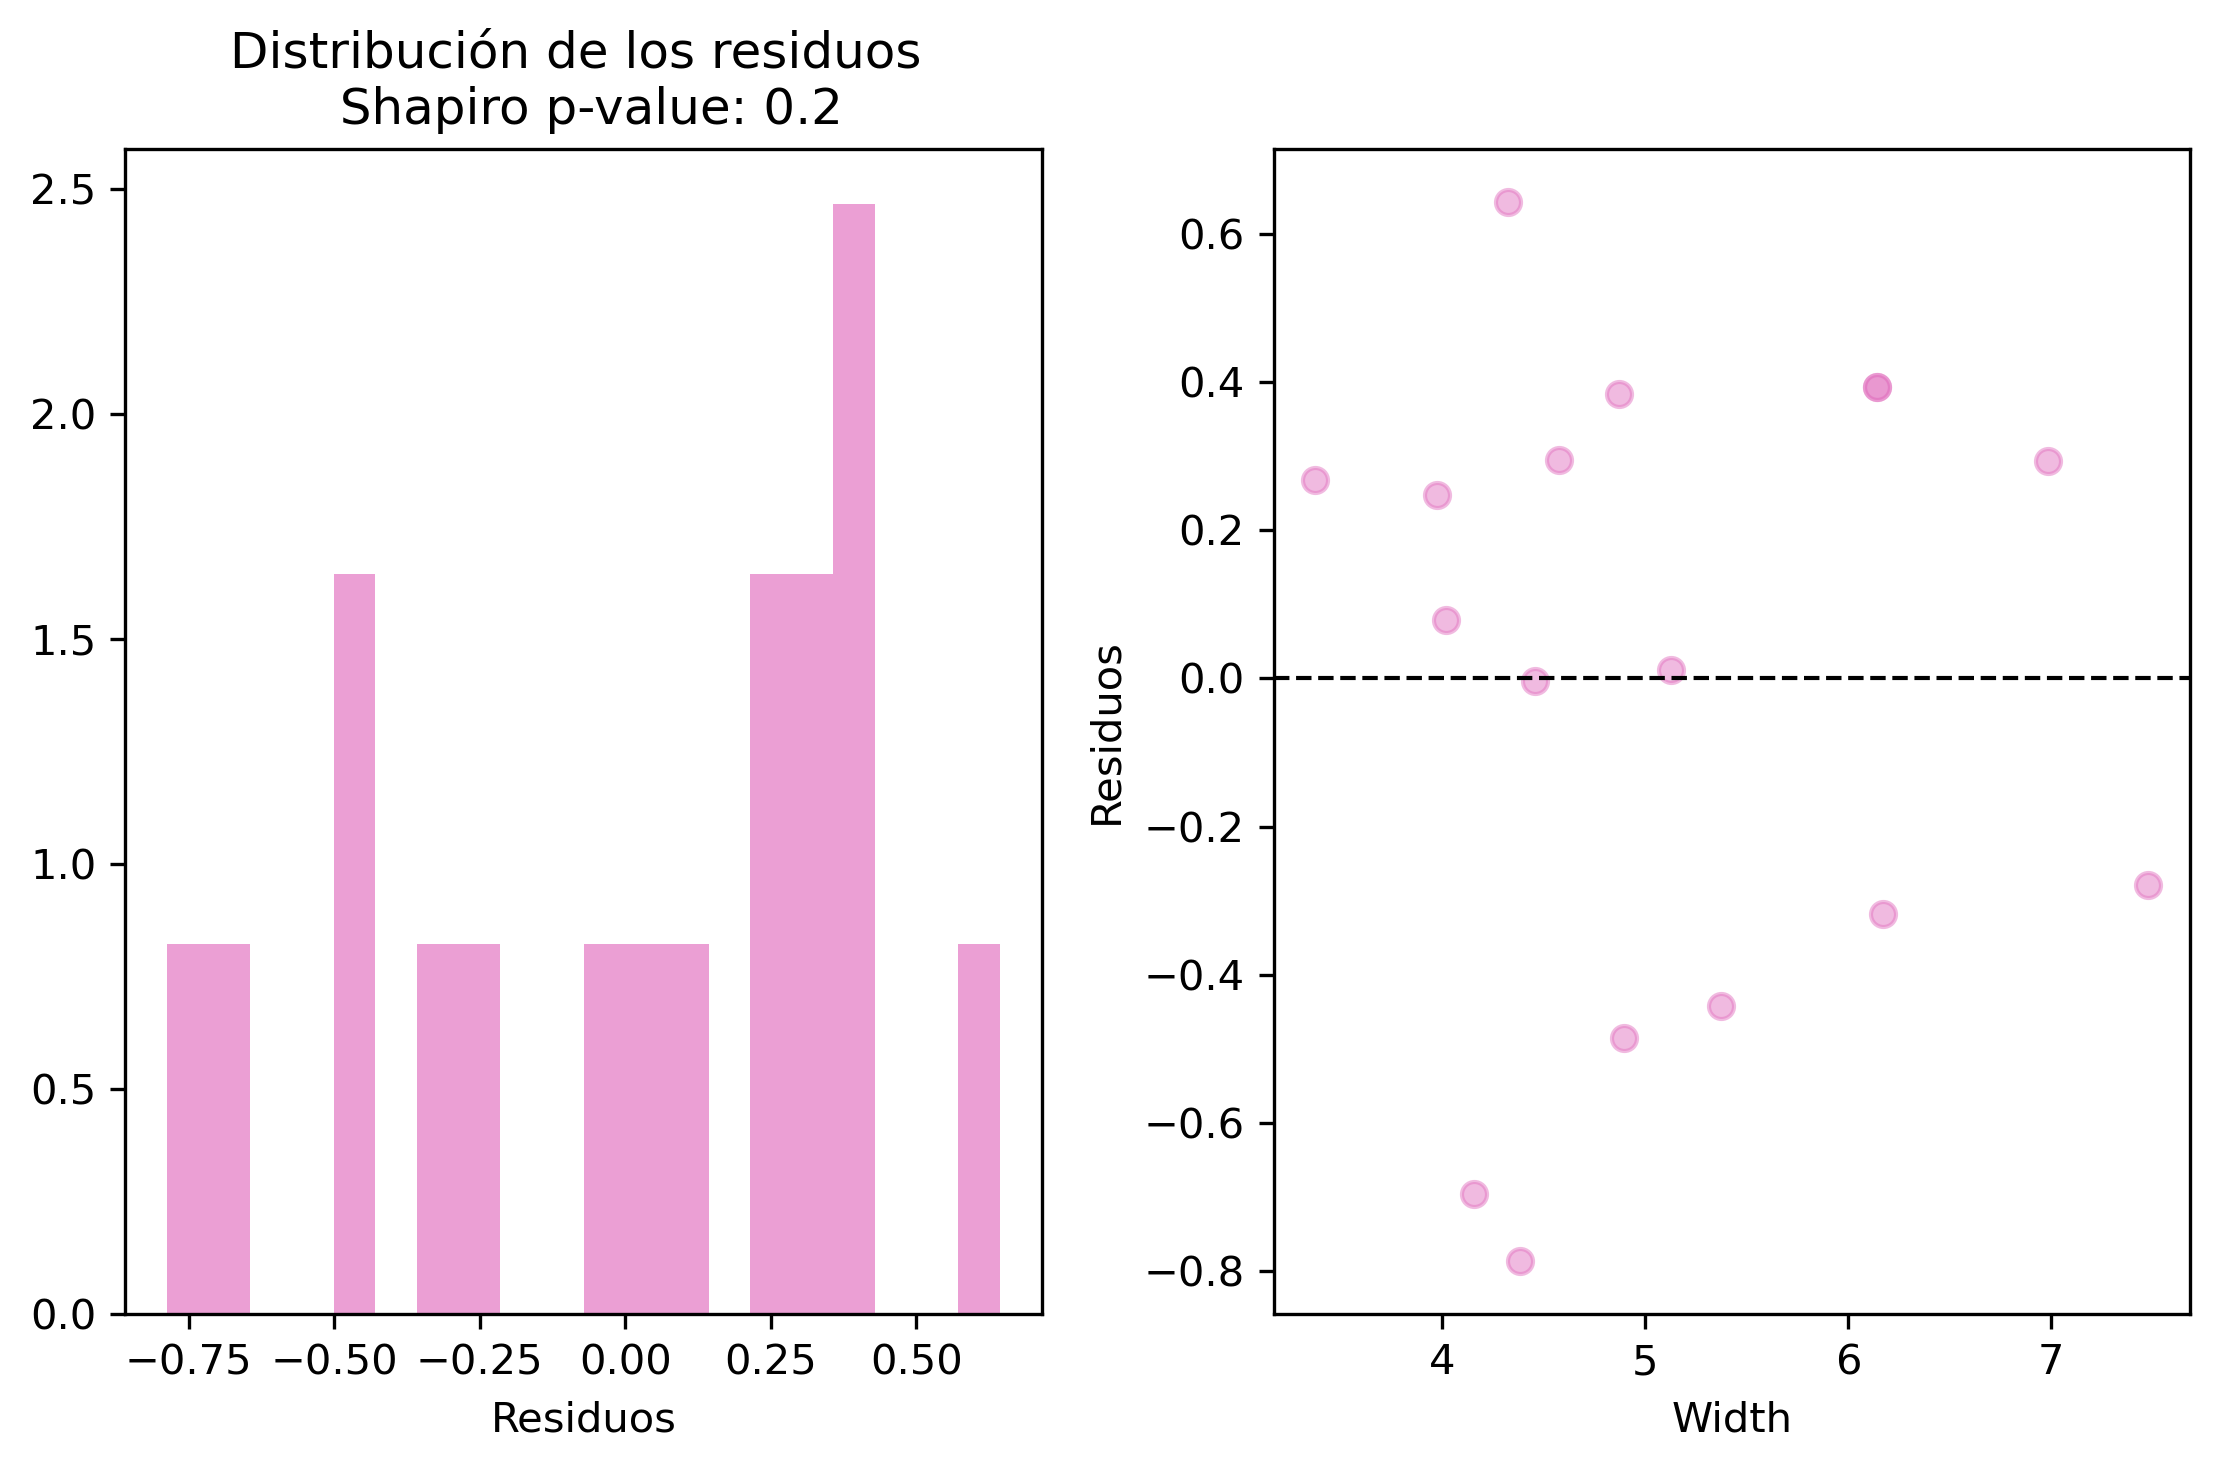

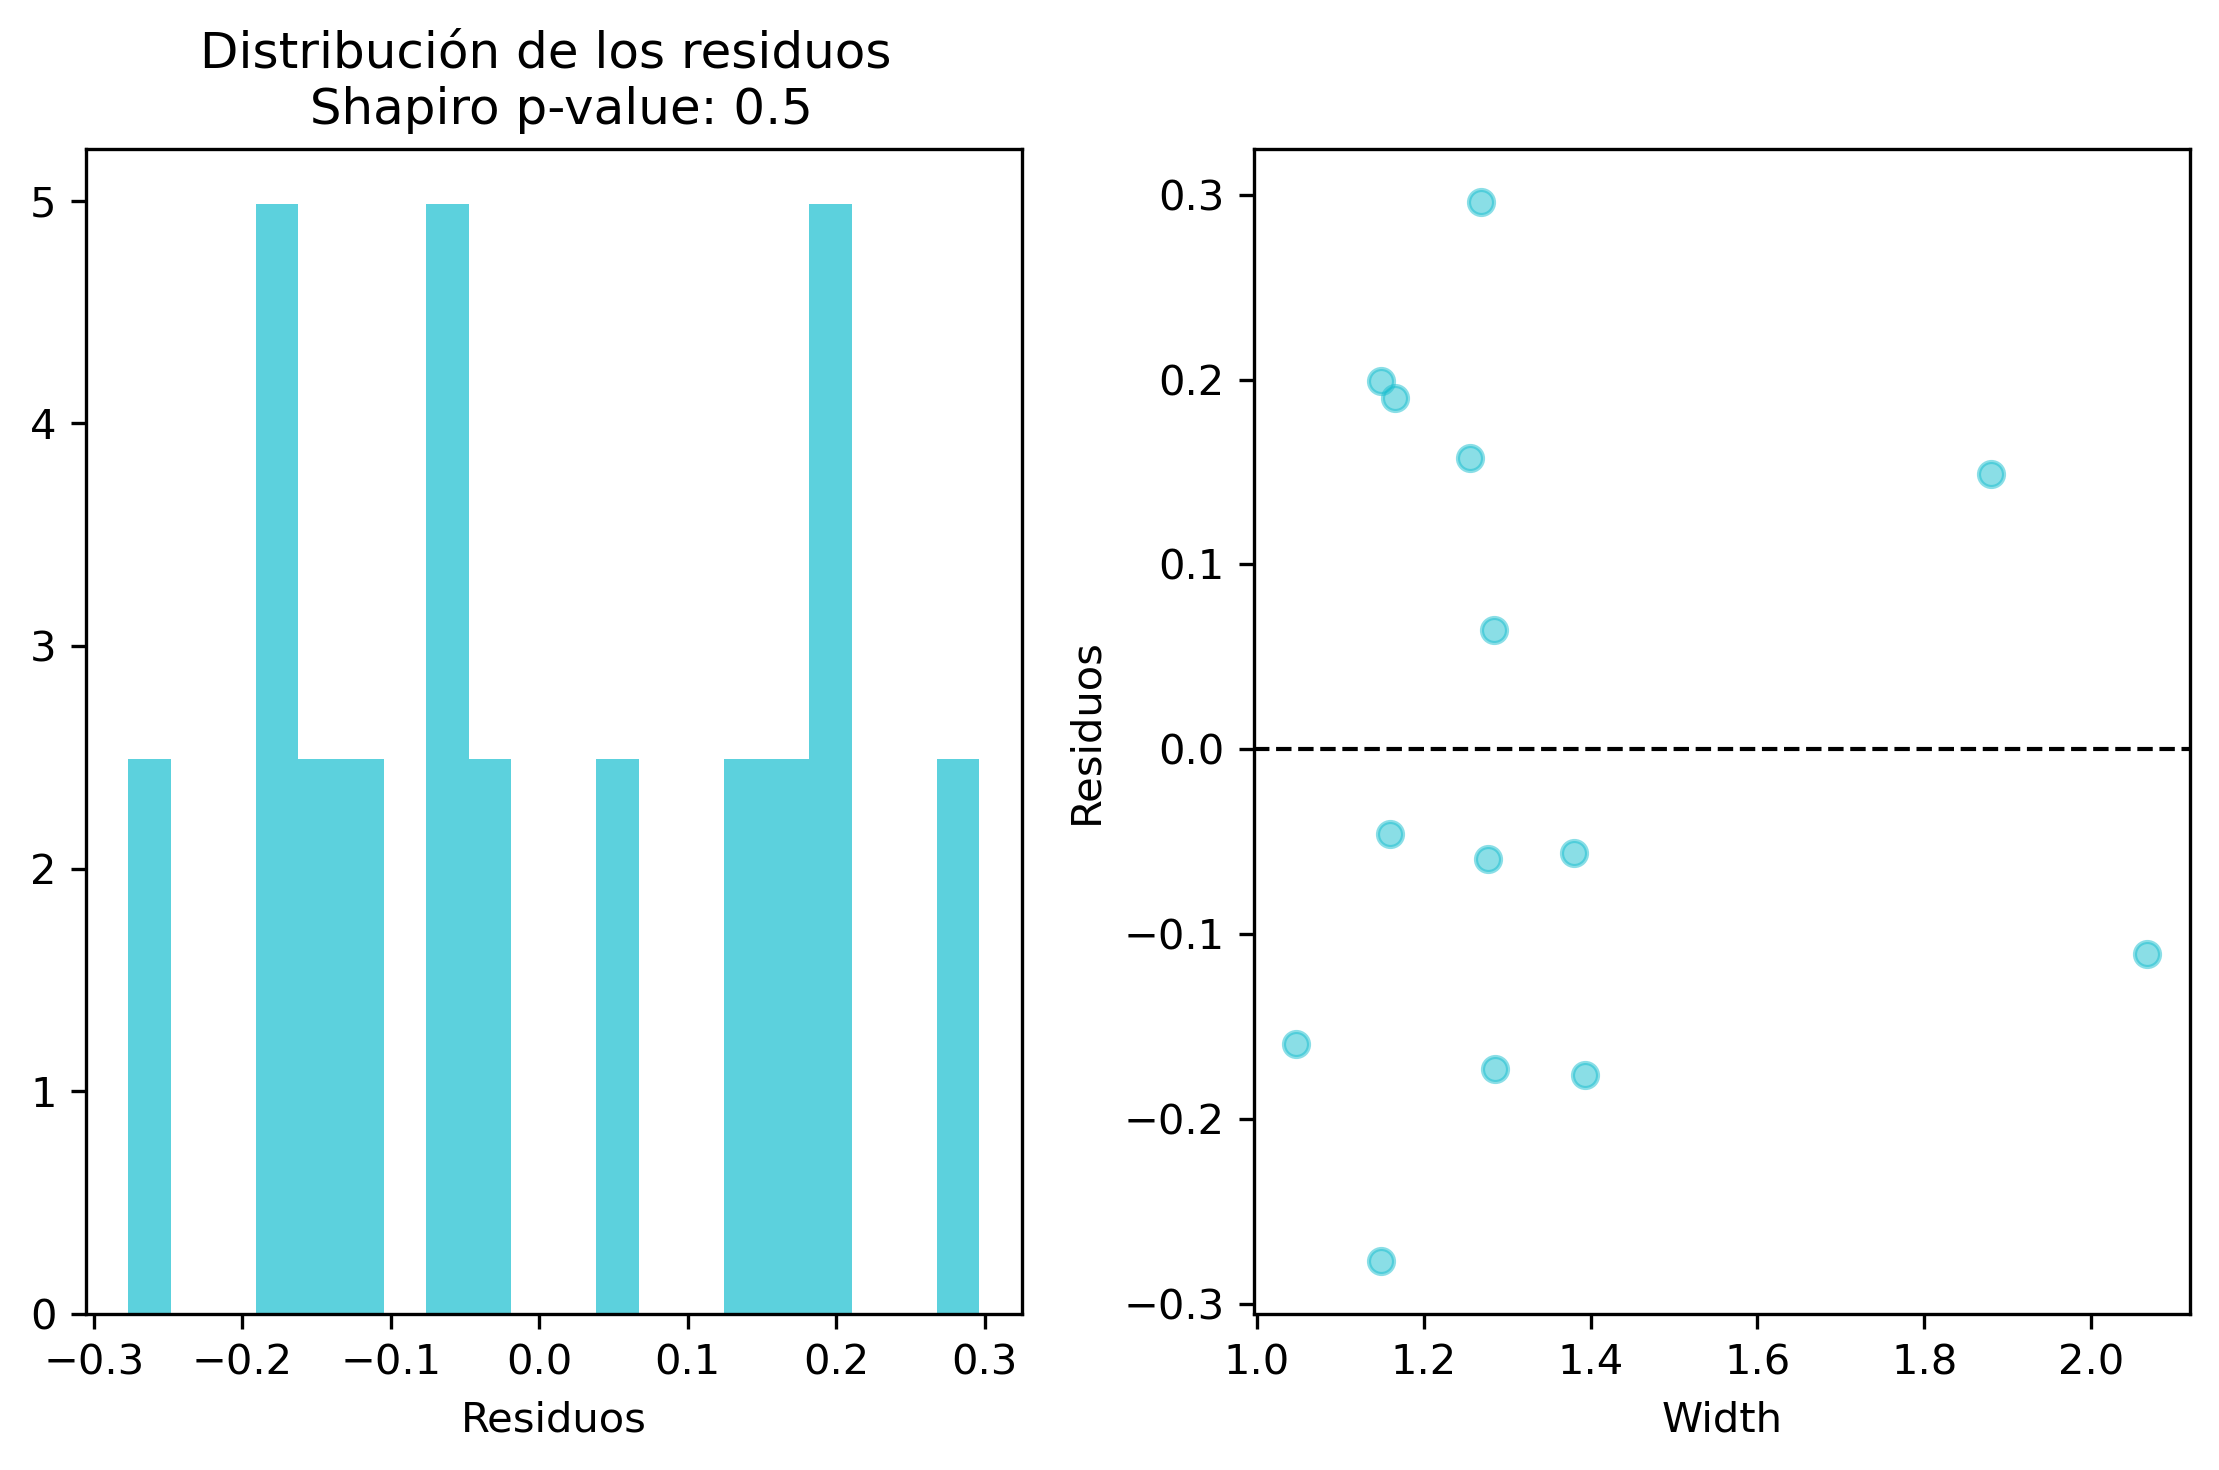

In [18]:
pez = df['Species'] # extraemos la columna Species
color_pez = {'Bream': 'tab:blue', 'Roach': 'tab:orange', 'Whitefish': 'tab:green', 
             'Parkki': 'tab:red', 'Perch': 'tab:purple', 'Pike': 'tab:pink', 'Smelt':'tab:cyan'} # colores para cada especie
for i in pez.unique():
    fig, ax = plt.subplots(1, 2,figsize=(7.5, 5), dpi = 300)
    # slope, intercept, r_value, p_value, std_err = stats.linregress(width[pez == i], height[pez == i]) # forma rapida de calcular la regresión lineal
    # ax[1].plot(width[pez == i], slope*width[pez == i] + intercept, linewidth=2)
    modelo_pez = OLS(height[pez == i], sm.add_constant(width[pez == i])).fit() # ajustamos el modelo de regresión lineal
    resid = modelo_pez.resid # residuos del modelo
    shapiro_p = stats.shapiro(resid)[1] # p-value de la prueba de Shapiro-Wilk
    
    ax[0].hist(resid, bins=20, alpha=0.7, density=True, color = color_pez[i])
    ax[0].set_xlabel('Residuos')
    ax[0].set_title('Distribución de los residuos \n Shapiro p-value: {:.1f}'.format(shapiro_p))
    ax[1].scatter(width[pez == i], resid, alpha=0.5, label = i, color = color_pez[i])
    ax[1].set_xlabel('Width')
    ax[1].set_ylabel('Residuos')
    ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
    fig.tight_layout()
    plt.show()
    

Podemos ver como el modelo puede generar mejores resultados al poder agregar la información de los peces.
**¿Qué se concluye al respecto?**

## Regresión Lineal Multivariada

## EDA
> Visualice las relaciones bivariadas entre Height y las demás variables numéricas. ¿Existen correlaciones lineales claras?
>> Genere un reporte con diagramas de dispersión y superponga líneas de regresión. Para cada par, incluya el coeficiente de correlación de Pearson y su valor-$p$ en una etiqueta dentro del gráfico.

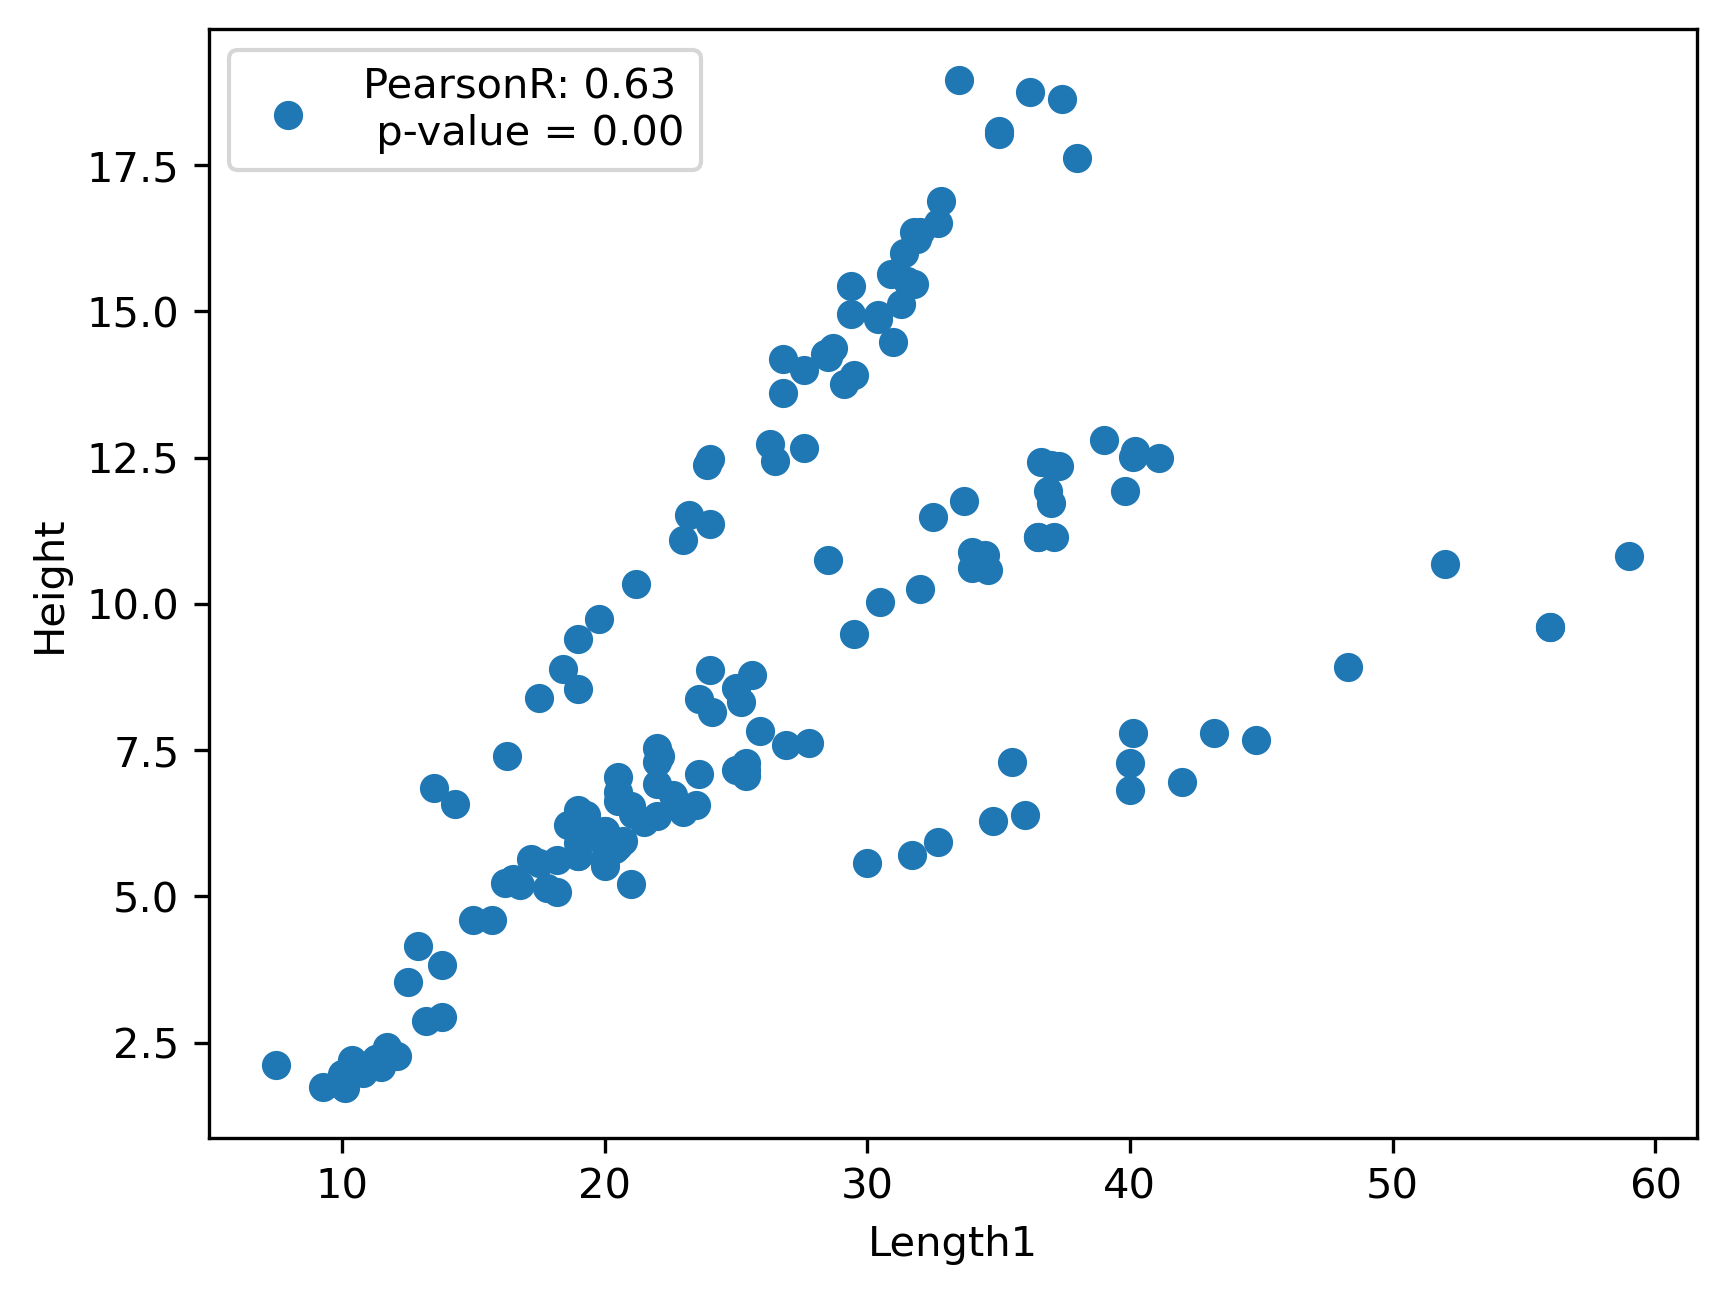

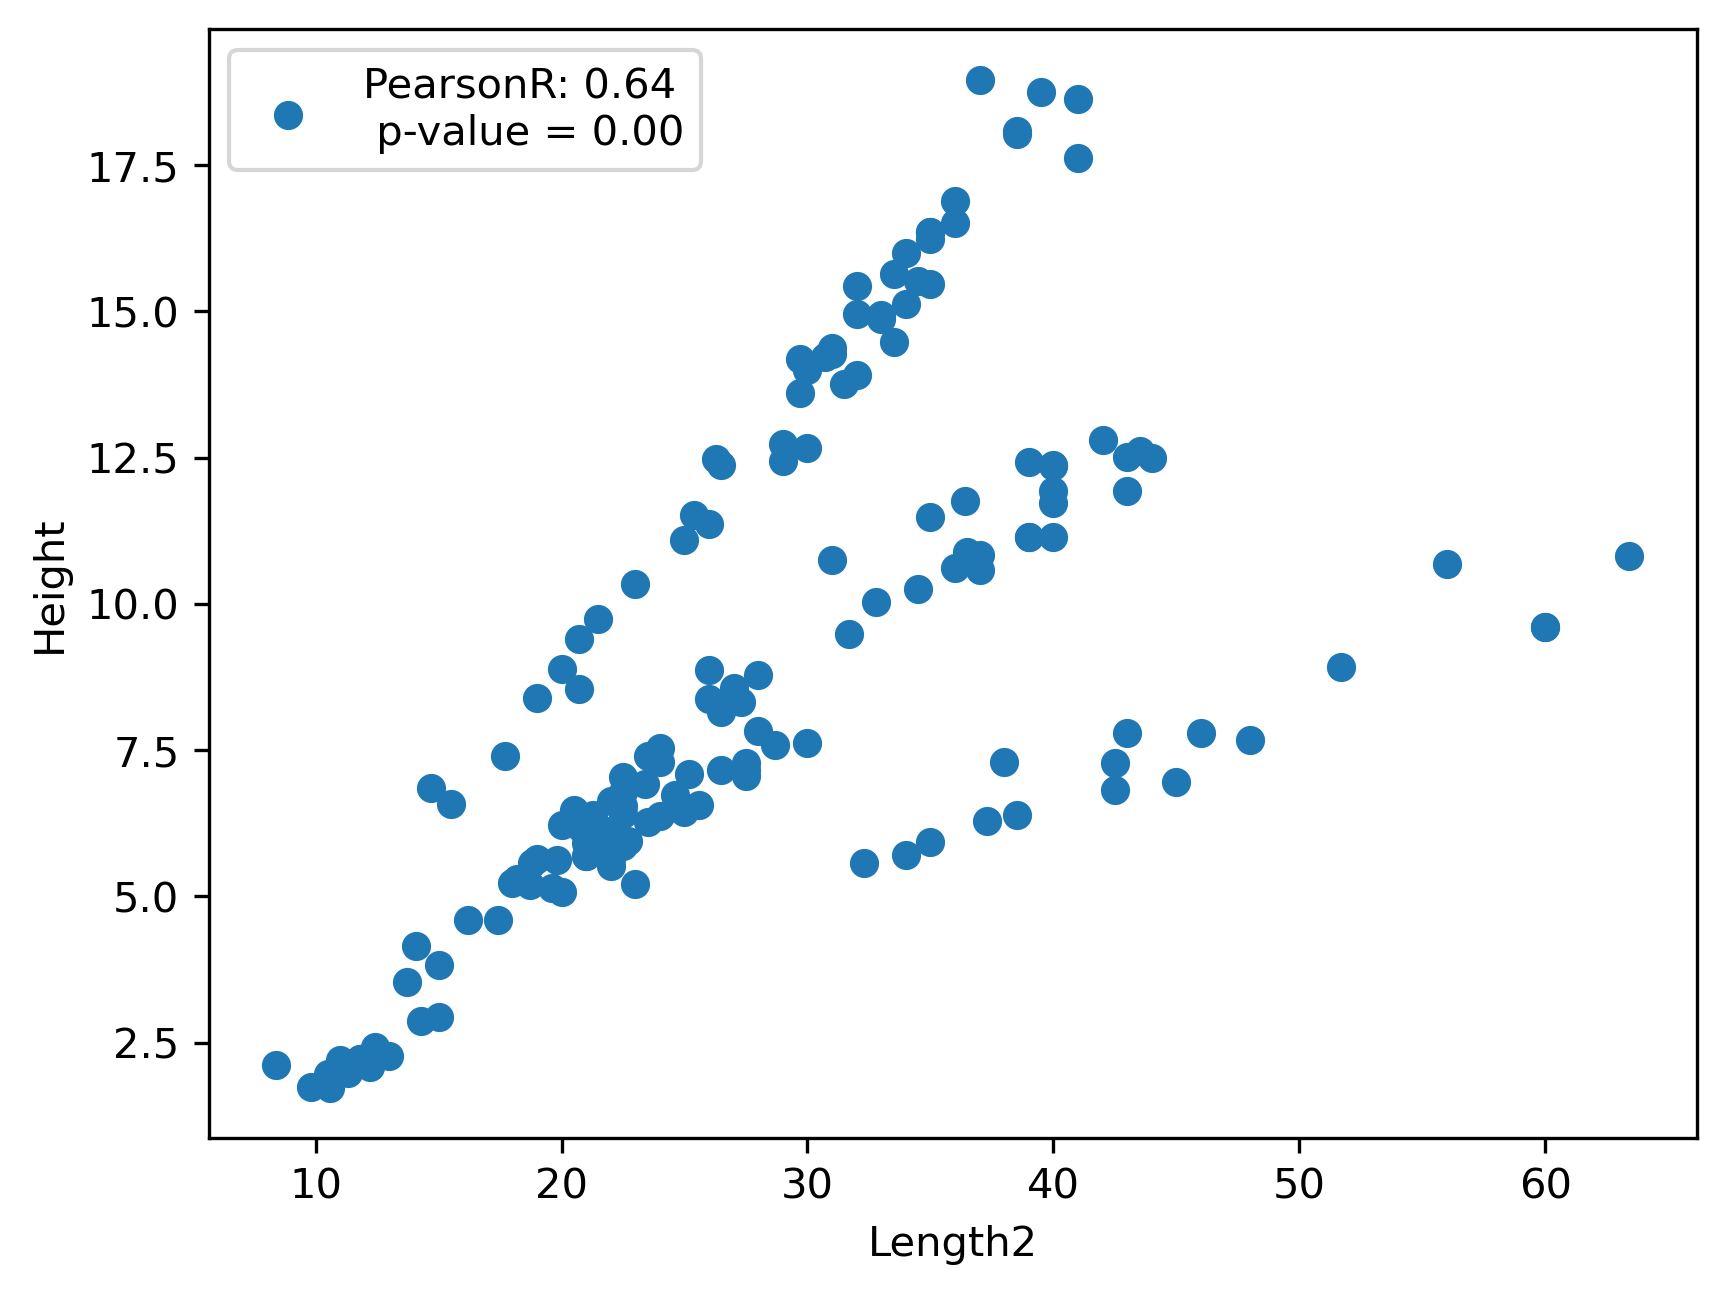

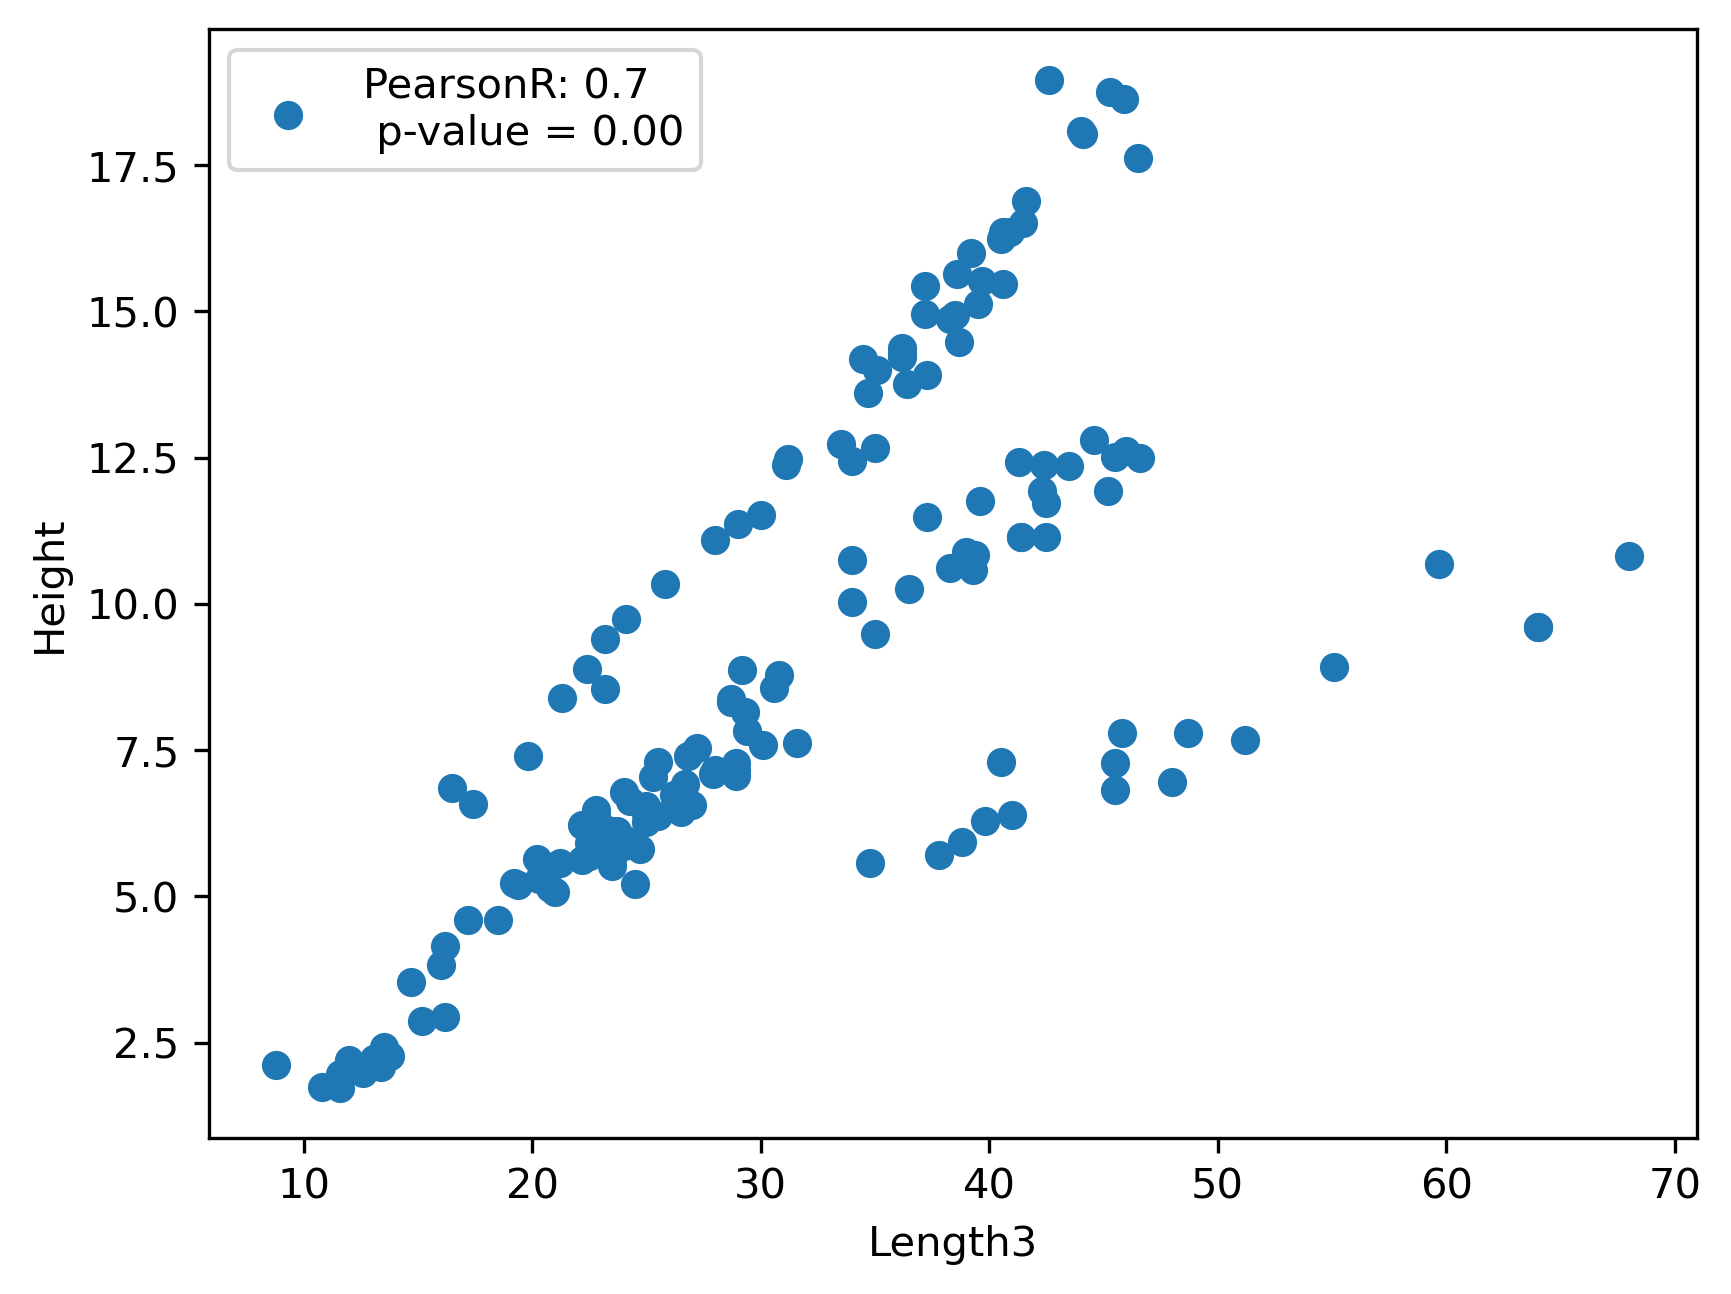

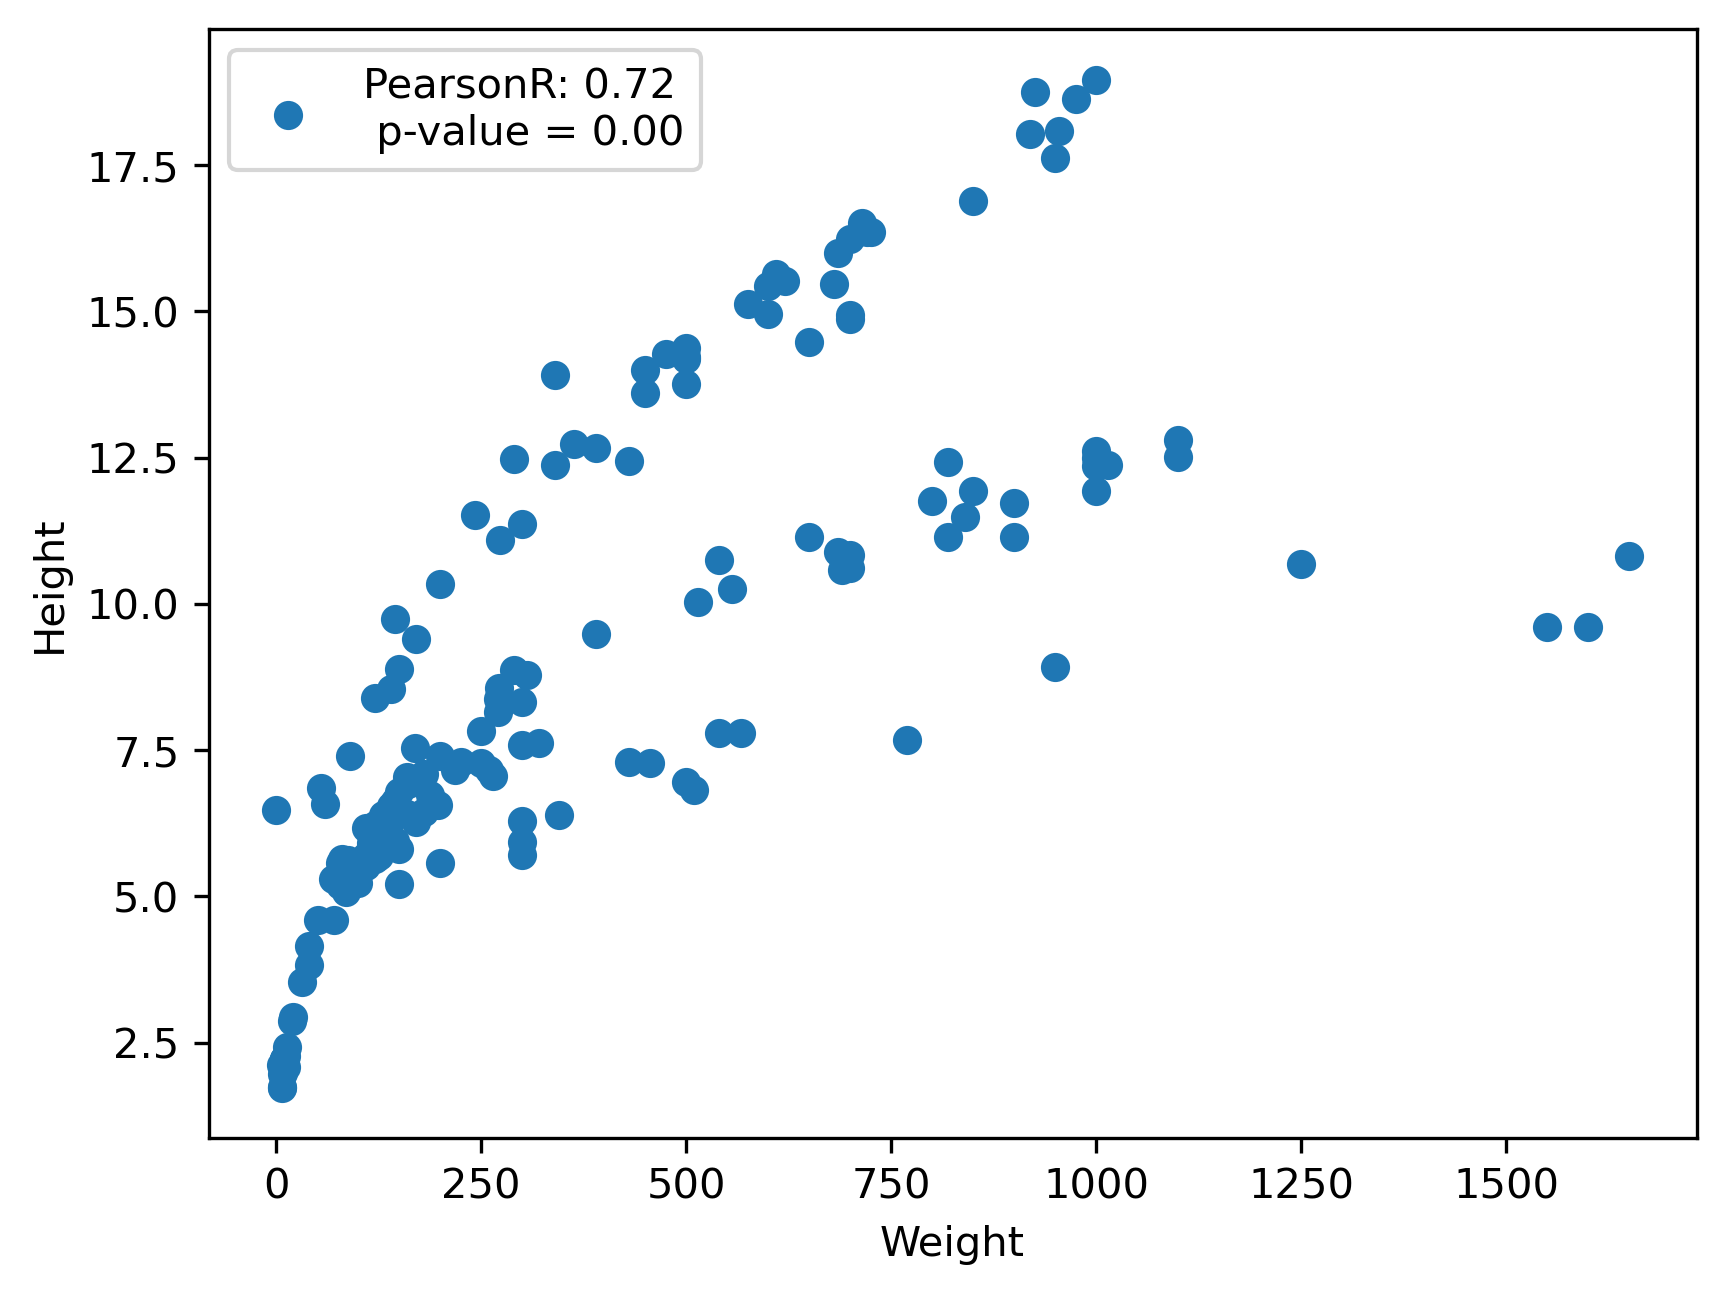

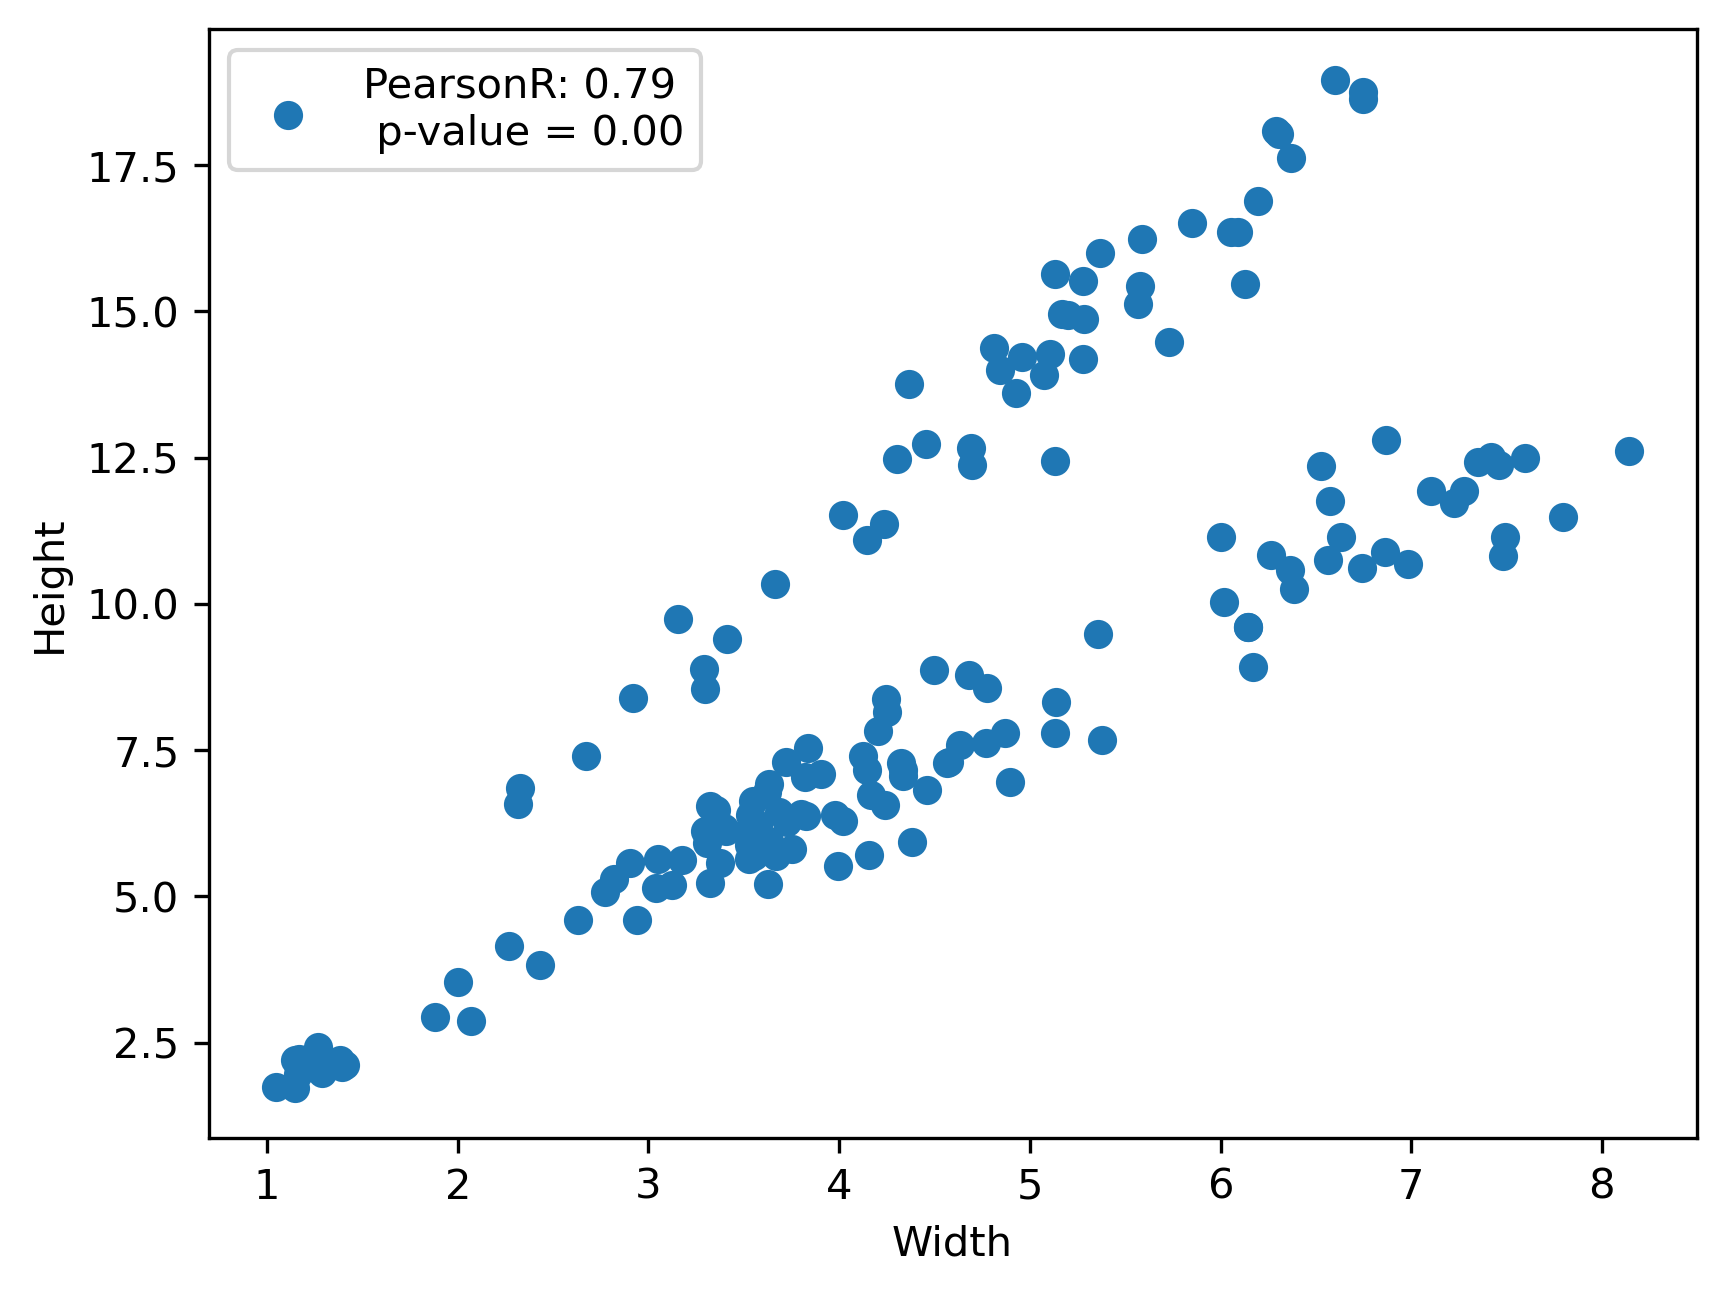

In [19]:
columns = ['Length1', 'Length2', 'Length3', 'Weight',
       'Width']

for col in columns:
    fig, ax = plt.subplots(dpi = 300)
    x = df[col]
    y = df['Height']
    pearson_r, pearson_pval = stats.pearsonr(x, y)
    ax.scatter(x,y, label = f'PearsonR: {pearson_r:.2}\n p-value = {pearson_pval:.2f}')    
    ax.legend(loc = 'upper left')
    ax.set_xlabel(col)
    ax.set_ylabel('Height')

## Cálculo de Regresión Lineal Multivariada

Los modelos de regresión lineal multivariada generalizan sobre la regresión lineal simple, agregando la posibilidad de relacionar multiples variables (>2). Estos tienen la siguiente forma para un set de datos con $n$ datos y $m$ variables explicativas.
$$
\mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
$$

Donde 
$$
\mathbf{y} = \begin{bmatrix} y_1 \\
 y_2 \\
 \vdots \\
  y_n \end{bmatrix}
$$
$$
\mathbf{X} = \begin{bmatrix} \mathbf{1} &\mathbf{x}_1 & \mathbf{x}_2 & \dots & \mathbf{x}_m \end{bmatrix}
$$
Notar que en este caso, cada columna es un vector de tamaño $n$ representando cada dato. Esta matriz es denominada matrix del modelo o matriz de diseño (dependiendo del libro).
$$
\mathbf{\beta} = \begin{bmatrix} 
\beta_0\\
\beta_1\\
\vdots\\
\beta_m
\end{bmatrix}
$$

$$
\mathbf{\epsilon} = \begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n
\end{bmatrix}
$$

Para encontrar los parámetros de este modelo, se utiliza una formula un poco más "sencilla" (al menos visualmente). Sabemos que $\widehat{\mathbf{\beta}}$ va a minimizar la ecuación:
$$
L = \sum_{i = 1}^n \epsilon_i^2 = \mathbf{\epsilon }^T \mathbf{\epsilon} = (\mathbf{y} - \mathbf{X}\mathbf{\beta})^T   (\mathbf{y} - \mathbf{X}\mathbf{\beta}) 
$$

Así, llegamos:
$$
\frac{\partial L}{\partial \mathbf{\beta}} = \mathbf{0}
$$
Que se transforma en las denominadas **Ecuaciones Normales**:

$$
\mathbf{X}^T \mathbf{X} \widehat{\mathbf{\beta}} = \mathbf{X}^T \mathbf{y}
$$
Que se transforma en
$$
\widehat{\mathbf{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

Así, la regresión lineal multivariada queda definida por la siguiente ecuación

$$
\widehat{\mathbf{y}} = \mathbf{X} \widehat{\mathbf{\beta}}
$$

Donde los residuales vienen definidos por 
$$
\mathbf{e} = \mathbf{y} - \mathbf{\widehat{y}}
$$

Ahora pongamoslo en práctica 😎

> Formule el modelo de regresión lineal múltiple para `Height`. Construya explícitamente la matriz del modelo ($X$) y resuelva las ecuaciones normales para estimar el vector de parámetros.

In [20]:
y = df['Height'] # extraemos la columna Height
X = df.copy().drop(columns = ['Height', 'Species']) # extraemos la columna Species y Height  
# recordemos que X es la matriz de diseño y por ende debe tener una columna de unos
X = sm.add_constant(X) # agregamos la columna de unos
X

const  Weight  Length1  Length2  Length3   Width
0      1.0   242.0     23.2     25.4     30.0  4.0200
1      1.0   290.0     24.0     26.3     31.2  4.3056
2      1.0   340.0     23.9     26.5     31.1  4.6961
3      1.0   363.0     26.3     29.0     33.5  4.4555
4      1.0   430.0     26.5     29.0     34.0  5.1340
..     ...     ...      ...      ...      ...     ...
154    1.0    12.2     11.5     12.2     13.4  1.3936
155    1.0    13.4     11.7     12.4     13.5  1.2690
156    1.0    12.2     12.1     13.0     13.8  1.2558
157    1.0    19.7     13.2     14.3     15.2  2.0672
158    1.0    19.9     13.8     15.0     16.2  1.8792

[159 rows x 6 columns]

In [21]:
# ahora introduciremos nociones de algebra lineal por medio de la libreria numpy
# asi que usaremos los arrays de numpy
X_arr = X.to_numpy() # convertimos el dataframe a un array de numpy
y_arr = y.to_numpy() # convertimos el dataframe a un array de numpy 

# paso 1.: Calculamos X^T * X
X_transpuesta = np.transpose(X_arr) # transponemos la matriz X
X_transpuesta_X = X_transpuesta @ X_arr # multiplicamos la matriz transpuesta por la matriz original
# @ es el operador de multiplicación de matrices en numpy
# paso 2.: Calculamos la inversa de X^T * X
X_transpuesta_X_inversa = np.linalg.inv(X_transpuesta_X) # calculamos la inversa de la matriz
# paso 3.: Calculamos X^T * y
X_transpuesta_y = X_transpuesta @ y_arr # multiplicamos la matriz transpuesta por la matriz y
# paso 4.: Calculamos beta
beta = X_transpuesta_X_inversa @ X_transpuesta_y # multiplicamos la matriz inversa por la matriz transpuesta por y

print(beta) # imprimimos los coeficientes de la regresión

[ 0.54402159  0.00227119 -1.42725061 -0.50173888  1.66704131  1.62628402]


Si vemos el vector $\mathbf{\beta}$ tiene un tamaño 6, que corresponde con m = 5 variables explicativas y 1 constante ($\beta_0$).

## ANOVA en Regresión Lineal Multivariada

> Aplique un análisis de varianza (ANOVA) para el modelo múltiple. ¿Qué indica el valor-$p$?

Previamente utilizamos el test anova para estimar si los diferentes componentes de la regresión tenían relación o no con la variable de respuesta. En este caso, ANOVA para una regresión multivariada se encarga de lo mismo pero con todos los $\beta_i$. 

Al igual que antes, ANOVA tiene la siguiente forma:
$$
H_0: \beta_1 = \ldots = \beta_k = 0
$$
$$
H_a: \beta_i \neq 0, \text{para algún i}
$$

En este caso, el estadístico de prueba se define como:
$$
F_0 = \frac{SS_R / m}{SS_E/( n - m - 1)}  = \frac{MS_R}{MS_E}
$$

Donde, 

$$
SS_T = \mathbf{y}^T\mathbf{y} - \frac{(\sum_{i=1}^k y_i )^2}{n}
$$
$$
SS_R = \widehat{\mathbf{\beta}}^T \mathbf{X}^T \mathbf{y} - \frac{(\sum_{i=1}^k y_i )^2}{n}
$$
$$
SS_E = SS_T - SS_R
$$

Y la prueba se realiza sobre una distribución $f_{m, n-m+1}$

In [22]:
# calculamos SS_T y SS_R

SS_T = y_arr.T @ y_arr - np.sum(y_arr)**2/len(y_arr) # suma total de cuadrados
SS_R = beta.T @ X_arr.T @ y_arr - np.sum(y_arr)**2/len(y_arr) # suma de cuadrados de la regresión
SS_E = SS_T - SS_R # suma de cuadrados del error
m = 5 # número de variables independientes
n = len(y_arr) # número de observaciones


MS_R = SS_R/(m) 
MS_E = SS_E/(n - m - 1) # media cuadrática del error

F_0 = MS_R/MS_E # estadístico de prueba para la regresión
print(f'F_0 = {F_0:.3f}') # imprimimos el estadístico de prueba para la regresión

F_0 = 445.867


In [23]:
# el valor p de la prueba ANOVA viene dado entonces por
p_value_F = stats.f.sf(F_0, m, n - m - 1) # p-value para la regresión
print(f'p-value F = {p_value_F:.3e}') # imprimimos el p-value para la regresión

p-value F = 2.870e-89


## Significancia de coeficientes

> Evalúe individualmente los parámetros del modelo mediante pruebas $t$. ¿Cuáles son estadísticamente significativos?

Al igual que cuando se realiza el test-t sobre los parámetros de una regresión lineal simple, es posible evaluar al significancia de un parámetro de una regresión lineal multivariada.

En primer lugar, tenemos el estimador de la varianza del modelo
$$
\widehat{\sigma}^2 = \frac{SS_E}{n-m-1}
$$
El cual posteriormente es utilizado para calcular los errores estándar de cada uno de los parámetros, los cuales se estiman por medio de la siguiente matriz.

$$
cov(\widehat{\mathbf{\beta}}) = \sigma^2 ( \mathbf{X}^T \mathbf{X})^{-1}
$$

La cual nos da la covarianza entre los parámetros estimados, y más aún. Si reemplazamos $\sigma$ por $\widehat{\sigma}$ la diagonal de dicha matriz nos da el error estándar de cada componente. De esta forma
$$
se(\widehat{\beta}_j) = \sqrt{\widehat{\sigma}^2 \mathbf{C}_{jj}}
$$
Donde $  (\mathbf{X}^T \mathbf{X})^{-1} = \mathbf{C}$


Con esto en mente, el test de significancia de los parámetros es sencillo de calcular. Este test tiene el siguiente planteamiento
$$
H_0: \beta_j = 0
$$
$$
H_a: \beta_j \neq 0
$$

Donde el estadístico viene dado por
$$
T_0 = \frac{\widehat{\beta_j}}{\sqrt{\widehat{\sigma}^2 \mathbf{C}_{jj}}} = \frac{\widehat{\beta_j}}{se(\widehat{\beta}_j)}
$$

Luego, el test se evalua sobre una distribución $t_{n-m-1}$.

In [24]:
C = np.linalg.inv(X.T @ X)
sigma_hat_2 = SS_E / (n - m - 1) # varianza del error
se_vec = np.sqrt(np.diag(sigma_hat_2 * C)) 

# calculamos los valores T  del estadístico
T = beta / se_vec # estadístico de prueba para los coeficientes
print(f'T = {T}') # imprimimos el estadístico de prueba para los coeficientes

T = [ 1.218953    3.24167923 -4.14631984 -1.34899047 20.76158369 12.74278347]


In [25]:
# calculamos los p-values
p_values = 2*stats.t.sf(np.abs(T), n - m - 1) # p-value para los coeficientes
print(f'p-values = {p_values}') # imprimimos el p-value para los coeficientes

p-values = [2.24738055e-01 1.45847749e-03 5.57989962e-05 1.79333129e-01
 2.34262599e-46 8.29223635e-26]


**¿Qué podemos interpretar hacerca de esto?**

## Coeficiente de Determinación y Coeficiente de Determinación ajustado

> Calcule el coeficiente de determinación $R^2$ y el coeficiente ajustado $R^2_{\text{adj}}$. ¿Cuál es más informativo en este contexto? Justifique.

En la regresión lineal simple vimos el coeficiente $R^2$ que define la cantidad de varianza capturada por el modelo. Este se cálcula al igual que antes
$$
R^2 = \frac{SS_R}{SS_T} = 1 - \frac{SS_E}{SS_T}
$$

El problema en este caso, es que el modelo, al agregarle más y más información, este va a disminuir el error. Esto se conoce usualmente como *overfitting*. Por lo cuál, $R^2$ aumentará a medida que más datos le demos al modelo. El problema en este caso es que se rompe el princio de parsimonia. Así, es que se utiliza el $R^2_{\text{adj}}$, el cuál se define como:

$$
R^2_{\text{adj}} = 1 - \frac{SS_E/(n - m - 1)}{SS_T / (n-1)}
$$

Que va a penalizar la inclusión de datos que no sean realmente informativos para el modelo.

In [26]:
R2 = SS_R/SS_T # coeficiente de determinación
print(f'R2 = {R2:.3f}') # imprimimos el coeficiente de determinación

R2 = 0.936


In [27]:
R2_adj = 1 - (SS_E/(n - m - 1)) / (SS_T/(n - 1)) # coeficiente de determinación ajustado
print(f'R2_adj = {R2_adj:.3f}') # imprimimos el coeficiente de determinación ajustado


R2_adj = 0.934


## Regresión Lineal Multivariada en Python

> Utilice la función `OLS` de `statsmodels` para generar un reporte completo del modelo. Compare los resultados con sus cálculos previos. ¿Cómo comunicaría visualmente los resultados de este modelo?

In [28]:
model = sm.OLS(y, X).fit() # ajustamos el modelo de regresión lineal 
# recordemos que X ya tiene la columna de unos
print(model.summary()) # imprimimos el resumen del modelo

                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     445.9
Date:                Wed, 07 May 2025   Prob (F-statistic):           2.87e-89
Time:                        01:17:58   Log-Likelihood:                -238.26
No. Observations:                 159   AIC:                             488.5
Df Residuals:                     153   BIC:                             506.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5440      0.446      1.219      0.2

El problema en este caso, es que si queremos graficar el modelo, no podemos hacer lo anterior que era x = variable explicativa e y = de respuesta. 

**¿Qué podemos hacer?**

En este caso, podemos utilizar un gráfico de *predicted vs observed* que contrasta lo predicho por el modelo con lo observado. Este tipo de gráficos son altamente usados en análisis multivariado y machine learning -en problemas de regresión.

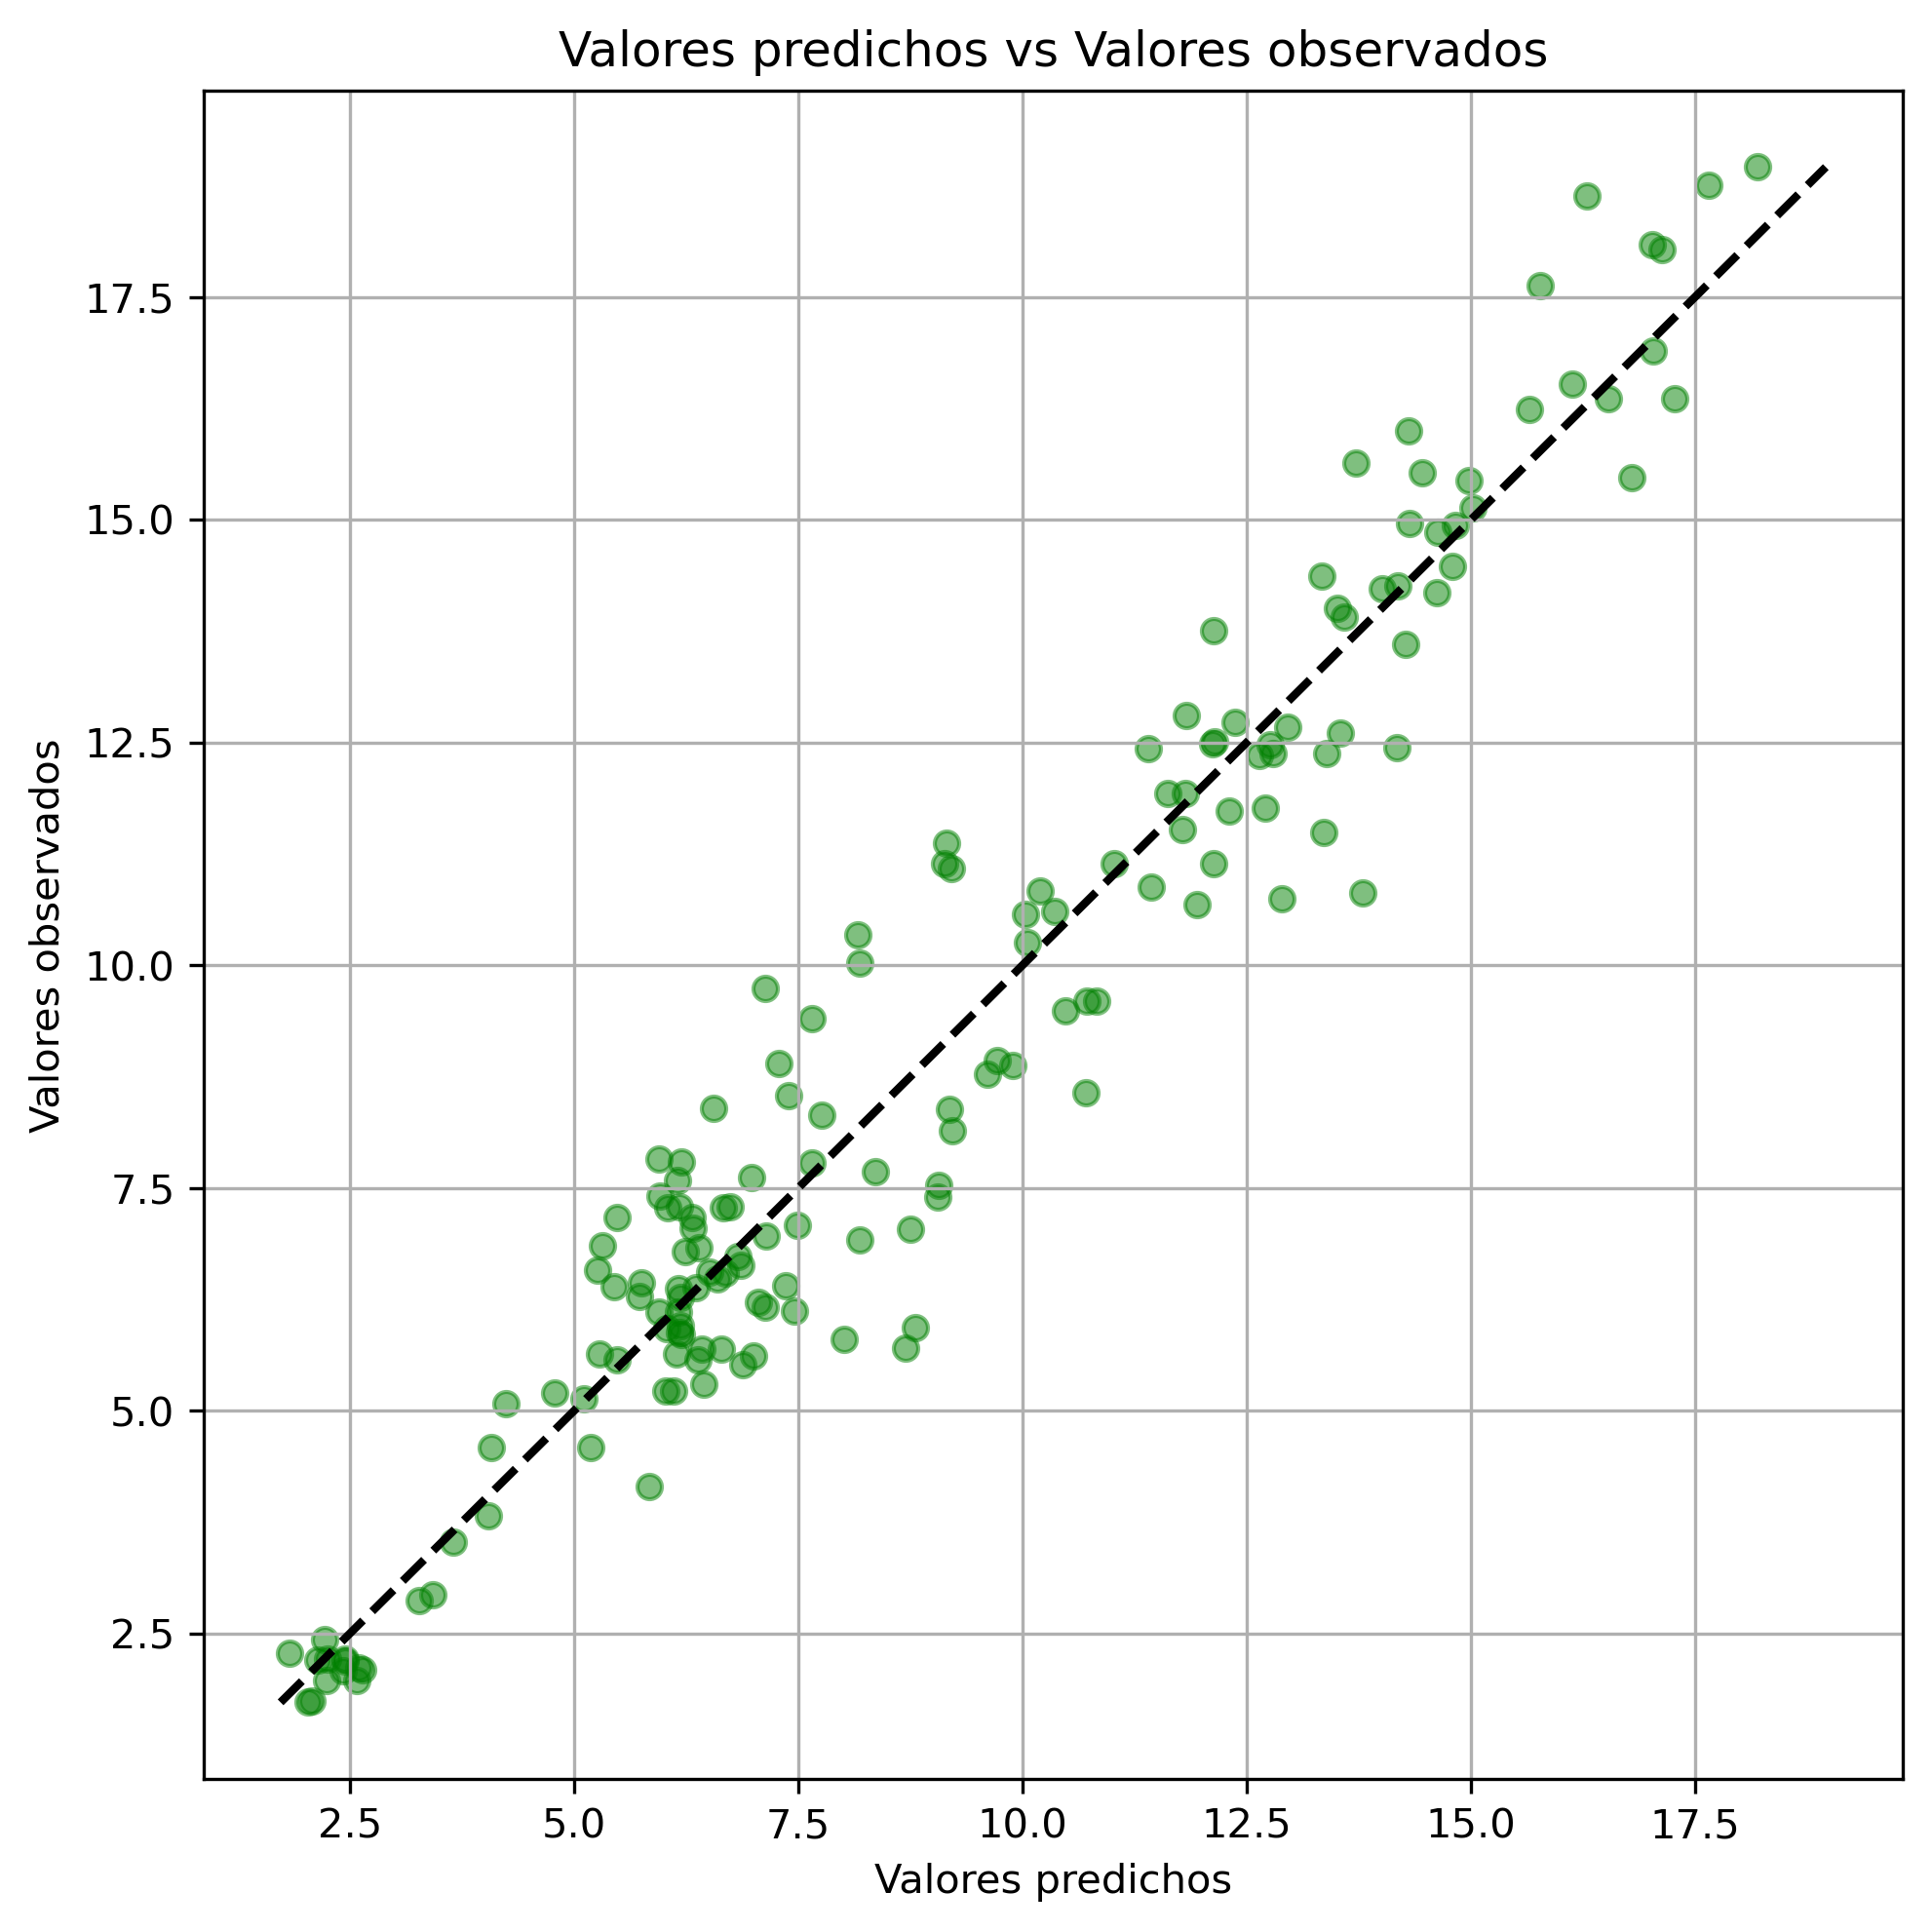

In [29]:

predicted = model.predict(X) # valores predichos del modelo
fig, ax = plt.subplots(1,figsize=(7.5, 7.5), dpi = 300)
ax.scatter(predicted, y, alpha=0.5, color = 'green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], color = 'black', linestyle='--', linewidth=2, zorder = 2)
ax.set_xlabel('Valores predichos')
ax.set_ylabel('Valores observados')
ax.set_title('Valores predichos vs Valores observados')
ax.grid(zorder = 0)
plt.show()

Y ya que estamos, podemos también analizar los residuos.

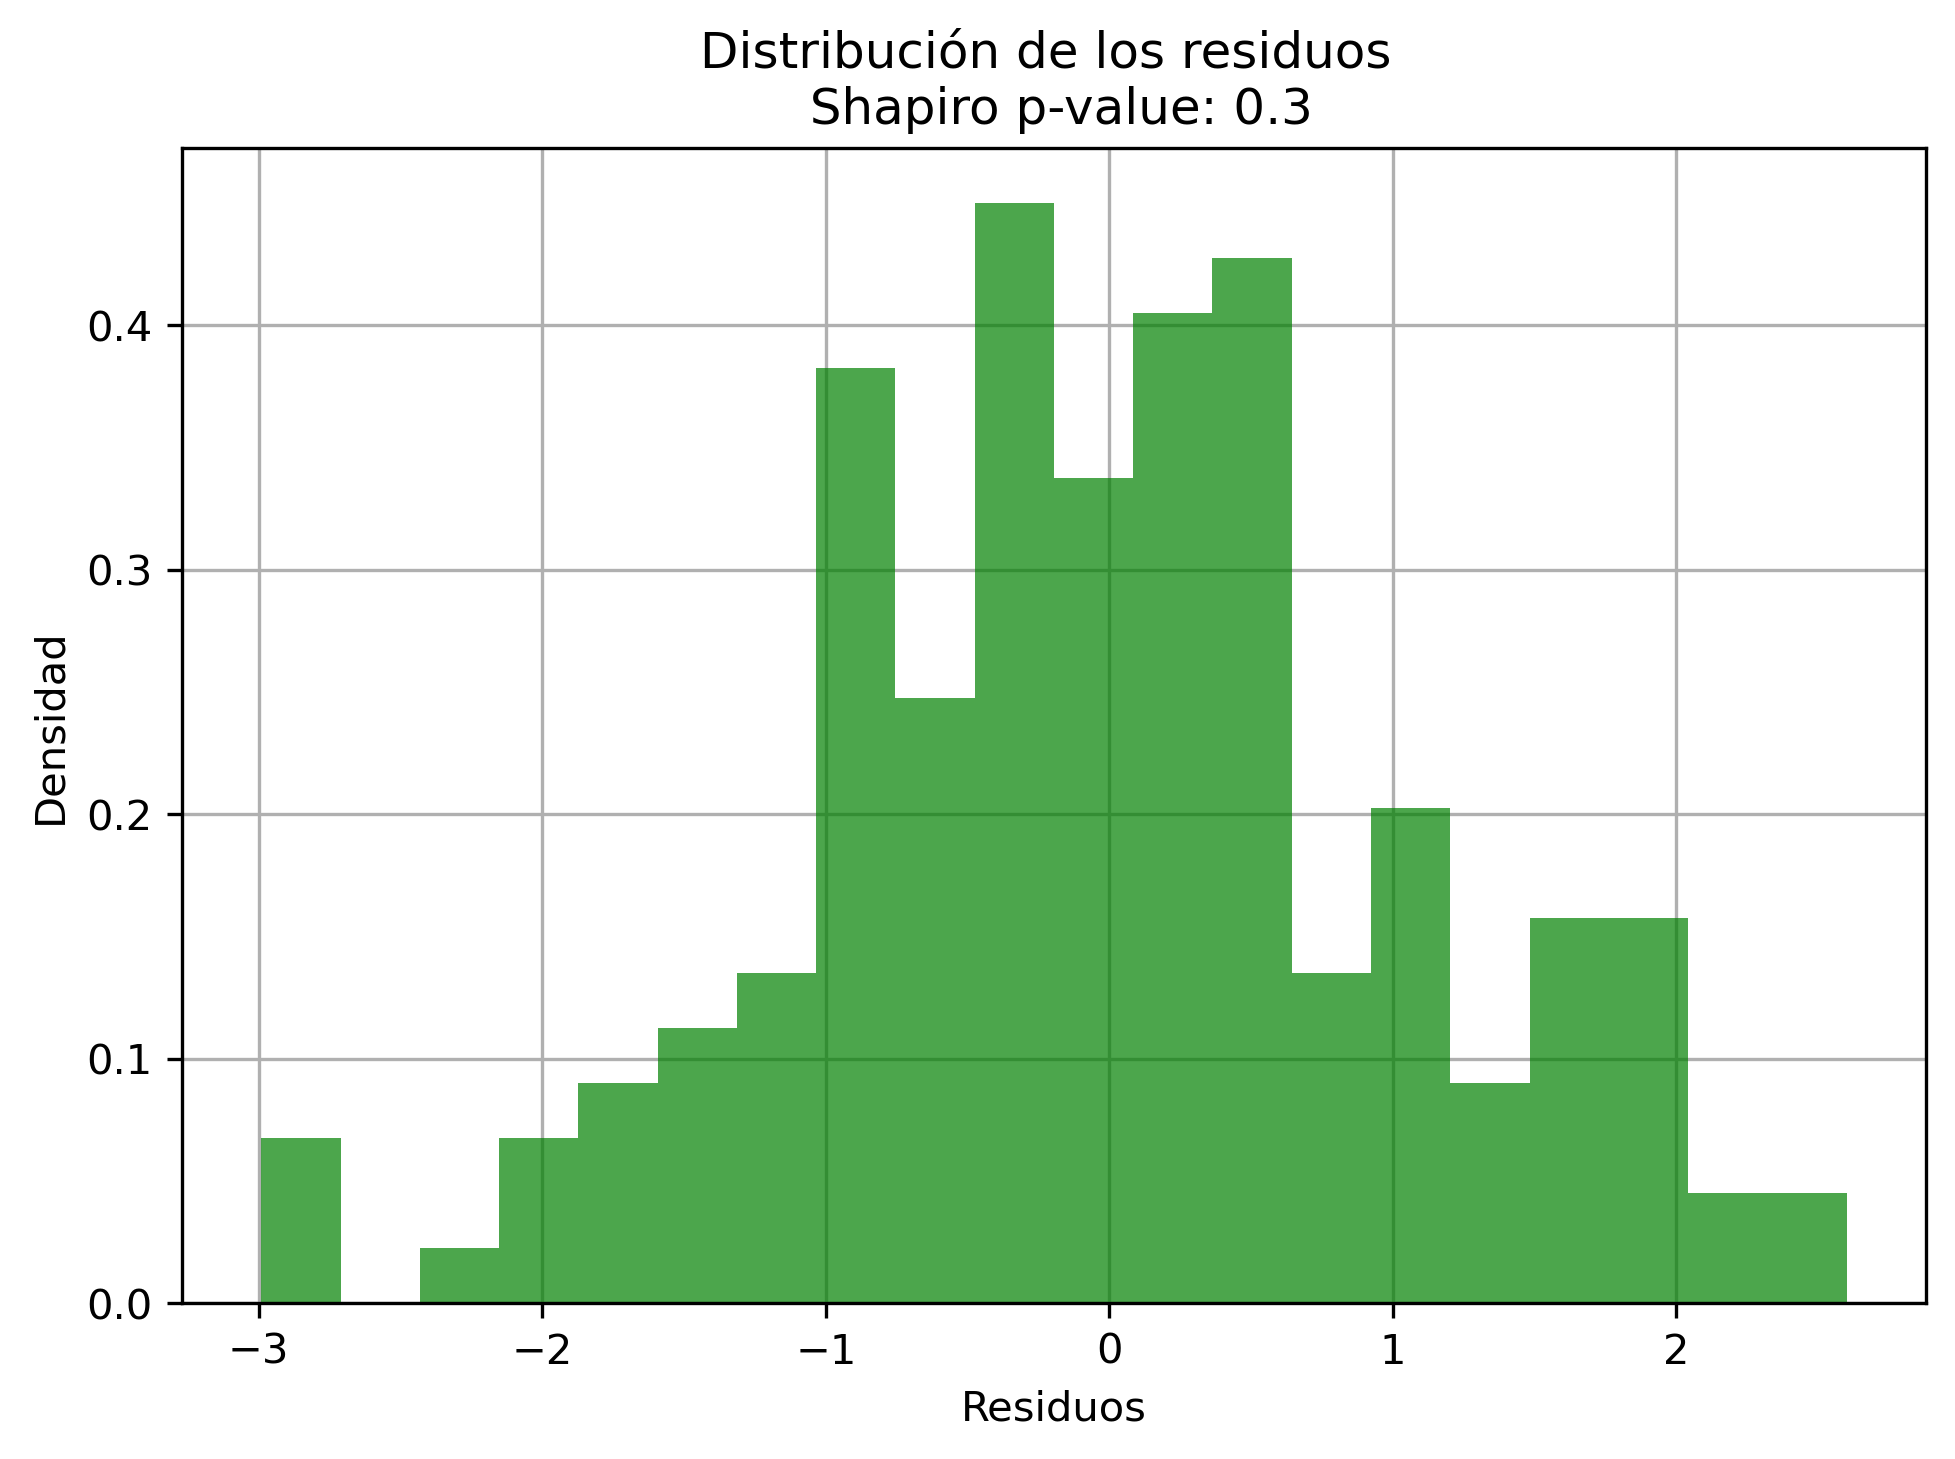

In [30]:
residuos = model.resid # residuos del modelo
fig, ax = plt.subplots(1,figsize=(7.5, 5), dpi = 300)
shapiro_p = stats.shapiro(residuos)[1] # p-value de la prueba de Shapiro-Wilk
ax.hist(residuos, bins=20, color='green', alpha=0.7, density=True, zorder = 2)
ax.set_title('Distribución de los residuos \n Shapiro p-value: {:.1f}'.format(shapiro_p))
ax.set_xlabel('Residuos')
ax.set_ylabel('Densidad')
ax.grid(zorder = 0)
plt.show()

**¿Qué paso aquí?**

## Selección de Parámetros

Como vimos anteriormente, algunos parámetros no son significativos en el modelo. Y al agregar todos los datos, estamos arriesgando *overfit* el modelo. Así, podemos eliminar parámetros del modelo para cumplir los principios de parsimonia del modelo.

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
# creamos el modelo de regresión lineal
reg = LinearRegression()
# creamos el selector de variables
X = df.copy().drop(columns = ['Height', 'Species']) # extraemos la columna Species y Height
y = df['Height'] # extraemos la columna Height
sfs = SequentialFeatureSelector(reg,  direction='backward')
# ajustamos el modelo
sfs.fit(X, y) # ajustamos el modelo
# imprimimos las variables seleccionadas
print(sfs.get_feature_names_out()) # imprimimos las variables seleccionadas


['Length1' 'Length3' 'Width']


In [32]:
# modelo original
print('----Modelo original----')
print(sm.OLS(y, sm.add_constant(X)).fit().summary()) # ajustamos el modelo de regresión lineal
print('-----------------------')
print('')
print('----Modelo reducido----')
X_reducido = X[sfs.get_feature_names_out()] # seleccionamos las variables
print(sm.OLS(y, sm.add_constant(X_reducido)).fit().summary()) # ajustamos el modelo de regresión lineal
print('-----------------------')

----Modelo original----
                            OLS Regression Results                            
Dep. Variable:                 Height   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     445.9
Date:                Wed, 07 May 2025   Prob (F-statistic):           2.87e-89
Time:                        01:17:58   Log-Likelihood:                -238.26
No. Observations:                 159   AIC:                             488.5
Df Residuals:                     153   BIC:                             506.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5440      0

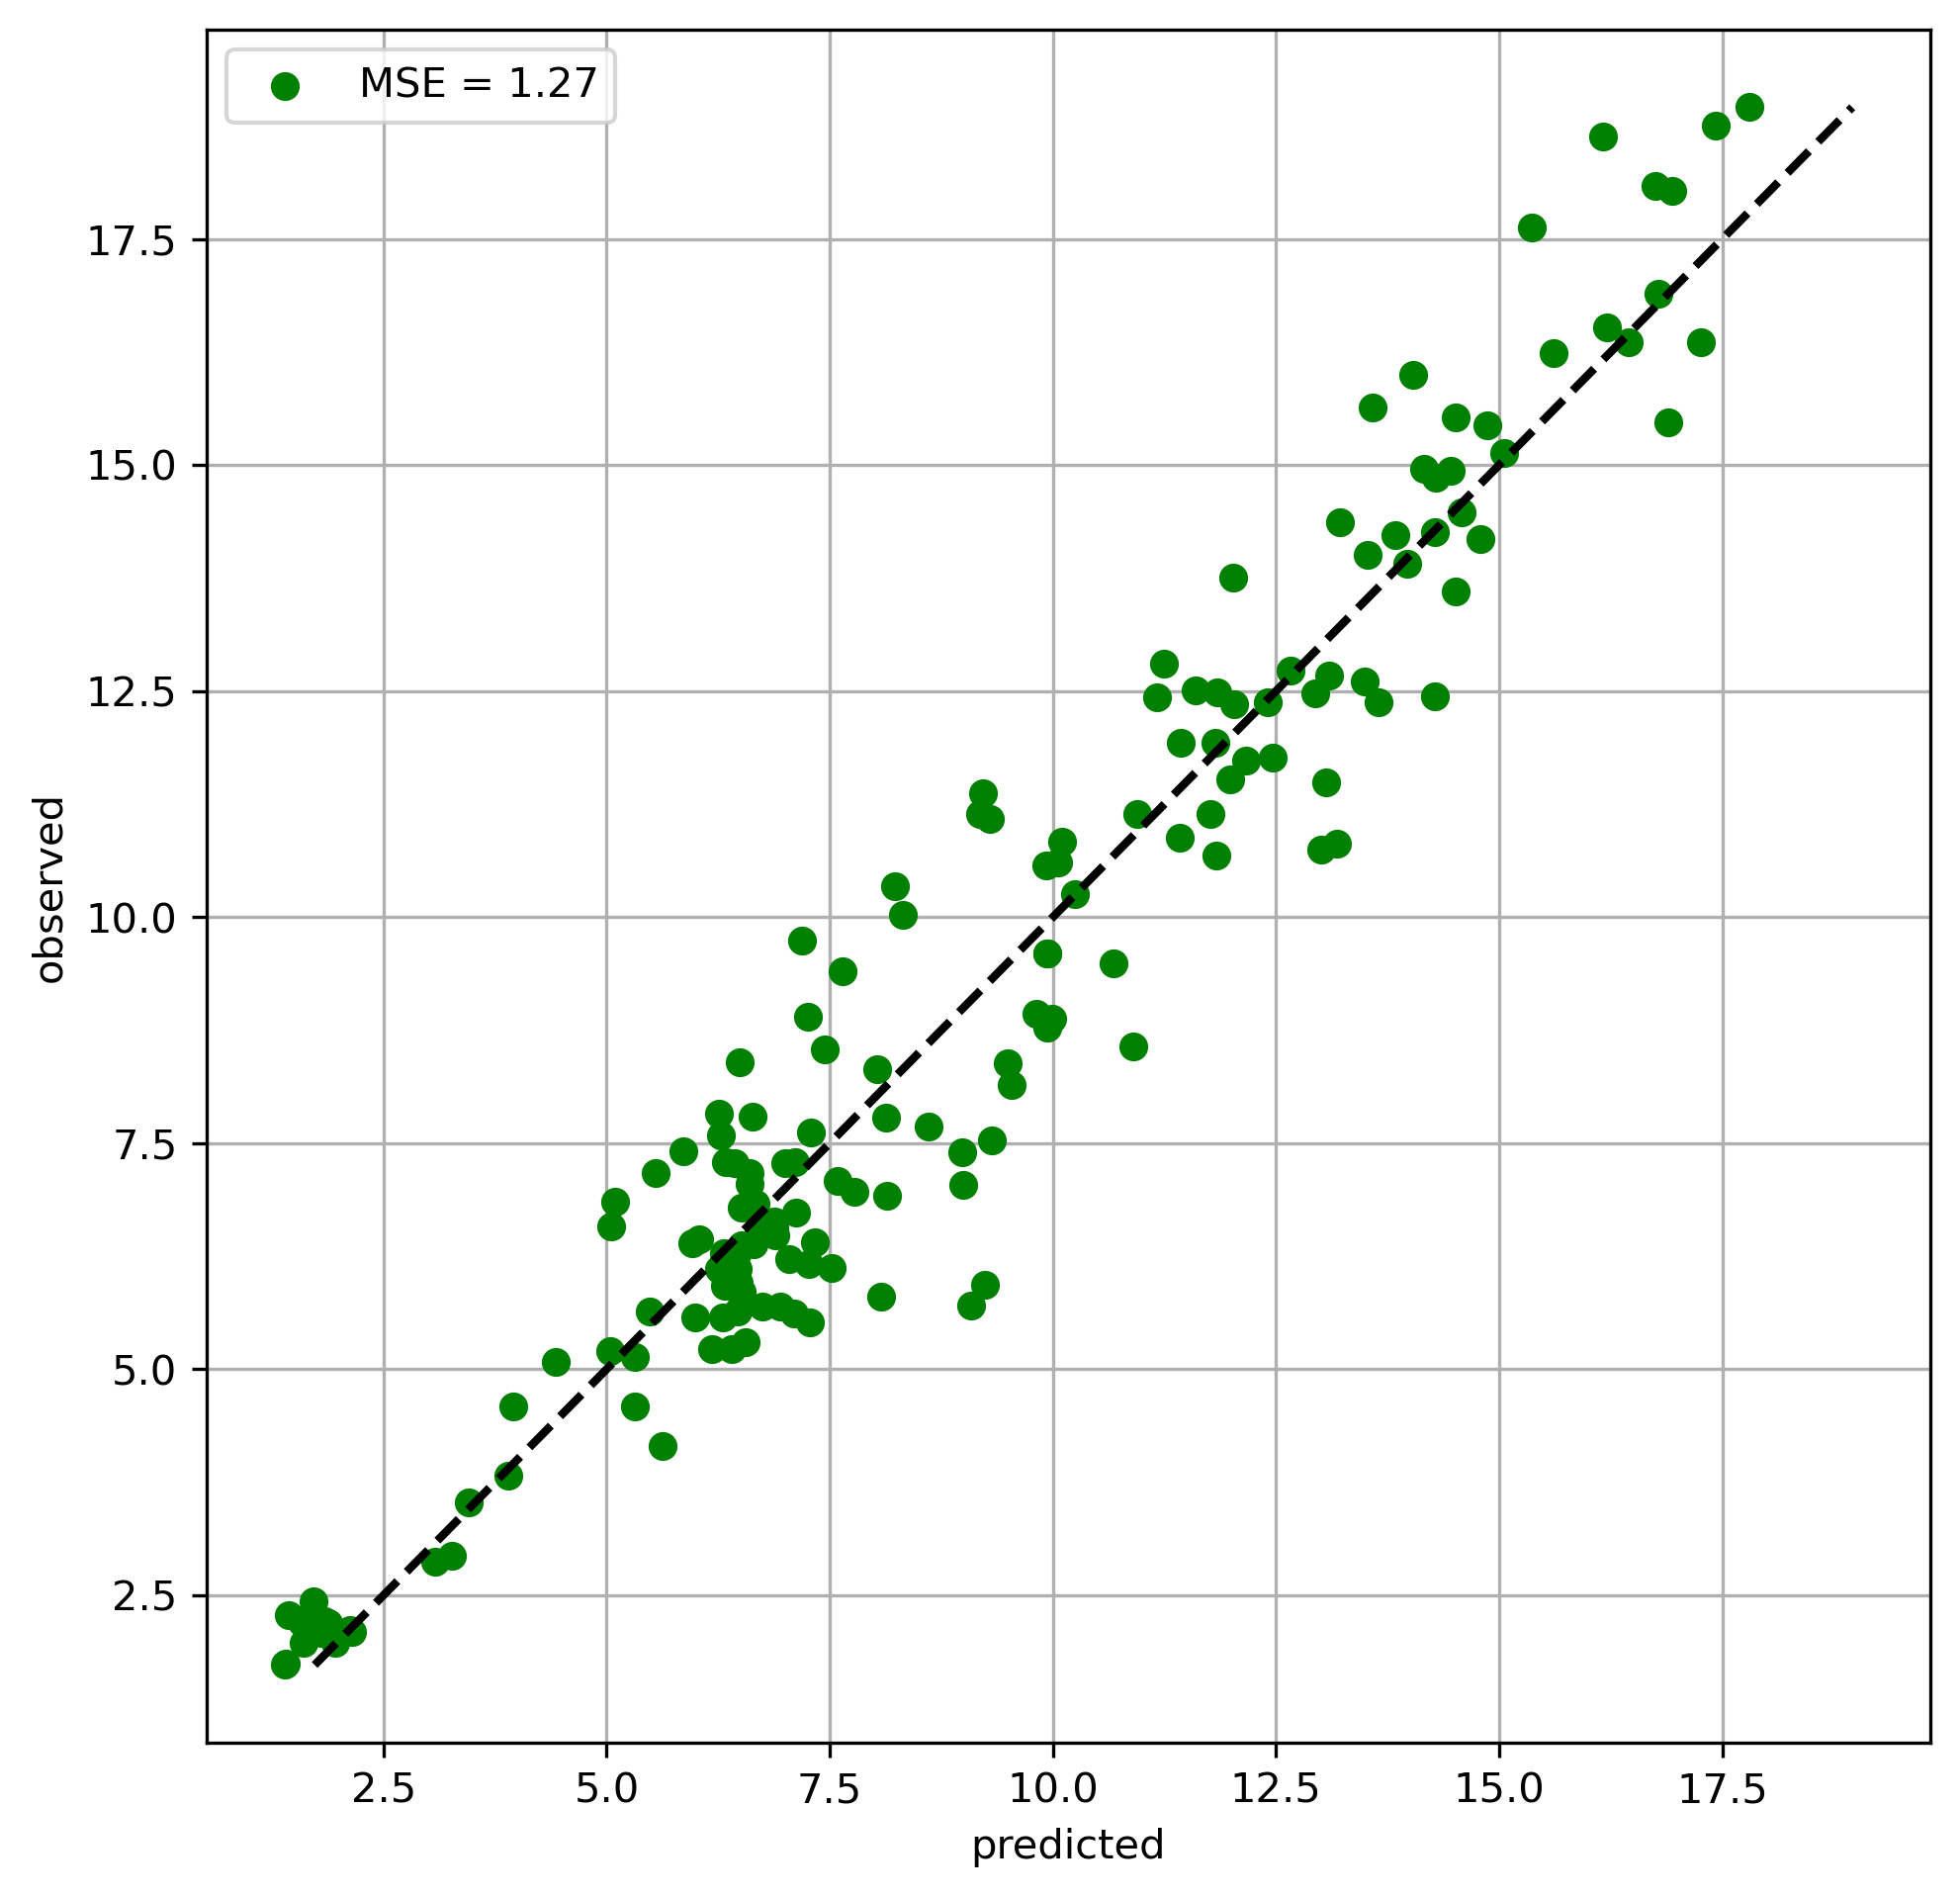

In [47]:
modelo_reducido = sm.OLS(y, sm.add_constant(X_reducido)).fit()
pred = modelo_reducido.predict(sm.add_constant(X_reducido))
fig, ax = plt.subplots(figsize = (7.5,7.5), dpi = 300)
mse = np.mean((pred - y)**2)
ax.scatter(pred, y, color = 'green', label = f'MSE = {mse:.2f}', zorder = 2)
ax.plot([y.min(), y.max()], [y.min(), y.max()], color = 'black', linestyle='--', linewidth=2, zorder = 2)
ax.legend()
ax.set_xlabel('predicted')
ax.set_ylabel('observed')
ax.grid(zorder = 0)

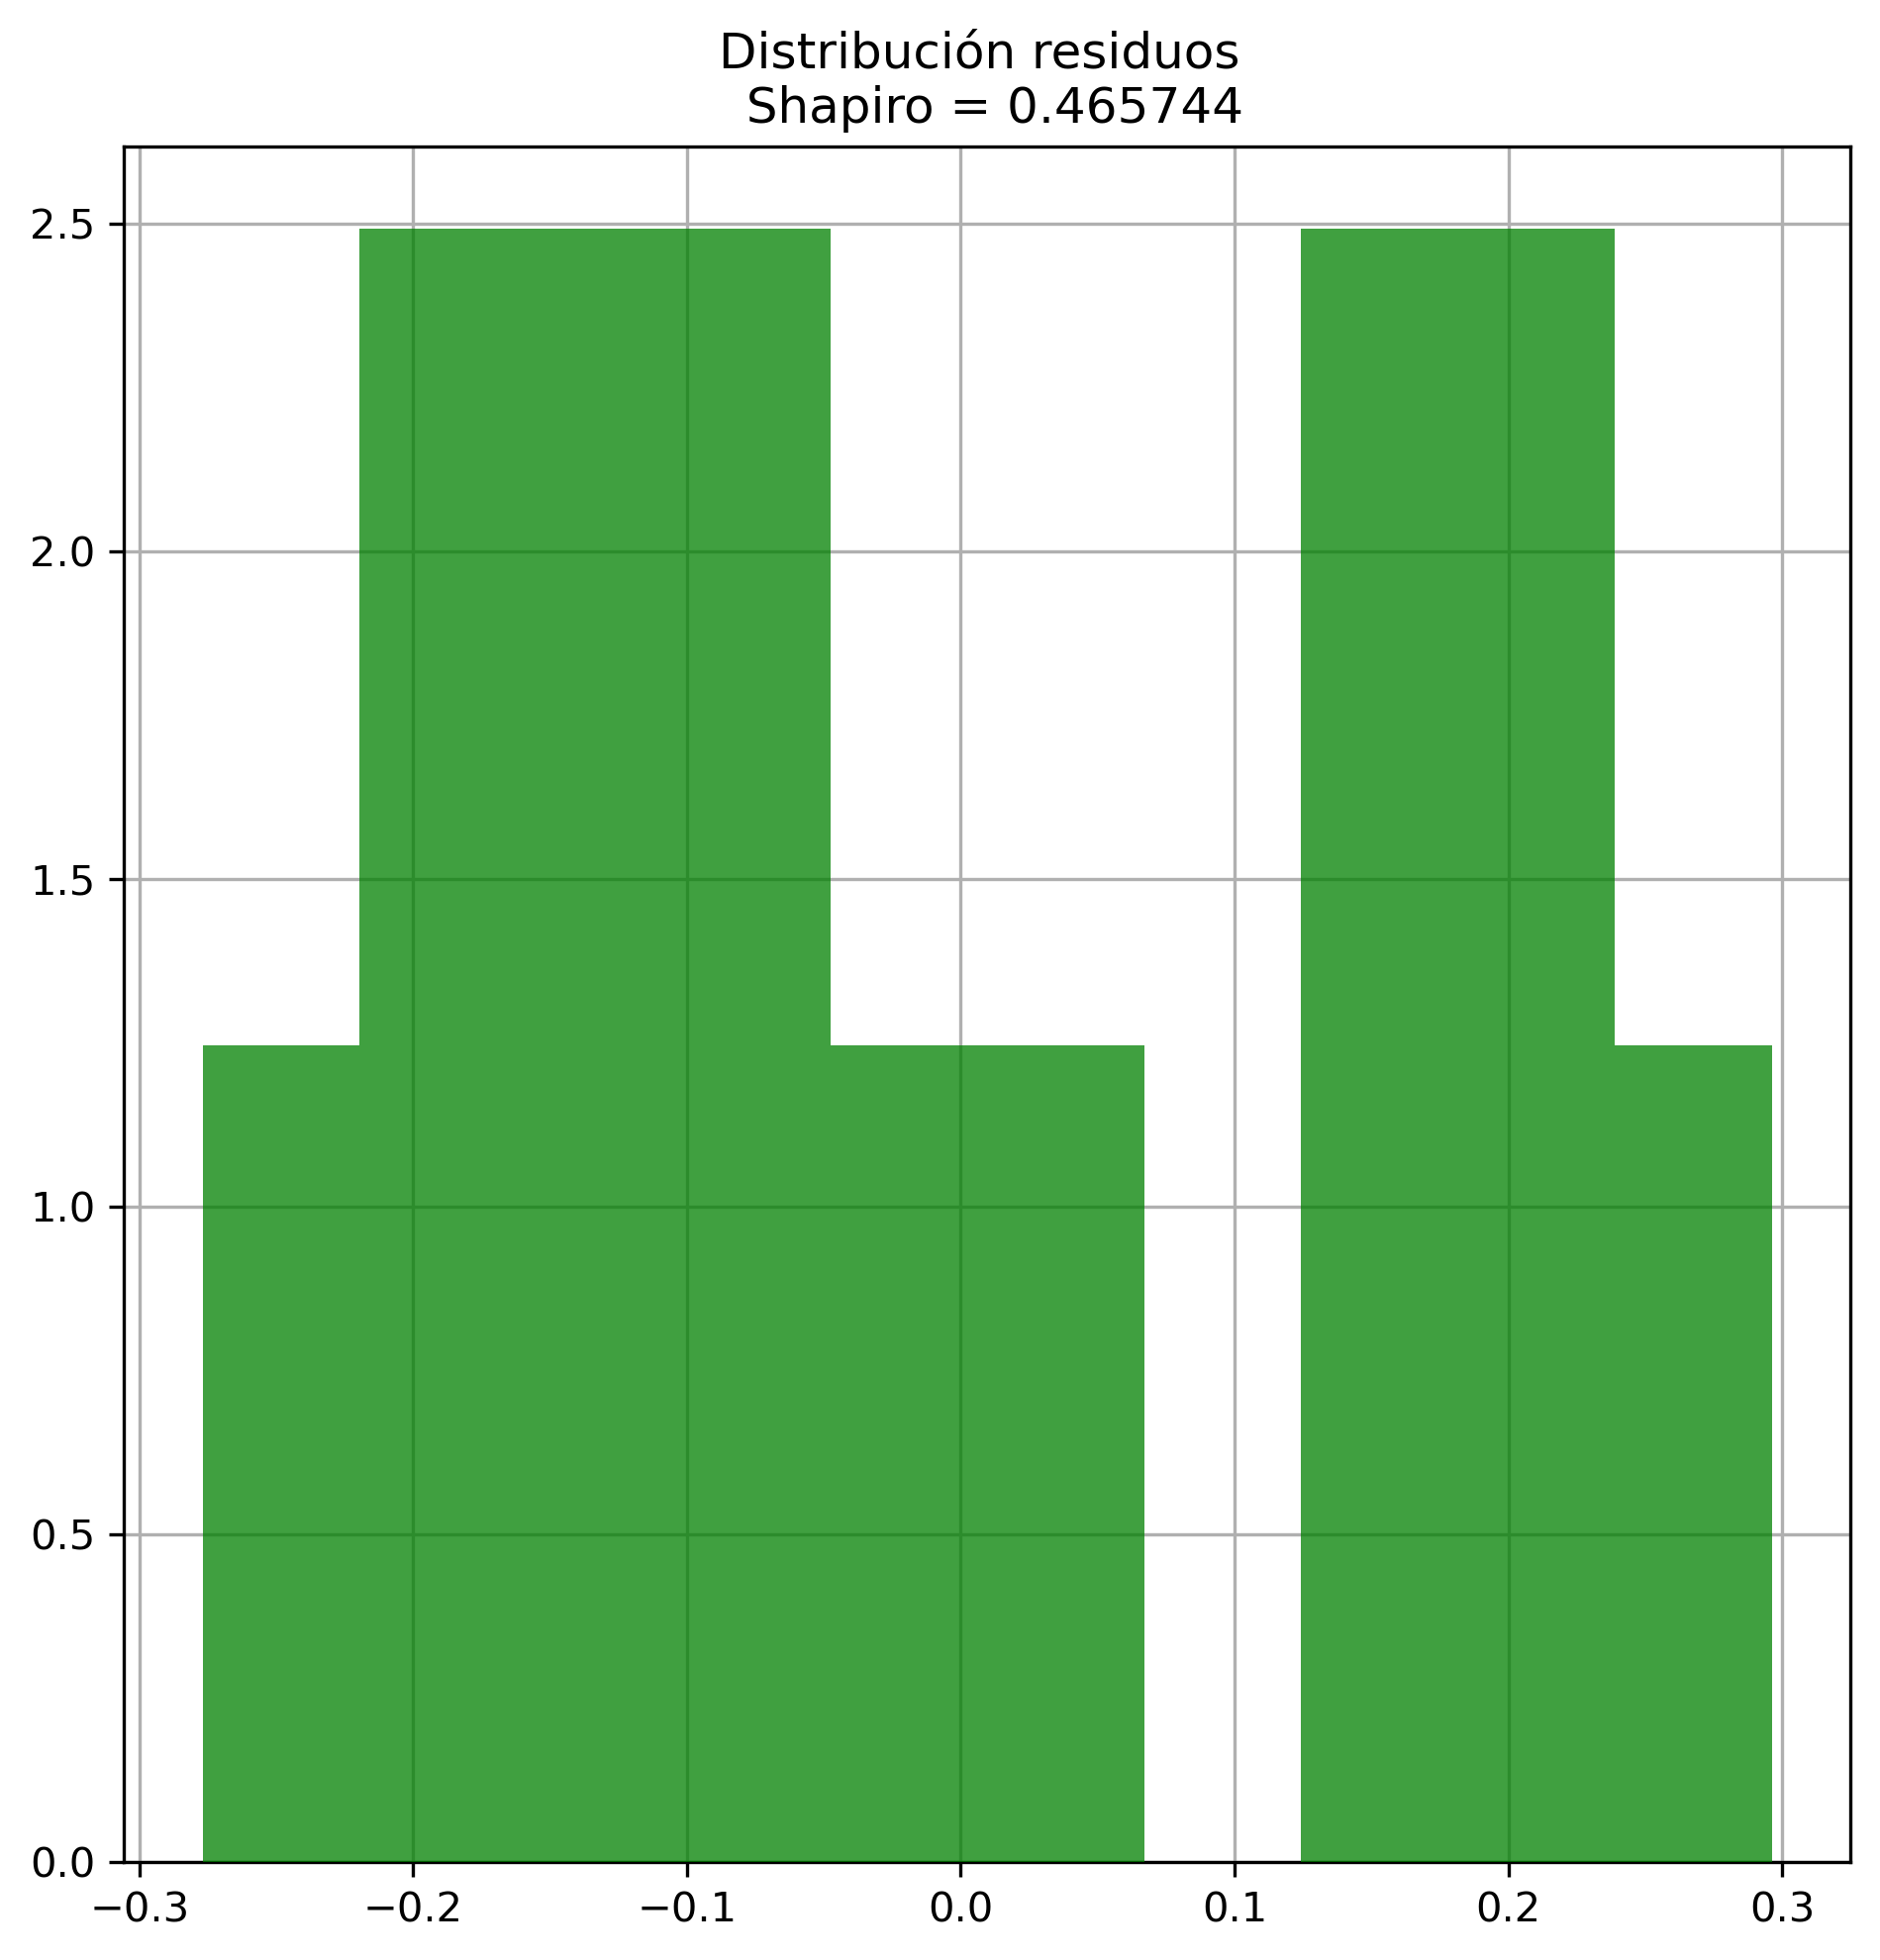

In [56]:
redis = modelo_reducido.resid

fig, ax = plt.subplots(figsize = (7.5,7.5), dpi = 300)
shapiro = stats.shapiro(resid)[1]
ax.hist(resid, density = True, color = 'green', zorder = 3, alpha = 0.75)
ax.set_title(f'Distribución residuos \n Shapiro = {shapiro:1f}')
ax.grid(zorder = 0)
plt.show()

